**NFL Challange**


# Import Modules and Data

In [1]:
import pandas as pd
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from sklearn.impute import SimpleImputer
from geopy.geocoders import Nominatim
pd.options.mode.chained_assignment = None  
%matplotlib inline
import mpl_toolkits
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import check_array
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dropout
from keras import regularizers
from sklearn.decomposition import PCA
import regex as re
#from sklearn_pandas import CategoricalImputer
from time import time
import warnings
import json
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.utils import check_array
from scipy import sparse, stats
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from math import sqrt
import time
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


Read the datasets into a utf-8 encoded dataframe 

In [2]:
nfl_stadiums=pd.read_csv("../nfl-scores-and-betting-data/nfl_stadiums.csv",encoding = "utf-8")
nfl_teams=pd.read_csv("../nfl-scores-and-betting-data/nfl_teams.csv",encoding = "utf-8")
nfl_scores=pd.read_csv("../nfl-scores-and-betting-data/spreadspoke_scores.csv",encoding = "utf-8")

## Functions

The cell below contains various functions that will be required in this project

In [3]:
def pct(x):
    return round(100*x,1)
def count_null(df,column): # count the number of null values in a dataframe
    try:
        for x in column:
            null=sum(pd.isnull(df[x]))
            print(x,null)
    except Exception:
            pass
class DataFrameSelector(BaseEstimator, TransformerMixin): # Select attributes of a dataframe
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class CategoricalEncoder(BaseEstimator, TransformerMixin): #Encode categorical features of the dataframe 
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out
def ttest(control, treatment): #perform a ttest statistic of the experiment
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

def create_model(kernel_initializer='uniform',dropout=0.2):
    model = Sequential()
    model.add(Dense(40,activation='relu',kernel_initializer=kernel_initializer,kernel_regularizer=regularizers.L1L2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(41,activation='tanh',kernel_initializer=kernel_initializer,kernel_regularizer=regularizers.L1L2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer=kernel_initializer,activation='linear'))
    model.add(Dropout(dropout))
    model.compile(loss="mean_squared_error",optimizer="SGD", metrics=["mse"])
    return model

# Fix Nulls

In [4]:
# Create a list of all the columns in each dataset
column_teams=list(nfl_teams.columns)
column_scores=list(nfl_scores.columns)
column_stadiums=list(nfl_stadiums.columns)

In [5]:
#What the scores table looks like
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_detail,weather_temperature,weather_wind_mph,weather_humidity,score_home,score_away,stadium_neutral,schedule_playoff
0,9/2/1966,1966,1,Miami Dolphins,Oakland Raiders,Orange Bowl,NaN,NaN,NaN,NaN,83.0,6.0,71,14.0,23.0,False,False
1,9/3/1966,1966,1,Houston Oilers,Denver Broncos,Rice Stadium,NaN,NaN,NaN,NaN,81.0,7.0,70,45.0,7.0,False,False
2,9/4/1966,1966,1,San Diego Chargers,Buffalo Bills,Balboa Stadium,NaN,NaN,NaN,NaN,70.0,7.0,82,27.0,7.0,False,False
3,9/9/1966,1966,2,Miami Dolphins,New York Jets,Orange Bowl,NaN,NaN,NaN,NaN,82.0,11.0,78,14.0,19.0,False,False
4,9/10/1966,1966,1,Green Bay Packers,Baltimore Colts,Lambeau Field,NaN,NaN,NaN,64 degrees- humidity 62%- wind 8 mph,64.0,8.0,62,24.0,3.0,False,False


## Nulls for NFL Scores

**Actions in this Section**
* Convert the date to a datetime format.
* Drop unceccary rows where nulls exists.
* Use only rows where games happened after 1980 due to a lot of nulls before 1980.

In [6]:
#Current Nulls
count_null(nfl_scores,column_scores)

schedule_date 0
schedule_season 0
schedule_week 0
team_home 0
team_away 0
stadium 0
team_favorite_id 2601
spread_favorite 2601
over_under_line 2611
weather_detail 7930
weather_temperature 724
weather_wind_mph 724
weather_humidity 4013
score_home 135
score_away 135
stadium_neutral 0
schedule_playoff 0


In [7]:
#Clean the scores dataset and drop null values
nfl_scores["schedule_date"]=pd.to_datetime(nfl_scores["schedule_date"])
nfl_scores.dropna(subset=["score_home","over_under_line","weather_temperature","weather_wind_mph"], inplace=True)
nfl_scores=nfl_scores[nfl_scores['schedule_date'].dt.year >= 1980]

In [8]:
nfl_scores.drop(["weather_humidity","weather_detail","schedule_playoff"], axis=1,inplace=True)

In [9]:
#nfl_scores.loc[(nfl_scores.schedule_week == '18'), 'schedule_week'] = '18'
nfl_scores.loc[(nfl_scores.schedule_week == 'Wildcard') | (nfl_scores.schedule_week == 'WildCard'), 'schedule_week'] = '18'
nfl_scores.loc[(nfl_scores.schedule_week == 'Division'), 'schedule_week'] = '19'
nfl_scores.loc[(nfl_scores.schedule_week == 'Conference'), 'schedule_week'] = '20'
nfl_scores.loc[(nfl_scores.schedule_week == 'Superbowl') | (nfl_scores.schedule_week == 'SuperBowl'), 'schedule_week'] = '21'
nfl_scores['schedule_week'] = nfl_scores.schedule_week.astype(int)

In [10]:
count_null(nfl_scores,column_scores)

schedule_date 0
schedule_season 0
schedule_week 0
team_home 0
team_away 0
stadium 0
team_favorite_id 0
spread_favorite 0
over_under_line 0


The output result above shows no null values present in the scores dataset

In [11]:
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
2734,1980-09-07,1980,1,Buffalo Bills,Miami Dolphins,Ralph Wilson Stadium,MIA,-3.0,35,64.0,8.0,17.0,7.0,False
2735,1980-09-07,1980,1,Cincinnati Bengals,Tampa Bay Buccaneers,Cinergy Field,TB,-1.0,34,72.0,9.0,12.0,17.0,False
2736,1980-09-07,1980,1,Green Bay Packers,Chicago Bears,Lambeau Field,CHI,-6.0,35,65.0,5.0,12.0,6.0,False
2737,1980-09-07,1980,1,Kansas City Chiefs,Oakland Raiders,Arrowhead Stadium,KC,-3.0,42,82.0,10.0,14.0,27.0,False
2738,1980-09-07,1980,1,Los Angeles Rams,Detroit Lions,Anaheim Stadium,LAR,-9.0,38,66.0,11.0,20.0,41.0,False


## Nulls for NFL Teams

In [12]:
count_null(nfl_teams,column_teams)

team_name 0
team_name_short 0
team_id 0
team_id_pfr 0
team_conference 0
team_division 8
team_conference_pre2002 0
team_division_pre2002 2


Team division and team_division_pre2002 both contain null values

In [13]:
nfl_teams.head()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,CRD,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,ARI,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central


In [14]:
null_columns=nfl_teams.columns[nfl_teams.isnull().any()]
print(nfl_teams[nfl_teams["team_division_pre2002"].isnull()][null_columns])

   team_division team_division_pre2002
14     AFC South                   NaN
26           NaN                   NaN


## Nulls for NFL Stadiums
**Actions in this Section**
* Fill in nulls of stadium close with 2018 for better visualizations.
* Fill in the NA of the Lat, Long and Elevation with 0's for easy manipulation.
* Drop Stadium Close with nulls
* Drop Unneccesary columns.
* Fill in missing lattitude and Longitude with accurate geopoints.

In [15]:
nfl_stadiums['stadium_close'] = nfl_stadiums['stadium_close'].fillna(2018)
nfl_stadiums['LATITUDE'] = nfl_stadiums['LATITUDE'].fillna(0)
nfl_stadiums['LONGITUDE'] = nfl_stadiums['LONGITUDE'].fillna(0)
nfl_stadiums['ELEVATION'] = nfl_stadiums['ELEVATION'].fillna(0)
nfl_stadiums=nfl_stadiums[(nfl_stadiums['stadium_close'] >= 1980)]
count_null(nfl_stadiums,column_stadiums)

stadium_name 0
stadium_location 0
stadium_open 23
stadium_close 0
stadium_type 7
stadium_address 9
stadium_weather_station_code 10
stadium_weather_type 7
stadium_capacity 58
stadium_surface 45
STATION 44
NAME 44
LATITUDE 0
LONGITUDE 0
ELEVATION 0


In [16]:
print(len(nfl_stadiums))

nfl_stadiums.head(5)

96


,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Alamo Dome,"San Antonio, TX",NaN,2018.0,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,0.0000,0.0000,0.0
1,Alltel Stadium,"Jacksonville, FL",NaN,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0
2,Alumni Stadium,"Chestnut Hill, MA",NaN,2018.0,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,cold,NaN,Grass,NaN,NaN,0.0000,0.0000,0.0
3,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0
4,Arrowhead Stadium,"Kansas City, MO",1972.0,2018.0,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,cold,"76,416",Grass,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",39.0692,-94.4871,264.9


In [17]:
#Fills in the Latitude, Longitude and Elevation where it is missing.
geolocator = Nominatim(user_agent="NFL")
for i, row in nfl_stadiums.iterrows():
    try:
        if nfl_stadiums.LATITUDE[i]==0:
            location = geolocator.geocode(nfl_stadiums.stadium_address[i])
            nfl_stadiums.LATITUDE[i]=location.latitude
            nfl_stadiums.LONGITUDE[i]=location.longitude
            nfl_stadiums.ELEVATION[i]=location.altitude
        else:
            pass
    except:
        pass

In [18]:
#drop unnecessary tables
nfl_stadiums.dropna(subset=["stadium_open"], inplace=True)
nfl_stadiums.drop(["NAME","stadium_surface", "stadium_capacity", "STATION","stadium_weather_station_code"], axis=1,inplace=True)

In [19]:
#Fill NA values of the stadiums dataset
nfl_stadiums['stadium_close'] = nfl_stadiums['stadium_close'].fillna(2020)
nfl_stadiums['LATITUDE'] = nfl_stadiums['LATITUDE'].fillna(0)
nfl_stadiums['LONGITUDE'] = nfl_stadiums['LONGITUDE'].fillna(0)
nfl_stadiums['ELEVATION'] = nfl_stadiums['ELEVATION'].fillna(0)
nfl_stadiums=nfl_stadiums[(nfl_stadiums['stadium_close'] >= 1980)]

In [20]:
geolocator = Nominatim(user_agent="NFL")
for i, row in nfl_stadiums.iterrows():
    try:
        if nfl_stadiums.LATITUDE[i]==0:
            location = geolocator.geocode(nfl_stadiums.stadium_address[i])
            nfl_stadiums.LATITUDE[i]=location.latitude
            nfl_stadiums.LONGITUDE[i]=location.longitude
            nfl_stadiums.ELEVATION[i]=location.altitude
        else:
            pass
    except:
        pass
        

In [21]:
count_null(nfl_stadiums,column_stadiums)

stadium_name 0
stadium_location 0
stadium_open 0
stadium_close 0
stadium_type 0
stadium_address 0


# EDA

This section will involve exploratory data analysis of the three datasets 

## EDA for NFL_Scores

In [22]:
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
2734,1980-09-07,1980,1,Buffalo Bills,Miami Dolphins,Ralph Wilson Stadium,MIA,-3.0,35,64.0,8.0,17.0,7.0,False
2735,1980-09-07,1980,1,Cincinnati Bengals,Tampa Bay Buccaneers,Cinergy Field,TB,-1.0,34,72.0,9.0,12.0,17.0,False
2736,1980-09-07,1980,1,Green Bay Packers,Chicago Bears,Lambeau Field,CHI,-6.0,35,65.0,5.0,12.0,6.0,False
2737,1980-09-07,1980,1,Kansas City Chiefs,Oakland Raiders,Arrowhead Stadium,KC,-3.0,42,82.0,10.0,14.0,27.0,False
2738,1980-09-07,1980,1,Los Angeles Rams,Detroit Lions,Anaheim Stadium,LAR,-9.0,38,66.0,11.0,20.0,41.0,False


In [23]:
nfl_scores.shape

(9181, 14)

In [24]:
nfl_scores.dtypes

schedule_date          datetime64[ns]
schedule_season                 int64
schedule_week                   int64
team_home                      object
team_away                      object
stadium                        object
team_favorite_id               object
spread_favorite               float64
over_under_line                object
weather_temperature           float64
weather_wind_mph              float64
score_home                    float64
score_away                    float64
stadium_neutral                  bool
dtype: object

In [25]:
nfl_scores['over_under_line'] = nfl_scores['over_under_line'].astype(float)

In [26]:
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9181 entries, 2734 to 12264
Data columns (total 14 columns):
schedule_date          9181 non-null datetime64[ns]
schedule_season        9181 non-null int64
schedule_week          9181 non-null int64
team_home              9181 non-null object
team_away              9181 non-null object
stadium                9181 non-null object
team_favorite_id       9181 non-null object
spread_favorite        9181 non-null float64
over_under_line        9181 non-null float64
weather_temperature    9181 non-null float64
weather_wind_mph       9181 non-null float64
score_home             9181 non-null float64
score_away             9181 non-null float64
stadium_neutral        9181 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 1013.1+ KB


In [27]:
nfl_scores.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
schedule_season,9181.0,1999.701884,10.993210,1980.0,1990.0,2000.0,2009.0,2018.0
schedule_week,9181.0,8.924191,4.974480,1.0,5.0,9.0,13.0,21.0
spread_favorite,9181.0,-5.348219,3.415997,-26.5,-7.0,-4.5,-3.0,0.0
over_under_line,9181.0,41.823244,4.576730,28.0,38.0,41.5,45.0,63.0
weather_temperature,9181.0,59.752423,15.481616,-6.0,49.0,63.0,72.0,97.0
weather_wind_mph,9181.0,7.389936,5.692980,0.0,2.0,8.0,11.0,40.0
score_home,9181.0,22.561159,10.349465,0.0,16.0,22.0,30.0,62.0
score_away,9181.0,19.880841,10.042576,0.0,13.0,20.0,27.0,59.0


### Change Name mappings

There were some inconsistancies in the data set. For example, the Chicago Bears were referenced by CHI and Chicago Bears. So made all the name callings but the short two or three letter code. 


In [28]:
name_mappings = [('ATL','Atlanta Falcons'),
                 ('BUF', 'Buffalo Bills'),
                 ('JAX','Jacksonville Jaguars'),
                 ('DAL', 'Dallas Cowboys'),
                 ('GB', 'Green Bay Packers'),
                 ('IND','Indianapolis Colts'),
                 ('MIA', 'Miami Dolphins'),
                 ('MIN','Minnesota Vikings'),
                 ('TB', 'Tampa Bay Buccaneers'),
                 ('NYG','New York Giants'),
                 ('OAK', 'Oakland Raiders'),
                 ('BAL','Baltimore Ravens'),
                 ('WAS', 'Washington Redskins'),
                 ('LAR', 'Los Angeles Rams'),
                 ('ARI', 'Arizona Cardinals'),
                 ('CIN', 'Cincinnati Bengals'),
                 ('DEN', 'Denver Broncos'),
                 ('PHI', 'Philadelphia Eagles'),
                 ('LAC','Los Angeles Chargers'),
                 ('CAR','Carolina Panthers'),
                 ('TEN','Tennessee Titans'),
                 ('NYJ', 'New York Jets'),
                 ('CHI', 'Chicago Bears'),
                 ('LAR', 'St. Louis Rams'),
                 ('PIT', 'Pittsburgh Steelers'),
                 ('KC', 'Kansas City Chiefs'),
                 ('LAC', 'San Diego Chargers'),
                 ('NE','New England Patriots'),
                 ('SEA','Seattle Seahawks'),
                 ('NO', 'New Orleans Saints'),
                 ('DET', 'Detroit Lions'),
                 ('SF', 'San Francisco 49ers'),
                 ('CLE', 'Cleveland Browns'),
                 ('HOU', 'Houston Texans'),
                 ('TEN','Houston Oilers'),
                 ('OAK','Los Angeles Raiders'),
                 ('ARI','St. Louis Cardinals'),
                 ('ARI','Phoenix Cardinals'),
                 ('IND','Baltimore Colts'),
                 ('TEN','Tennessee Oilers')]
    
for mapping in name_mappings:
    nfl_scores.team_away.replace(mapping[1], mapping[0],inplace=True)
    nfl_scores.team_home.replace(mapping[1], mapping[0],inplace=True)

In later examining our dataset, we noticed an error where DET was listed as playing twice in a single week (shown below). The second instance was actually their week 5 game (instead of two week 4), so we corrected that in place. 

In [29]:
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
2734,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,8.0,17.0,7.0,False
2735,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,9.0,12.0,17.0,False
2736,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,5.0,12.0,6.0,False
2737,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,10.0,14.0,27.0,False
2738,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,11.0,20.0,41.0,False


In [30]:
nfl_scores[((nfl_scores['team_home'] == 'DET') | (nfl_scores['team_away'] == 'DET')) & 
           (nfl_scores['schedule_season'] == 1990) & (nfl_scores['schedule_week'] == 4)]

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
4959,1990-09-30,1990,4,DET,GB,Pontiac Silverdome,DET,-2.5,46.0,72.0,0.0,21.0,24.0,False
4978,1990-10-07,1990,4,MIN,DET,Hubert H. Humphrey Metrodome,MIN,-7.0,43.0,72.0,0.0,27.0,34.0,False


In [31]:
nfl_scores.at[4978, 'schedule_week'] = 5

In [32]:
nfl_scores[((nfl_scores['team_home'] == 'DET') | (nfl_scores['team_away'] == 'DET')) & 
         (nfl_scores['schedule_season'] == 1990) & (nfl_scores['schedule_week'].between(4,5, inclusive = True) )]

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
4959,1990-09-30,1990,4,DET,GB,Pontiac Silverdome,DET,-2.5,46.0,72.0,0.0,21.0,24.0,False
4978,1990-10-07,1990,5,MIN,DET,Hubert H. Humphrey Metrodome,MIN,-7.0,43.0,72.0,0.0,27.0,34.0,False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d9535f8>,
      dtype=object)

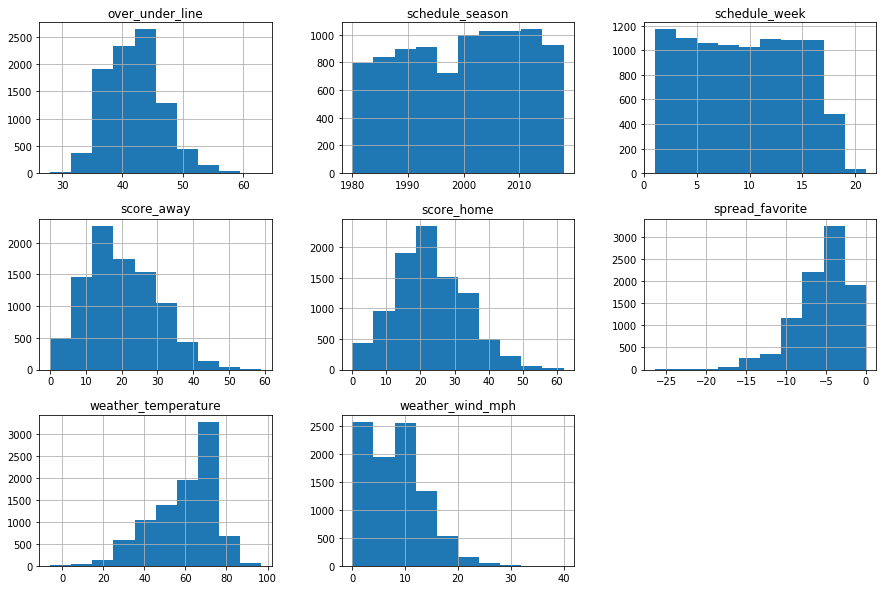

In [33]:
num_nfl_scores = nfl_scores[["schedule_season","schedule_week","spread_favorite","over_under_line",
                            "weather_temperature","weather_wind_mph","score_home","score_away"]]
num_nfl_scores.hist(figsize=(15,10))

In [34]:
#Out of the 8 attributes, over_under_line, score_away, and score_home are somewhat bell-shaped though skewed to the left.

     Compute the correlation the different attributes with relation to the spread_favorite

In [35]:
corr = nfl_scores.corr()
corr['spread_favorite'].sort_values(ascending=False)

spread_favorite        1.000000
score_away             0.125770
weather_temperature    0.066207
stadium_neutral        0.010537
schedule_season       -0.015780
weather_wind_mph      -0.028922
over_under_line       -0.045582
schedule_week         -0.076572
score_home            -0.140107
Name: spread_favorite, dtype: float64

In [36]:
#Score_away and score_home possess the highest correlation based on the output above

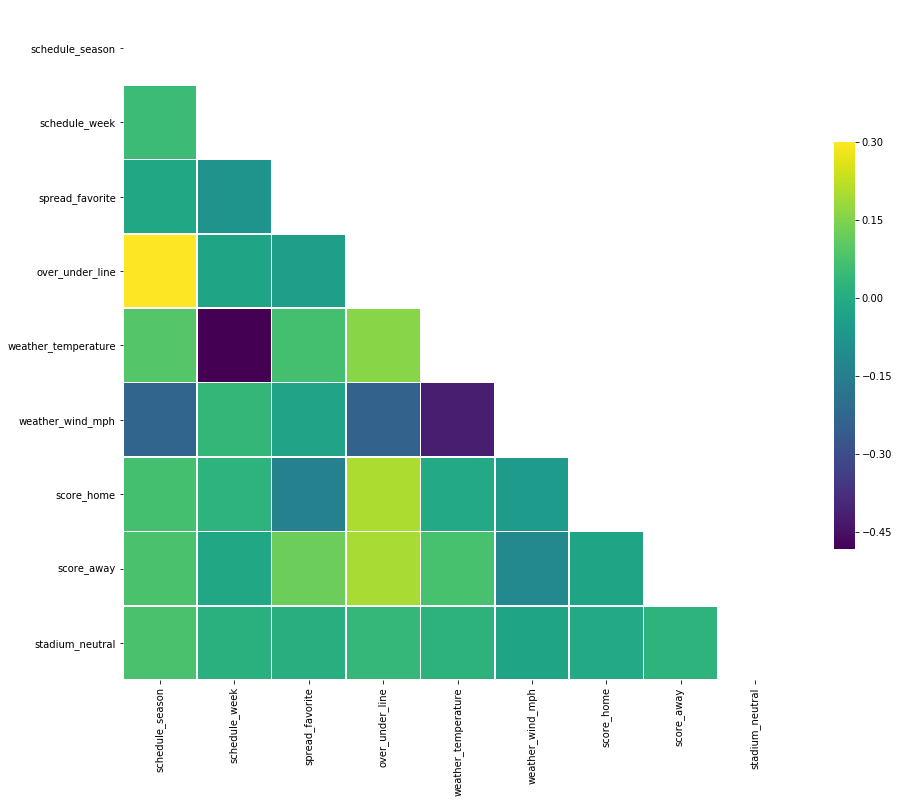

In [37]:
# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="viridis", vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


for tick in ax.get_yticklabels():
    tick.set_rotation(0);

### EDA for NFL Teams

#### Find the total number of teams
There are 33 unique teams. 

In [38]:
unique_teams = nfl_teams['team_name_short'].unique()
print('# of Unique Teams (all eras)',len(unique_teams))
unique_teams

# of Unique Teams (all eras) 33


array(['Cardinals', 'Falcons', 'Ravens', 'Bills', 'Panthers', 'Bears',
       'Bengals', 'Browns', 'Cowboys', 'Broncos', 'Lions', 'Packers',
       'Texans', 'Colts', 'Jaguars', 'Chiefs', 'Chargers', 'Rams',
       'Dolphins', 'Vikings', 'Patriots', 'Saints', 'Giants', 'Jets',
       'Raiders', 'Eagles', 'Steelers', 'Seahawks', '49ers', 'Buccaneers',
       'Oilers', 'Titans', 'Redskins'], dtype=object)

#### Find the teams who have moved cities
Seven teams have moved (listed below) with the Cardinals moving the most (3 times)

In [39]:
team_counts = nfl_teams['team_name_short'].value_counts()
moved_teams = team_counts[team_counts>1]

print('# of Moved Teams', len(moved_teams))
moved_teams

# of Moved Teams 7


Cardinals    3
Raiders      2
Chargers     2
Colts        2
Patriots     2
Rams         2
Oilers       2
Name: team_name_short, dtype: int64

#### For those teams that moved cities, find which cities they were associated with. 

In [40]:
all_cities = []

for i in moved_teams.index: 
    full_names = nfl_teams[nfl_teams['team_name_short']==i]['team_name'].tolist()
    cities = [x.replace(i,'') for x in full_names]
    all_cities.append(cities)

pd.DataFrame({'Team':moved_teams.index, 
              'Cities':all_cities})

,Team,Cities
0,Cardinals,"[Arizona , Phoenix , St. Louis ]"
1,Raiders,"[Los Angeles , Oakland ]"
2,Chargers,"[Los Angeles , San Diego ]"
3,Colts,"[Baltimore , Indianapolis ]"
4,Patriots,"[New England , Boston ]"
5,Rams,"[Los Angeles , St. Louis ]"
6,Oilers,"[Houston , Tennessee ]"


#### Which teams are no longer around? 

In [41]:
extinct_teams = nfl_teams.team_name[nfl_teams.team_division.isna()]
extinct_teams

1       Phoenix Cardinals
2     St. Louis Cardinals
15        Baltimore Colts
22         St. Louis Rams
26        Boston Patriots
30    Los Angeles Raiders
37         Houston Oilers
38       Tennessee Oilers
Name: team_name, dtype: object

#### For the teams that are no longer around, which franchises did they become? 

In [42]:
current_team_names = nfl_teams.team_name_short[nfl_teams.team_division.isna()].unique()

nfl_teams.team_name[(nfl_teams.team_name_short.isin(current_team_names)) & (nfl_teams.team_division.notna())]

0        Arizona Cardinals
16      Indianapolis Colts
21        Los Angeles Rams
25    New England Patriots
31         Oakland Raiders
Name: team_name, dtype: object

#### How many teams are there per conference (pre-2002 and now)? 

In [43]:
new_teams = nfl_teams.team_name[nfl_teams.team_division_pre2002.isna()]

for team in new_teams: 
    if team not in extinct_teams.tolist(): 
        print(team)

Houston Texans


#### How many teams are in each division?

In [44]:
curr_div = nfl_teams.team_division.value_counts()
curr_div

AFC West     5
NFC West     4
AFC South    4
AFC East     4
AFC North    4
NFC North    4
NFC South    4
NFC East     4
Name: team_division, dtype: int64

#### How many teams are in each division pre-2002?

In [45]:
pre_2002_div = nfl_teams.team_division_pre2002.value_counts()
pre_2002_div

AFC Central    8
AFC West       7
NFC West       7
AFC East       6
NFC East       6
NFC Central    5
Name: team_division_pre2002, dtype: int64

#### Which NFL teams swtiched divisions?

In [46]:
nfl_teams[nfl_teams.team_division != nfl_teams.team_division_pre2002].dropna()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central
6,Carolina Panthers,Panthers,CAR,CAR,NFC,NFC South,NFC,NFC West
7,Chicago Bears,Bears,CHI,CHI,NFC,NFC North,NFC,NFC Central
8,Cincinnati Bengals,Bengals,CIN,CIN,AFC,AFC North,AFC,AFC Central
9,Cleveland Browns,Browns,CLE,CLE,AFC,AFC North,AFC,AFC Central
12,Detroit Lions,Lions,DET,DET,NFC,NFC North,NFC,NFC Central
13,Green Bay Packers,Packers,GB,GNB,NFC,NFC North,NFC,NFC Central
16,Indianapolis Colts,Colts,IND,CLT,AFC,AFC South,AFC,AFC East
17,Jacksonville Jaguars,Jaguars,JAX,JAX,AFC,AFC South,AFC,AFC Central


#### How many NFL teams per conference (post-2002)?

In [47]:
nfl_teams.team_conference.value_counts()

AFC    21
NFC    20
Name: team_conference, dtype: int64

#### How many NFL teams per conference (pre-2002)?

In [48]:
nfl_teams.team_conference_pre2002.value_counts()

AFC    22
NFC    19
Name: team_conference_pre2002, dtype: int64

#### Which team switched conferences?

In [49]:
nfl_teams[nfl_teams.team_conference != nfl_teams.team_conference_pre2002].dropna()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
34,Seattle Seahawks,Seahawks,SEA,SEA,NFC,NFC West,AFC,AFC West


### EDA for NFL Stadiums

**Life of a Stadium**
* This shows the life of a stadium by how long it has been active
* The types of weather in these stadiums. 
* This shows the map of the united states of where the stadiums are located 

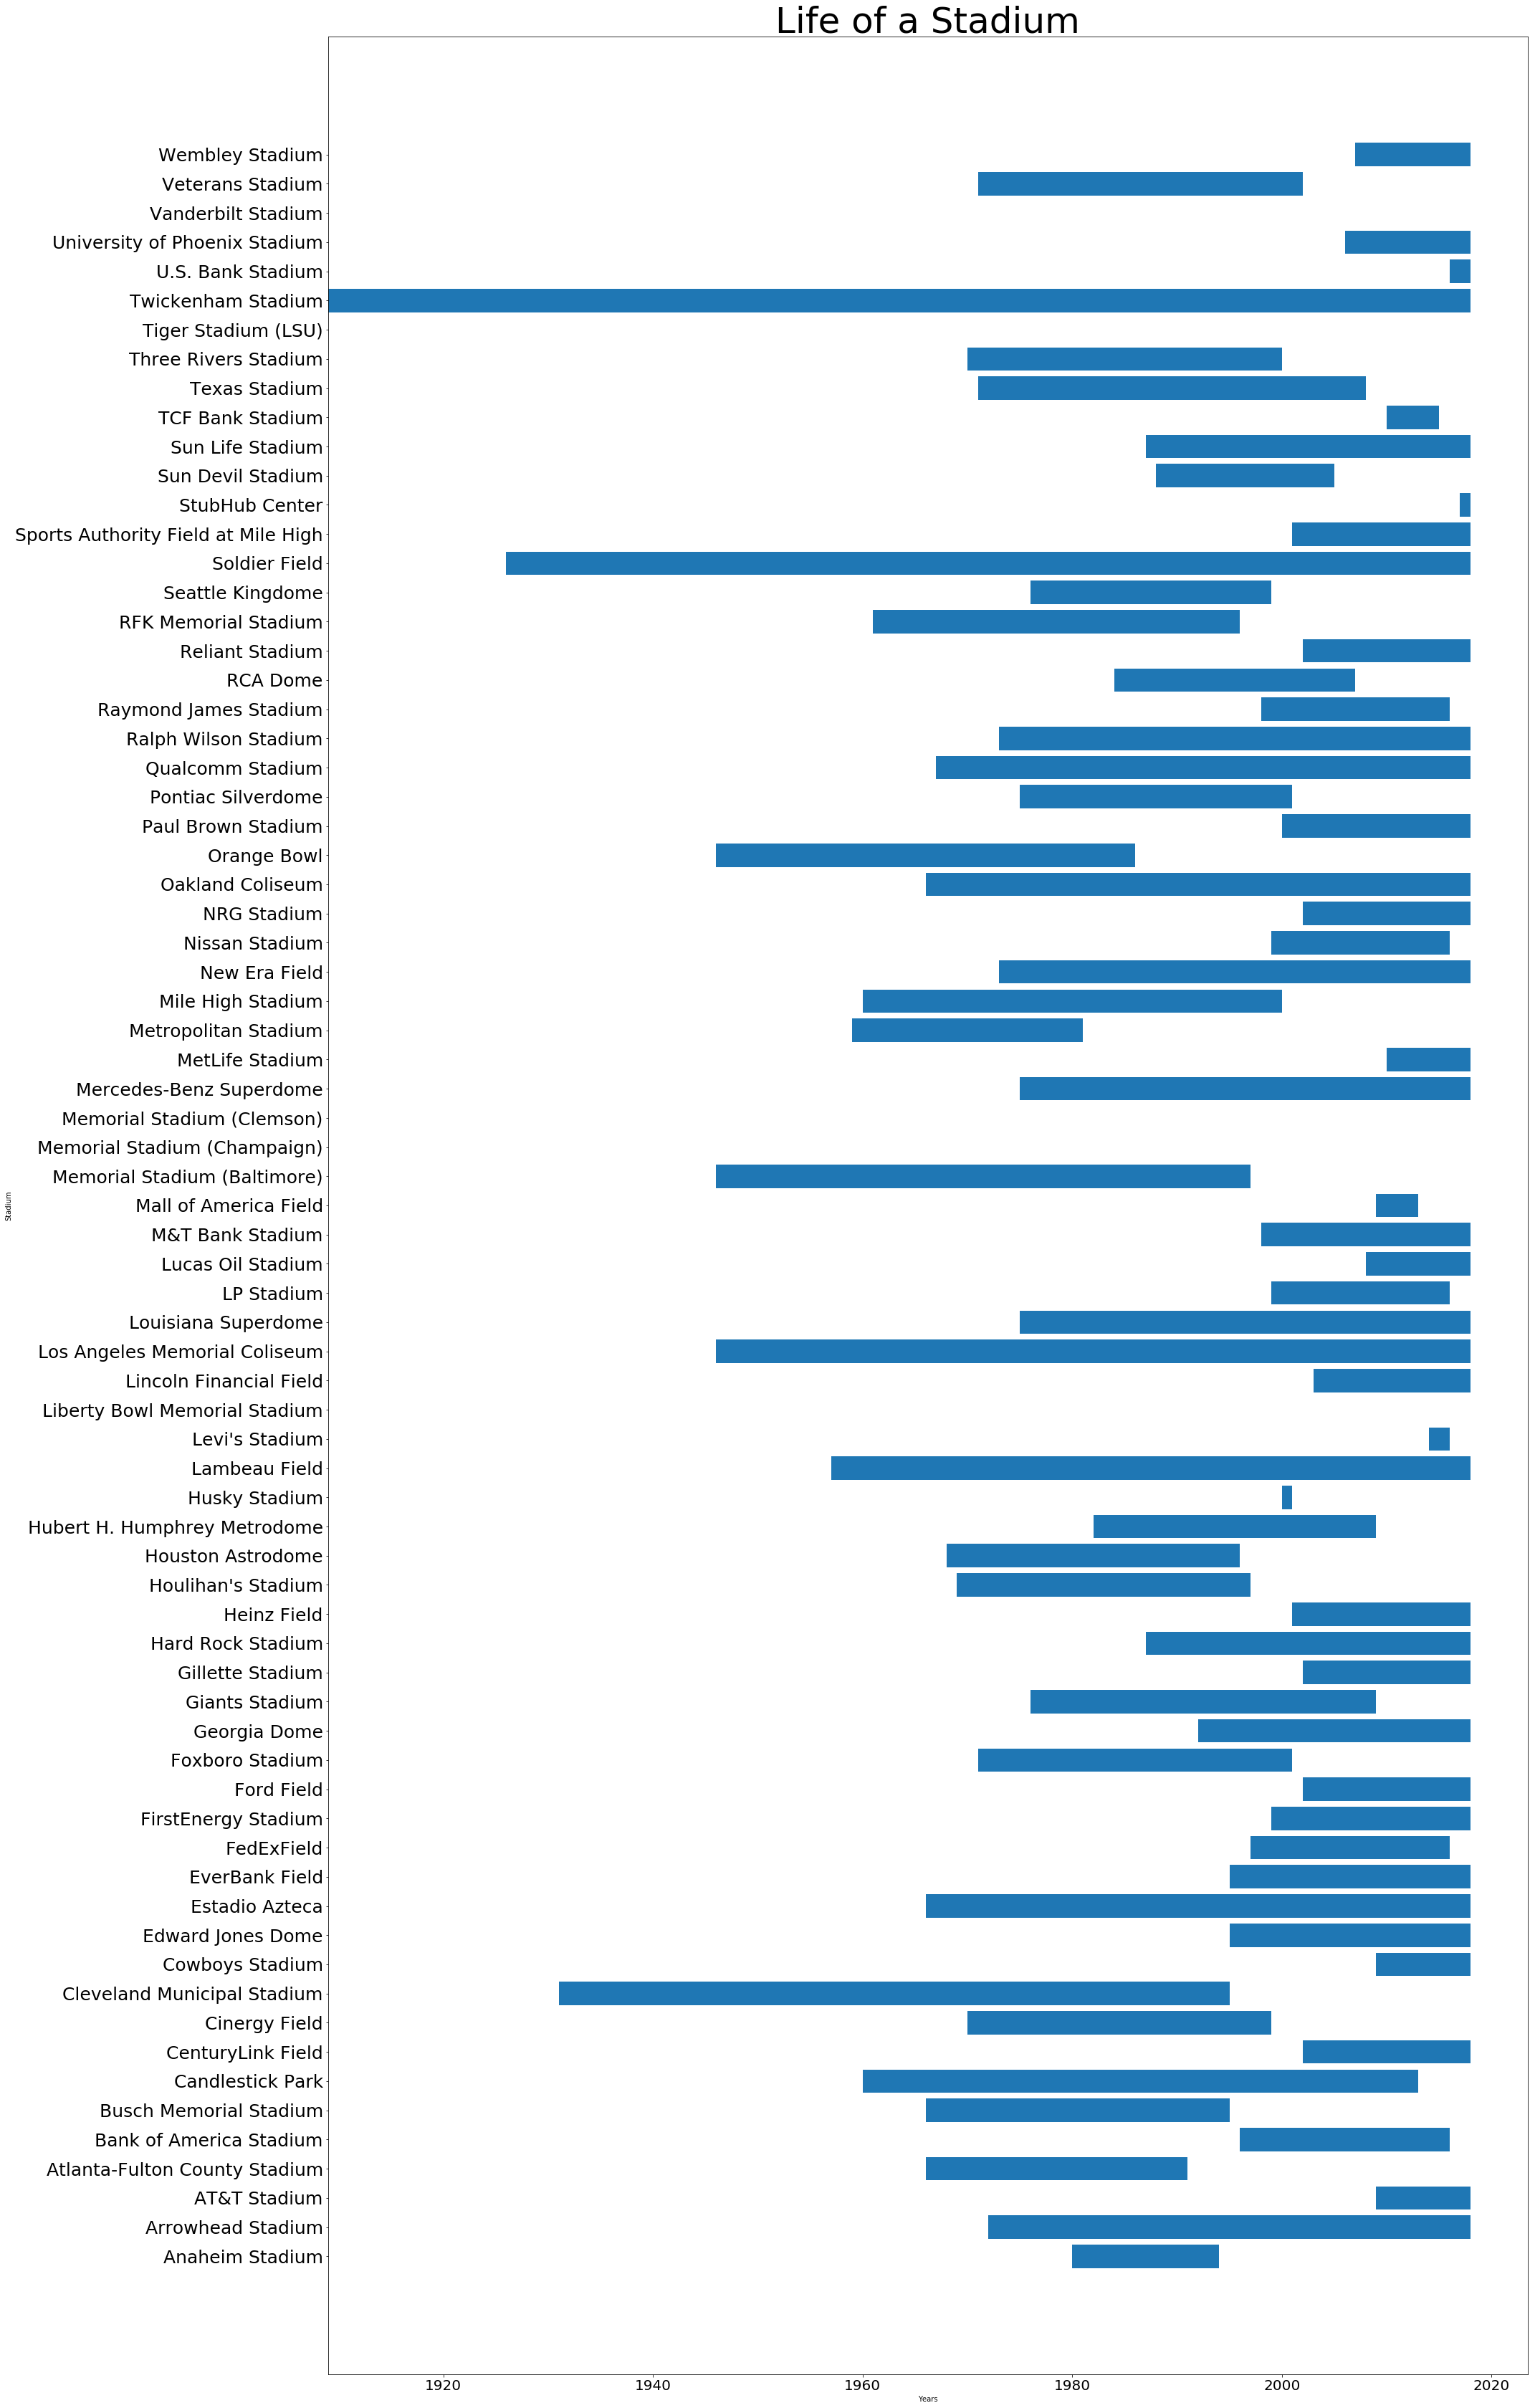

<Figure size 2160x4320 with 0 Axes>

In [50]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
begin = nfl_stadiums.stadium_open.values
end =   nfl_stadiums.stadium_close.values
event = nfl_stadiums.stadium_name.values

plt.barh(range(len(begin)),  end-begin, left=begin)
plt.xticks(fontsize=20)
plt.yticks(range(73), event, fontsize=25)
plt.title("Life of a Stadium", fontsize=50)
plt.xlabel("Years")
plt.ylabel("Stadium")
plt.show()
plt.savefig('LifeofaStadium.png')

In [51]:
print ('Stadium Type -', "Counts")
nfl_stadiums.stadium_weather_type.value_counts()

Stadium Type - Counts


cold        23
dome        18
moderate    18
warm        14
Name: stadium_weather_type, dtype: int64

* Create a visulization of the different stadiums on the map

In [52]:
cl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = nfl_stadiums['LONGITUDE'],
        lat = nfl_stadiums['LATITUDE'],
        text = nfl_stadiums['stadium_name'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            #colorscale = scl,
            cmin = 0,
            #color = 'blue',
            #cmax = df['cnt'].max(),
            #colorbar=dict(
                title="Incoming flightsFebruary 2011"
            )
        )]

layout = dict(
        title = 'Map of all Stadiums in the United States)',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='NFL Stadium' )

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Create additional variables that could help with the analysis

#### Merge the stadium information to the games played

In [53]:
nfl_stadiums_small = nfl_stadiums[['stadium_name', 'stadium_type','ELEVATION']]
nfl_stadiums_small.head()

,stadium_name,stadium_type,ELEVATION
3,Anaheim Stadium,outdoor,0.0
4,Arrowhead Stadium,outdoor,264.9
5,AT&T Stadium,retractable,163.4
6,Atlanta-Fulton County Stadium,outdoor,0.0
8,Bank of America Stadium,outdoor,221.9


In [54]:
nfl_join = nfl_scores.merge(nfl_stadiums_small, how = 'left', left_on = 'stadium', right_on = 'stadium_name')
nfl_join.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral,stadium_name,stadium_type,ELEVATION
0,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,8.0,17.0,7.0,False,Ralph Wilson Stadium,outdoor,178.0
1,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,9.0,12.0,17.0,False,Cinergy Field,outdoor,193.9
2,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,5.0,12.0,6.0,False,Lambeau Field,outdoor,209.4
3,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,10.0,14.0,27.0,False,Arrowhead Stadium,outdoor,264.9
4,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,11.0,20.0,41.0,False,Anaheim Stadium,outdoor,0.0


#### Summarize the weather conditions of a game

In [55]:
conditions = [
    (nfl_join['weather_temperature'] <= 35) & (nfl_join['weather_wind_mph'] >= 15),
    (nfl_join['weather_temperature'] <= 40) & (nfl_join['weather_wind_mph'] >= 10),
    (nfl_join['weather_temperature'] >= 65) & (nfl_join['weather_wind_mph'] <= 5) | (nfl_join['stadium_type']=='indoor')]

choices = ['very poor', 'bad', 'good']

nfl_join['conditions'] = np.select(conditions, choices, default='normal')
nfl_join['conditions'].value_counts()

normal       5941
good         2502
bad           546
very poor     192
Name: conditions, dtype: int64

#### Find the momentum a team has with the average of their points scored/given up over the last 3 games. 

We're building an aggregate team summary of past scores that we'll reference in the larger dataset. First, we have to build the score history. 

In [56]:
all_scores = pd.DataFrame()

all_teams = nfl_join['team_home'].append(nfl_join['team_away'])
unique_teams = list(set(all_teams))

for team in unique_teams: 

    # Pull in all of the scores when the team was the HOME team
    team_home = nfl_join[nfl_join['team_home']==team].groupby(['schedule_season', 'schedule_week'])['score_home', 'score_away'].sum()
    df_home = pd.DataFrame(team_home)
    df_home.reset_index(inplace = True)
    df_home.columns = ['schedule_season','schedule_week','pts_scored','pts_forfeited']

    
    # Pull in all of the scores when the team was the AWAY team
    team_away = nfl_join[nfl_join['team_away']==team].groupby(['schedule_season', 'schedule_week'])['score_away', 'score_home'].sum()
    df_away = pd.DataFrame(team_away)
    df_away.reset_index(inplace = True)
    df_away.columns = ['schedule_season','schedule_week','pts_scored','pts_forfeited']

    # Combine the results into a single dataframe and label the team so we can combine it into the bigger dataframe
    all_team_scores = df_away.append(df_home, sort = True).sort_values(by = ['schedule_season', 'schedule_week'])
    all_team_scores['team'] = [team for i in range(len(all_team_scores))]
    
    # Average the team's points for and points against
    all_team_scores['avg_last_3_for'] = all_team_scores['pts_scored'].rolling(3).mean()
    all_team_scores['avg_last_3_against'] = all_team_scores['pts_forfeited'].rolling(3).mean()
    
    # Combine this team into the bigger dataframe
    if len(all_scores) == 0:
        all_scores = all_team_scores
    else:
        all_scores = all_scores.append(all_team_scores)

all_scores.head(n = 25)

,pts_forfeited,pts_scored,schedule_season,schedule_week,team,avg_last_3_for,avg_last_3_against
0,24.0,23.0,1980,1,ATL,NaN,NaN
1,21.0,37.0,1980,2,ATL,NaN,NaN
0,20.0,17.0,1980,3,ATL,25.666667,21.666667
2,17.0,20.0,1980,4,ATL,24.666667,19.333333
1,28.0,43.0,1980,5,ATL,26.666667,21.666667
2,14.0,7.0,1980,6,ATL,23.333333,19.666667
3,14.0,41.0,1980,7,ATL,30.333333,18.666667
3,10.0,13.0,1980,8,ATL,20.333333,12.666667
4,14.0,30.0,1980,9,ATL,28.000000,12.666667
5,27.0,33.0,1980,10,ATL,25.333333,17.000000


Make sure that each team only has one observation for a given season and week

In [57]:
sanity_check = all_scores.groupby(['schedule_season', 'schedule_week','team']).count()['pts_forfeited']
sanity_check[sanity_check > 1]

Series([], Name: pts_forfeited, dtype: int64)

Good to go! Now, we combine this point information into the main dataframe. First, we'll line up the home team data. 

In [58]:
combined_score_hist = nfl_join.merge(all_scores, how = 'left', 
                      left_on = ['team_home', 'schedule_week', 'schedule_season'], 
                      right_on =['team', 'schedule_week','schedule_season'])

# 1980 Week 3 will be the first week available since we're averaging the last 3 games (even across seasons). 
# Let's view a random week to see how it looks
combined_score_hist[ (combined_score_hist['schedule_week']==4) & (combined_score_hist['schedule_season']==1990) ].head(n = 25)

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,...,stadium_neutral,stadium_name,stadium_type,ELEVATION,conditions,pts_forfeited,pts_scored,team,avg_last_3_for,avg_last_3_against
2129,1990-09-30,1990,4,BUF,DEN,Ralph Wilson Stadium,BUF,-3.0,41.0,58.0,...,False,Ralph Wilson Stadium,outdoor,178.0,normal,28.0,29.0,BUF,22.000000,21.666667
2130,1990-09-30,1990,4,DET,GB,Pontiac Silverdome,DET,-2.5,46.0,72.0,...,False,Pontiac Silverdome,indoor,0.0,good,24.0,21.0,DET,20.666667,20.333333
2131,1990-09-30,1990,4,KC,CLE,Arrowhead Stadium,KC,-6.5,36.0,56.0,...,False,Arrowhead Stadium,outdoor,264.9,normal,0.0,34.0,KC,24.666667,9.000000
2132,1990-09-30,1990,4,OAK,CHI,Los Angeles Memorial Coliseum,OAK,-1.5,34.0,68.0,...,False,Los Angeles Memorial Coliseum,outdoor,29.6,normal,10.0,24.0,OAK,20.333333,8.666667
2133,1990-09-30,1990,4,MIN,TB,Hubert H. Humphrey Metrodome,MIN,-8.0,40.0,72.0,...,False,Hubert H. Humphrey Metrodome,indoor,0.0,good,23.0,20.0,MIN,22.666667,15.000000
2134,1990-09-30,1990,4,NE,NYJ,Foxboro Stadium,PICK,0.0,40.0,67.0,...,False,Foxboro Stadium,outdoor,24.4,normal,37.0,13.0,NE,12.000000,30.666667
2135,1990-09-30,1990,4,NYG,DAL,Giants Stadium,NYG,-13.5,36.0,69.0,...,False,Giants Stadium,outdoor,2.1,normal,17.0,31.0,NYG,26.333333,9.000000
2136,1990-09-30,1990,4,PHI,IND,Veterans Stadium,PHI,-13.0,37.0,69.0,...,False,Veterans Stadium,outdoor,3.0,normal,24.0,23.0,PHI,23.666667,22.666667
2137,1990-09-30,1990,4,ARI,WAS,Sun Devil Stadium,WAS,-6.5,37.0,78.0,...,False,Sun Devil Stadium,outdoor,375.2,normal,38.0,10.0,ARI,13.333333,29.000000
2138,1990-09-30,1990,4,PIT,MIA,Three Rivers Stadium,MIA,-2.0,36.0,62.0,...,False,Three Rivers Stadium,outdoor,366.7,normal,28.0,6.0,PIT,9.666667,19.000000


Rename the columns to properly identify them. 

In [59]:
combined_score_hist=combined_score_hist.rename(columns = {'avg_last_3_for':'home_last3_scored', 
                                                          'avg_last_3_against':'home_last3_forfeited'})
combined_score_hist.drop(['team', 'pts_forfeited','pts_scored'], axis = 1, inplace = True)

In [60]:
combined_score_hist.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral,stadium_name,stadium_type,ELEVATION,conditions,home_last3_scored,home_last3_forfeited
0,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,8.0,17.0,7.0,False,Ralph Wilson Stadium,outdoor,178.0,normal,NaN,NaN
1,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,9.0,12.0,17.0,False,Cinergy Field,outdoor,193.9,normal,NaN,NaN
2,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,5.0,12.0,6.0,False,Lambeau Field,outdoor,209.4,good,NaN,NaN
3,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,10.0,14.0,27.0,False,Arrowhead Stadium,outdoor,264.9,normal,NaN,NaN
4,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,11.0,20.0,41.0,False,Anaheim Stadium,outdoor,0.0,normal,NaN,NaN


Now, we'll line up the **AWAY** team data.

In [61]:
target_col = 'team_away'
combined_score_hist = combined_score_hist.merge(all_scores, how = 'left', 
                      left_on = [target_col, 'schedule_week', 'schedule_season'], 
                      right_on =['team', 'schedule_week','schedule_season'])

combined_score_hist=combined_score_hist.rename(columns = {'avg_last_3_for':'away_last3_scored', 
                                                          'avg_last_3_against':'away_last3_forfeited'})
combined_score_hist.drop(['team', 'pts_forfeited','pts_scored'], axis = 1, inplace = True)


In [62]:
combined_score_hist.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,...,score_away,stadium_neutral,stadium_name,stadium_type,ELEVATION,conditions,home_last3_scored,home_last3_forfeited,away_last3_scored,away_last3_forfeited
0,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,...,7.0,False,Ralph Wilson Stadium,outdoor,178.0,normal,NaN,NaN,NaN,NaN
1,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,...,17.0,False,Cinergy Field,outdoor,193.9,normal,NaN,NaN,NaN,NaN
2,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,...,6.0,False,Lambeau Field,outdoor,209.4,good,NaN,NaN,NaN,NaN
3,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,...,27.0,False,Arrowhead Stadium,outdoor,264.9,normal,NaN,NaN,NaN,NaN
4,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,...,41.0,False,Anaheim Stadium,outdoor,0.0,normal,NaN,NaN,NaN,NaN


### Add a variable for games that will be played at a high elevation stadium 
Dataset describes the height in meters. 

In [63]:
combined_score_hist.groupby(['stadium_name'])['ELEVATION'].mean().sort_values(ascending = False).head(n = 10)

stadium_name
Mile High Stadium                      1611.2
Sports Authority Field at Mile High    1611.2
Sun Devil Stadium                       375.2
University of Phoenix Stadium           375.2
Heinz Field                             366.7
Three Rivers Stadium                    366.7
TCF Bank Stadium                        265.8
Metropolitan Stadium                    265.8
Arrowhead Stadium                       264.9
Cleveland Municipal Stadium             238.0
Name: ELEVATION, dtype: float64

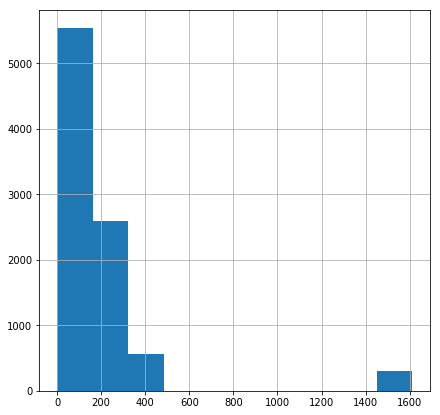

In [64]:
combined_score_hist['ELEVATION'].hist(figsize = (7,7))

Mile high stadium is really the only stadium that is close to affecting breathing levels, so we'll make a column to describe this. 

In [65]:
conditions = [(combined_score_hist['ELEVATION'] >= 1000)]

choices = ['difficult']

combined_score_hist['breathing_cond'] = np.select(conditions, choices, default='normal')
combined_score_hist['breathing_cond'].value_counts()

normal       8875
difficult     306
Name: breathing_cond, dtype: int64

### Add a variable for games that are division games

These games tend to be long dated rivalries as teams play twice a year and only one team from a 4 team division will make it into the post season (excluding the wildcard qualification). Anecdotally, these types of games tend to be closer matchups than one would expect, so it's at least worth flagging these. 

In [66]:
nfl_teams_short = nfl_teams[['team_id', 'team_division', 'team_division_pre2002']]
nfl_teams_short = nfl_teams_short.groupby(['team_id']).ffill().drop_duplicates()
nfl_teams_short['team_id'].value_counts()

OAK    2
ARI    2
IND    2
TEN    2
NO     1
WAS    1
MIN    1
NYG    1
LAC    1
BAL    1
TB     1
DET    1
NYJ    1
BUF    1
HOU    1
CHI    1
CIN    1
PHI    1
DEN    1
LAR    1
PIT    1
SEA    1
DAL    1
CLE    1
NE     1
KC     1
MIA    1
GB     1
JAX    1
CAR    1
SF     1
ATL    1
Name: team_id, dtype: int64

There are some teams that changed divisions multiple times due to the team moving, but our data is only split into the pre-2002 and post-2002 era.

In [67]:
nfl_teams_short

,team_id,team_division,team_division_pre2002
0,ARI,NFC West,NFC West
1,ARI,NFC West,NFC East
3,ATL,NFC South,NFC West
4,BAL,AFC North,AFC Central
5,BUF,AFC East,AFC East
6,CAR,NFC South,NFC West
7,CHI,NFC North,NFC Central
8,CIN,AFC North,AFC Central
9,CLE,AFC North,AFC Central
10,DAL,NFC East,NFC East


This took care of most of the divisions, so we can look them up, but the movement of teams still leaves some outcomes that need to be adjusted (eg. ARI for a team that is no longer around). 

In [68]:
nfl_teams_short.drop([0, 15, 30, 37], inplace = True)

In [69]:
nfl_teams_short.set_index('team_id', inplace = True)
nfl_teams_short

,team_division,team_division_pre2002
team_id,,
ARI,NFC West,NFC East
ATL,NFC South,NFC West
BAL,AFC North,AFC Central
BUF,AFC East,AFC East
CAR,NFC South,NFC West
CHI,NFC North,NFC Central
CIN,AFC North,AFC Central
CLE,AFC North,AFC Central
DAL,NFC East,NFC East


In [70]:
# Simple function to make the list comprehension easier to read
def find_division(df, team, year):
    if int(year) < 2002: 
        div = df.loc[team,'team_division_pre2002']
    else: 
        div = df.loc[team,'team_division']
    return div 

combined_score_hist['home_division'] = [find_division(nfl_teams_short, team, year) for team, year in 
                                        zip(combined_score_hist['team_home'], combined_score_hist['schedule_season'])]


combined_score_hist['away_division'] = [find_division(nfl_teams_short, team, year) for team, year in 
                                        zip(combined_score_hist['team_away'], combined_score_hist['schedule_season'])]


combined_score_hist['rivalry'] = ['Y' if h == a else 'N' for h, a in 
                                  zip(combined_score_hist['home_division'], combined_score_hist['away_division'])]

combined_score_hist['rivalry'].value_counts()

N    5245
Y    3936
Name: rivalry, dtype: int64

In [71]:
# To reduce the size of the dataset, we can eliminate the division names 
combined_score_hist.drop(['home_division', 'away_division', 'stadium_name','stadium','ELEVATION'], axis = 1, inplace = True)

In [72]:
combined_score_hist.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,...,score_away,stadium_neutral,stadium_type,conditions,home_last3_scored,home_last3_forfeited,away_last3_scored,away_last3_forfeited,breathing_cond,rivalry
0,1980-09-07,1980,1,BUF,MIA,MIA,-3.0,35.0,64.0,8.0,...,7.0,False,outdoor,normal,NaN,NaN,NaN,NaN,normal,Y
1,1980-09-07,1980,1,CIN,TB,TB,-1.0,34.0,72.0,9.0,...,17.0,False,outdoor,normal,NaN,NaN,NaN,NaN,normal,N
2,1980-09-07,1980,1,GB,CHI,CHI,-6.0,35.0,65.0,5.0,...,6.0,False,outdoor,good,NaN,NaN,NaN,NaN,normal,Y
3,1980-09-07,1980,1,KC,OAK,KC,-3.0,42.0,82.0,10.0,...,27.0,False,outdoor,normal,NaN,NaN,NaN,NaN,normal,Y
4,1980-09-07,1980,1,LAR,DET,LAR,-9.0,38.0,66.0,11.0,...,41.0,False,outdoor,normal,NaN,NaN,NaN,NaN,normal,N


### Additional Dataset: Elo Ratings from FiveThirtyEight on NFL teams

This will help us get an idea of the relative strengths of teams outside of the scores in recent games. This is a fun description of the methodology where they admit its limitations, but this data supplements what we have available and is worth trying in our model as they consider additional elements like strength of schedule for a team. 

https://fivethirtyeight.com/features/introducing-nfl-elo-ratings/

In [73]:
#nfl_elo_path = 'C:\\Users\\Pete Russell\\Desktop\\I526_AML_FA18\\Final Project\\nfl_elo_test.csv'

nfl_elo = pd.read_csv('../nfl-scores-and-betting-data/nfl_elo.csv')

nfl_elo['date'] = pd.to_datetime(nfl_elo['date'])
nfl_elo.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,score1,score2
0,1920-09-26,1920,0,NaN,RII,STP,1503.947,1300.000,0.824651,0.175349,1516.108,1287.838,48.0,0.0
1,1920-10-03,1920,0,NaN,BFF,WBU,1478.004,1300.000,0.802000,0.198000,1489.757,1288.247,32.0,6.0
2,1920-10-03,1920,0,NaN,CBD,PTQ,1504.688,1300.000,0.825267,0.174733,1516.803,1287.885,48.0,0.0
3,1920-10-03,1920,0,NaN,CHI,MUT,1368.333,1300.000,0.682986,0.317014,1386.533,1281.800,20.0,0.0
4,1920-10-03,1920,0,NaN,RII,MUN,1516.108,1478.004,0.644171,0.355829,1542.135,1451.977,45.0,0.0


Merge this data into our main dataset...

In [74]:
nfl_elo_small = nfl_elo[['date', 'team1', 'team2', 'elo1_pre','elo2_pre']]

elo_merge = combined_score_hist.merge(nfl_elo_small, how = 'left', left_on = ['schedule_date', 'team_home'], right_on = ['date','team1'])
elo_merge.drop(['date','team1', 'team2'], axis = 1, inplace = True)
elo_merge['diff'] = elo_merge['elo1_pre'] - elo_merge['elo2_pre']
elo_merge.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,...,conditions,home_last3_scored,home_last3_forfeited,away_last3_scored,away_last3_forfeited,breathing_cond,rivalry,elo1_pre,elo2_pre,diff
0,1980-09-07,1980,1,BUF,MIA,MIA,-3.0,35.0,64.0,8.0,...,normal,NaN,NaN,NaN,NaN,normal,Y,1465.161,1546.464,-81.303
1,1980-09-07,1980,1,CIN,TB,TB,-1.0,34.0,72.0,9.0,...,normal,NaN,NaN,NaN,NaN,normal,N,1470.732,1460.770,9.962
2,1980-09-07,1980,1,GB,CHI,CHI,-6.0,35.0,65.0,5.0,...,good,NaN,NaN,NaN,NaN,normal,Y,1428.338,1516.573,-88.235
3,1980-09-07,1980,1,KC,OAK,KC,-3.0,42.0,82.0,10.0,...,normal,NaN,NaN,NaN,NaN,normal,Y,1471.194,1546.315,-75.121
4,1980-09-07,1980,1,LAR,DET,LAR,-9.0,38.0,66.0,11.0,...,normal,NaN,NaN,NaN,NaN,normal,N,1536.751,1380.659,156.092


For the Elo ratings, they say each team is benchmarked against 1500, so we would expect the difference between two teams to be hovered around zero, which it appears to be. 

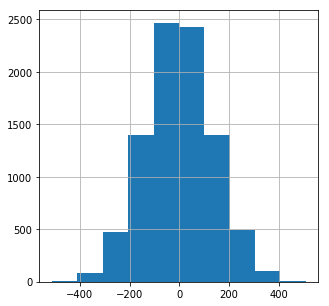

In [75]:
elo_merge['diff'].hist(figsize = (5,5))

#### Dataset is prepped and ready for testing!

# Create Target Variable
**This creates the target variable of what we will be calculating. We are baseing this on the home team and how the differential between the scores is. Also the target will the column favorite beat the spread by. **

In [76]:
#y=nfl_scores["score_home"]-nfl_scores["score_away"]


In [77]:
# Function determines if home or away team is favorite and returns how much the favorite won by
def calc_favorite_won_by (row):
    # Favored team played at home
    if re.search(row['team_favorite_id'], row['team_home'], re.IGNORECASE):
        return row['score_home']-row['score_away']
    else:
        return row['score_away']-row['score_home']

# Function determines if home or away team is favorite and returns how much the favorite beat spread by
def calc_favorite_beat_spread_by (row):
    return row['spread_favorite']+row['favorite_won_by']    
    
# Populate new columns with how much the favorite won by and how much the favorite beat spread by
nfl_scores['favorite_won_by']=nfl_scores.apply(lambda row: calc_favorite_won_by(row),axis=1)
nfl_scores['favorite_beat_spread_by']=nfl_scores.apply(lambda row: calc_favorite_beat_spread_by(row),axis=1)
y=nfl_scores['favorite_beat_spread_by']
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral,favorite_won_by,favorite_beat_spread_by
2734,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,8.0,17.0,7.0,False,-10.0,-13.0
2735,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,9.0,12.0,17.0,False,5.0,4.0
2736,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,5.0,12.0,6.0,False,-6.0,-12.0
2737,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,10.0,14.0,27.0,False,-13.0,-16.0
2738,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,11.0,20.0,41.0,False,-21.0,-30.0


# Machine Learning

In [78]:
X_train, X_other, y_train, y_other=train_test_split(elo_merge,y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val=train_test_split(X_other,y_other, test_size=0.5, random_state=42)

## Numerical and Categorical Pipelines

* Identify Numerical and categorical attributes of the new data set

In [79]:
num_attribs=[ 
        'spread_favorite', 'over_under_line',
       'weather_temperature', 'weather_wind_mph', 'score_home', 'score_away','elo1_pre', 'elo2_pre', 'diff',
        'home_last3_scored','schedule_season','schedule_week',
       'home_last3_forfeited', 'away_last3_scored', 'away_last3_forfeited']
cat_attribs=['team_home', 'team_away','team_favorite_id','stadium_neutral',
            'breathing_cond', 'rivalry','stadium_type']


* Create Pipeline for the numerical features. This pipeline will include a dataframe selector for the numerical attributes  and will also impute the NA values and standardize the data
* Create a pipeline for categorical values that will select the categorical attributes from the dataframe, impute the NA values and also perform OneHotEncoding
* Create a union of the two pipelines

In [80]:
pca = PCA(n_components=40)
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
pca_pipe = Pipeline([
    ("preparation", full_pipeline),
    ("pca",pca)
])

## Dummy Regressor

This is the baseline where all testing will be done against

In [81]:
model = DummyRegressor(strategy='mean')
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=42)
baseline_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
baseline_train_score = np.sqrt(-baseline_scores.mean())

start = time.time()
model.fit(X_train, y_train)
baseline_train_predict = model.fit(X_train, y_train)
train_time_bs = np.round(time.time()-start,3)

start = time.time()
baseline_test_predict = model.predict(X_val)
baseline_test_score = np.sqrt(mean_squared_error(y_val, baseline_test_predict))
test_time = np.round(time.time()-start,3)

results = pd.DataFrame(columns=["ExpID", "Test Error", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

results.loc[0] = ['Baseline', baseline_test_score, "--", train_time_bs, test_time, "--"]

## XGBoost Regressor with PCA

In [97]:
x_train = pca_pipe.fit_transform(X_train)
x_test = pca_pipe.fit_transform(X_test)

data_matrix = xgb.DMatrix(x_train,y_train.values)
start = time.time()
xg_reg = xgb.XGBRegressor(objective ='reg:linear',booster='dart',colsample_bytree = 0.2, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50)
xg_reg.fit(x_train,y_train)
train_time = np.round(time.time()-start,2)

start = time.time()
preds = xg_reg.predict(x_test)
test_time = np.round(time.time()-start,2)

In [98]:
params = {"objective":"reg:linear",'colsample_bytree': 0.5,'learning_rate': 0.1,
                'max_depth': 5, 'lambda': 10}

In [99]:
cv_results = xgb.cv(dtrain=data_matrix, params=params, nfold=10,
                    num_boost_round=50,early_stopping_rounds=10,metrics=["rmse"], as_pandas=True, seed=42)

[10:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[10:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[10:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[10:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[10:23:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[10:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[10:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[10:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[10:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[10:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[10:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[10:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[10:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[10:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[10:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[10:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[10:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[10:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[10:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[10:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

In [100]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,12.908685,0.029183,12.949989,0.243247
1,12.669379,0.142358,12.744247,0.261561
2,12.407451,0.202476,12.514909,0.250781
3,12.138560,0.278725,12.265873,0.357738
4,11.976985,0.351411,12.141647,0.409547
5,11.746778,0.325120,11.957017,0.391500
6,11.592789,0.373245,11.837114,0.442729
7,11.418987,0.291909,11.704083,0.373022
8,11.272310,0.262651,11.594060,0.334041
9,11.119207,0.282661,11.472824,0.354087


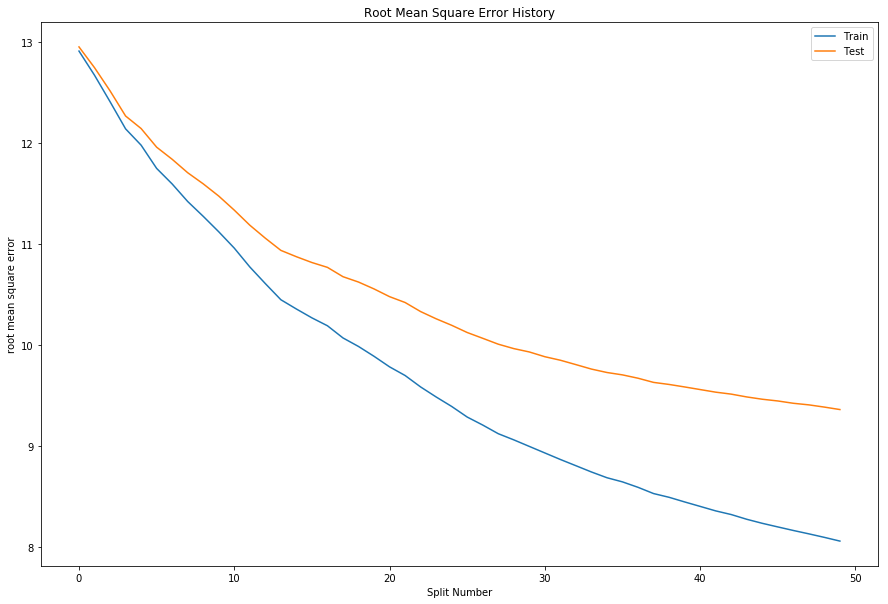

In [101]:
plt.figure(figsize=(15, 10))
plt.plot(cv_results["train-rmse-mean"], label="Train")
plt.plot(cv_results["test-rmse-mean"], label="Test")
plt.ylabel('root mean square error')
plt.xlabel("Split Number")
plt.title("Root Mean Square Error History")
plt.legend();


In [102]:
cv_results.tail(1)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
49,8.056275,0.072211,9.358851,0.412102


In [103]:
frame  = np.round(pd.DataFrame(cv_results.mean()).T,2)
frame

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.71,0.18,10.47,0.41


In [104]:
train_rmse_mean = float(frame["train-rmse-mean"])
train_rmse_std = float(frame["train-rmse-std"])

test_rmse_mean = float(frame["test-rmse-mean"])
test_rmse_std = float(frame["test-rmse-std"])

In [105]:
xg_reg = xgb.train(params=params, dtrain=data_matrix, num_boost_round=10)

[10:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[10:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[10:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

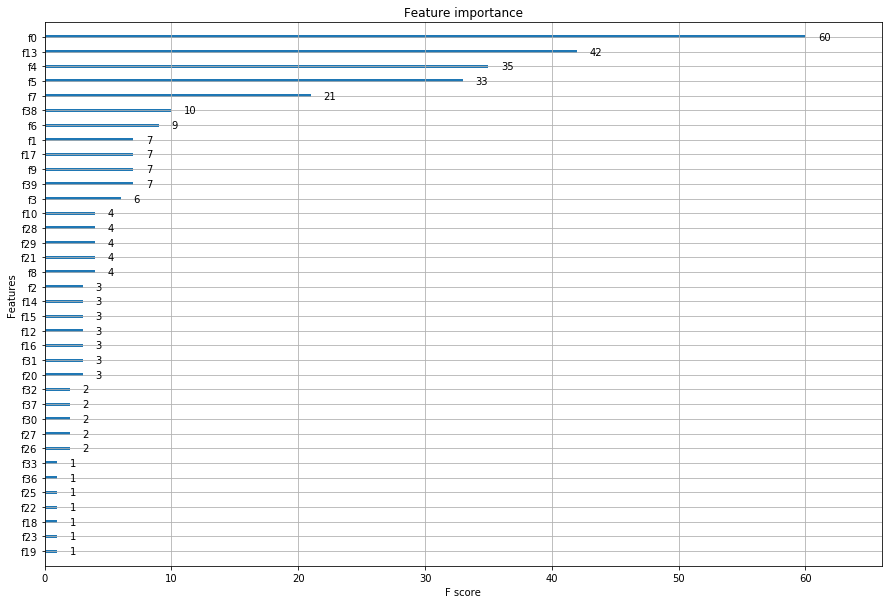

In [106]:
xgb.plot_importance(xg_reg,height=0.2)
plt.rcParams['figure.figsize'] = [15, 10]

The encoded dataset contains 179 variables which is fairly large dimension. The data can be projected to a lower projection but maintain the inherent characteristics and relationships in the data. One popular technique is Principal Component Analysis which we use in the project. Dimensionality reduction fastened computation time and also helps takes care of multi-collinearity that improved performance. The plot above shows the forty features that were selected based on importance (F-scores) after principal component analysis was applied.

In [107]:
results.loc[len(results)]=["XGBoostRegressor", test_rmse_mean, "--", train_time, test_time, "Non-Optimized XGBoost"]

In [93]:
results

,ExpID,Test Error,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,13.288037,--,0.00,0.0,--
1,XGBoostRegressor,10.470000,--,0.52,0.0,Non-Optimized XGBoost


In [94]:
# A Function to execute the grid search and record the results.
fit_params = {"eval_set": [(X_test, y_test)], 
              "early_stopping_rounds": 10, 
              "verbose": False} 
def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix=''):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Linear Regression', LinearRegression(n_jobs=-1)),
        ('K-Nearest Neighbors', KNeighborsRegressor()),
        #('Logistic Regression', LogisticRegression()),
        ('Stochastic GD', SGDRegressor(max_iter=1500)),
        ('RandomForest', RandomForestRegressor()),
        ('XGBoost', XGBRegressor(fit_params=fit_params,objective ='reg:linear'))
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Linear Regression': {
            'normalize': (True, False)
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (1,5,7, 8, 11,13,15,17,20,22),
            'weights':('distance','uniform'),
            'p': (1,2),
        },
        #'Logistic Regression' : {
         #   'penalty': ('l1', 'l2'),     
          #  'C': (10, 1, 0.1, 0.01,.001),
        #,
        'XGBoost':{
            "n_estimators": [10, 50, 100, 500],
            "learning_rate": [0.1,0.01,0.001],
            'max_depth': [3,5, 6],
            'booster': ('dart',"gblinear")
        },
        'Stochastic GD': {
            'loss': ('squared_loss', 'huber', 'squared_epsilon_insensitive'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [1,3,5,6,9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", pca_pipe),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
        grid_search = GridSearchCV(full_pipeline_with_predictor,params, scoring='neg_mean_squared_error',cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time.time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time.time() - start, 4)

        # Best estimator prediction time
        start = time.time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time.time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
        best_train_accuracy = (best_train_scores.mean())

        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(baseline_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, np.sqrt(best_test_accuracy), round(p_value,3), train_time, test_time, json.dumps(param_dump)]

## GridSearchCV

In [95]:
#results = pd.DataFrame(columns=["ExpID", "Train Accuracy (Mean)", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:")

****** START Best Model: Linear Regression *****
Parameters:
	normalize: (True, False)
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


Best Parameters:
	predictor__normalize: True
****** FINISH Best Model: Linear Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (1, 5, 7, 8, 11, 13, 15, 17, 20, 22)
	p: (1, 2)
	weights: ('distance', 'uniform')
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  6.5min finished


Best Parameters:
	predictor__n_neighbors: 17
	predictor__p: 2
	predictor__weights: distance
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	loss: ('squared_loss', 'huber', 'squared_epsilon_insensitive')
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_m

Best Parameters:
	predictor__alpha: 0.1
	predictor__loss: squared_loss
	predictor__penalty: l1
	predictor__tol: 1e-07
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	max_depth: [1, 3, 5, 6, 9, 15, 22, 26, 30]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6075 out of 6075 | elapsed: 153.7min finished


Best Parameters:
	predictor__max_depth: 30
	predictor__max_features: 5
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 5
	predictor__n_estimators: 150
****** FINISH Best Model: RandomForest  *****

****** START Best Model: XGBoost *****
Parameters:
	booster: ('dart', 'gblinear')
	learning_rate: [0.1, 0.01, 0.001]
	max_depth: [3, 5, 6]
	n_estimators: [10, 50, 100, 500]
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 28.9min finished


Best Parameters:
	predictor__booster: dart
	predictor__learning_rate: 0.1
	predictor__max_depth: 6
	predictor__n_estimators: 500
****** FINISH Best Model: XGBoost  *****



In [108]:
results

,ExpID,Test Error,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,13.288037,--,0.0000,0.0000,--
1,Best Model:Linear Regression,3.605551,0,0.1261,0.0047,"[[""predictor__normalize"", true]]"
2,Best Model:K-Nearest Neighbors,6.826419,0,0.1169,0.2688,"[[""predictor__n_neighbors"", 17], [""predictor__..."
3,Best Model:Stochastic GD,3.478505,0,0.1432,0.0045,"[[""predictor__alpha"", 0.1], [""predictor__loss""..."
4,Best Model:RandomForest,6.663332,0,3.7113,0.0286,"[[""predictor__max_depth"", 30], [""predictor__ma..."
5,Best Model:XGBoost,7.694154,0,64.4213,0.0312,"[[""predictor__booster"", ""dart""], [""predictor__..."
6,XGBoostRegressor,10.470000,--,0.5800,0.0000,Non-Optimized XGBoost


# Artificial Neural Networks With Keras

In [109]:
from keras import backend as K

# This function will be used to create the scoring metric for the keras regressor
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [110]:
# Create a transformed array of values from the preparation pipelines
ann_train = pca_pipe.fit_transform(X_train)
ann_test = pca_pipe.fit_transform(X_test)

In [125]:
model = Sequential()
model.add(Dense(40,activation='relu',input_dim=40, kernel_initializer='normal',kernel_regularizer=regularizers.L1L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(41,activation='tanh',kernel_initializer='normal',kernel_regularizer=regularizers.L1L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))
model.add(Dropout(0.2))
model.compile(loss=rmse,optimizer='SGD', metrics=[rmse])

In [126]:
%%time
start = time.time()
history = model.fit(ann_train, y_train.values,validation_data=(ann_test, y_test.values), epochs=100, 
                    batch_size=60, 
                    verbose=1)
train_time = np.round(time.time()-start,2)

Train on 7344 samples, validate on 918 samples
Epoch 1/100
7344/7344 [==============================] - 0s 48us/step - loss: 14.4676 - rmse: 13.3503 - val_loss: 14.0618 - val_rmse: 13.1215
Epoch 2/100
7344/7344 [==============================] - 0s 15us/step - loss: 14.1394 - rmse: 13.3459 - val_loss: 13.7758 - val_rmse: 13.1207
Epoch 3/100
7344/7344 [==============================] - 0s 15us/step - loss: 13.8909 - rmse: 13.3482 - val_loss: 13.5593 - val_rmse: 13.1209
Epoch 4/100
7344/7344 [==============================] - 0s 14us/step - loss: 13.7175 - rmse: 13.3606 - val_loss: 13.4039 - val_rmse: 13.1211
Epoch 5/100
7344/7344 [==============================] - 0s 15us/step - loss: 13.5758 - rmse: 13.3490 - val_loss: 13.2977 - val_rmse: 13.1216
Epoch 6/100
7344/7344 [==============================] - 0s 17us/step - loss: 13.4906 - rmse: 13.3525 - val_loss: 13.2260 - val_rmse: 13.1218
Epoch 7/100
7344/7344 [==============================] - 0s 15us/step - loss: 13.4400 - rmse: 13.3610

7344/7344 [==============================] - 0s 15us/step - loss: 13.3605 - rmse: 13.3588 - val_loss: 13.1234 - val_rmse: 13.1217
Epoch 59/100
7344/7344 [==============================] - 0s 15us/step - loss: 13.3582 - rmse: 13.3565 - val_loss: 13.1234 - val_rmse: 13.1218
Epoch 60/100
7344/7344 [==============================] - 0s 15us/step - loss: 13.3527 - rmse: 13.3511 - val_loss: 13.1234 - val_rmse: 13.1218
Epoch 61/100
7344/7344 [==============================] - 0s 15us/step - loss: 13.3537 - rmse: 13.3520 - val_loss: 13.1232 - val_rmse: 13.1216
Epoch 62/100
7344/7344 [==============================] - 0s 15us/step - loss: 13.3652 - rmse: 13.3636 - val_loss: 13.1233 - val_rmse: 13.1217
Epoch 63/100
7344/7344 [==============================] - 0s 16us/step - loss: 13.3435 - rmse: 13.3419 - val_loss: 13.1233 - val_rmse: 13.1217
Epoch 64/100
7344/7344 [==============================] - 0s 15us/step - loss: 13.3471 - rmse: 13.3455 - val_loss: 13.1236 - val_rmse: 13.1220
Epoch 65/100

In [127]:
start = time.time()
model.predict(ann_test)
test_time = np.round(time.time()-start,2)

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 40)                1640      
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 41)                1681      
_________________________________________________________________
dropout_5 (Dropout)          (None, 41)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 42        
_________________________________________________________________
dropout_6 (Dropout)          (None, 1)                 0         
Total params: 3,363
Trainable params: 3,363
Non-trainable params: 0
_________________________________________________________________


In [129]:
history.history.keys()

dict_keys(['val_loss', 'val_rmse', 'loss', 'rmse'])

In [130]:
train_rmse_mean = np.round(np.mean(history.history["rmse"]),2)
train_rmse_std = np.round(np.std(history.history["rmse"]),2)

test_rmse_mean = np.round(np.mean(history.history["val_loss"]),2)
test_rmse_std = np.round(np.std(history.history["val_loss"]),2)
ann_base_score = train_rmse_mean

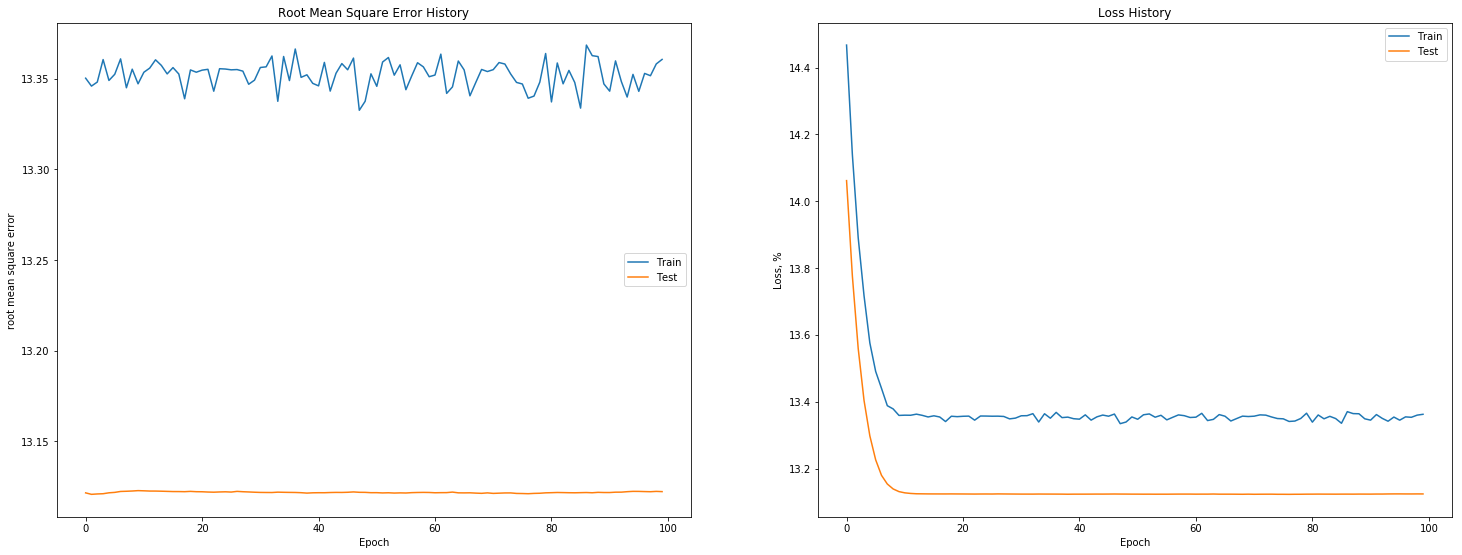

In [131]:
plt.figure(figsize=(25, 20))

plt.subplot(221)
plt.plot(history.history["rmse"], label="Train")
plt.plot(history.history['val_rmse'], label="Test")
plt.ylabel('root mean square error')
plt.xlabel("Epoch")
plt.title("Root Mean Square Error History")
plt.legend();

plt.subplot(222)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Test")
plt.ylabel("Loss, %")
plt.xlabel("Epoch")
plt.title("Loss History")
plt.legend()


This plot shows slight variance between the train scores and the test scores. This could indicates a slight case of underfitting where the training data is performing poorly. Crossvalidation of the dataset would provide a evaluation of the variance

***Create results table ***

In [132]:
results.loc[len(results)]=["ANN Linear Regressor", test_rmse_mean, "--", train_time, test_time,"Non-Optimized ANN"]

In [133]:
results

,ExpID,Test Error,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,13.288037,--,0.0000,0.0000,--
1,Best Model:Linear Regression,3.605551,0,0.1261,0.0047,"[[""predictor__normalize"", true]]"
2,Best Model:K-Nearest Neighbors,6.826419,0,0.1169,0.2688,"[[""predictor__n_neighbors"", 17], [""predictor__..."
3,Best Model:Stochastic GD,3.478505,0,0.1432,0.0045,"[[""predictor__alpha"", 0.1], [""predictor__loss""..."
4,Best Model:RandomForest,6.663332,0,3.7113,0.0286,"[[""predictor__max_depth"", 30], [""predictor__ma..."
5,Best Model:XGBoost,7.694154,0,64.4213,0.0312,"[[""predictor__booster"", ""dart""], [""predictor__..."
6,XGBoostRegressor,10.470000,--,0.5800,0.0000,Non-Optimized XGBoost
7,ANN Linear Regressor,13.150000,--,12.1000,0.0500,Non-Optimized ANN


## ANN Optimization with GridSearchCV

In [151]:
def create_model(kernel_initializer='uniform',optimizer="SGD"):
    model = Sequential()
    model.add(Dense(40,input_dim=40,activation='relu',kernel_initializer=kernel_initializer,kernel_regularizer=regularizers.L1L2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(41,activation='tanh',kernel_initializer=kernel_initializer,kernel_regularizer=regularizers.L1L2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer=kernel_initializer,activation='linear'))
    model.add(Dropout(0.2))
    model.compile(loss=rmse,optimizer=optimizer, metrics=[rmse])
    return model

In [152]:
def run_GridSearch(X_train, y_train, pipeline, param_grid):     
    grid = GridSearchCV(pipeline, cv=5, param_grid=param_grid)
    grid.fit(X_train, y_train)
    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    train_means = np.round(grid.cv_results_['mean_train_score'].mean()) 
    train_stds = np.round(grid.cv_results_['std_train_score'].mean())
    train_time = np.round(grid.cv_results_['mean_fit_time'].mean())

    
    test_means = np.round(grid.cv_results_['mean_test_score'].mean())
    test_stds = np.round(grid.cv_results_['std_test_score'].mean())
    test_time = np.round(grid.cv_results_['mean_score_time'].mean())
    
    params = grid.best_params_
    return train_means, train_stds,test_time,test_means, test_stds, test_time,params

In [153]:
param_grid = {
    'keras__batch_size': [20,50,70,90],
    'keras__epochs':[20,30,50,60],
    'keras__kernel_initializer':['uniform','normal'],
    'keras__optimizer':['rmsprop','adam',]
}

# wrap the model using the function we created
clf = KerasRegressor(build_fn=create_model,verbose=1)
    
full_pipeline_with_keras = Pipeline([
    ('pca_pipe',pca_pipe),
    ("keras", clf)
])
    
if __name__ == '__main__':
    train_means, train_stds,test_time,test_means, test_stds, test_time,params = run_GridSearch(X_train, y_train.values, full_pipeline_with_keras, param_grid)

Epoch 1/20
5875/5875 [==============================] - 2s 296us/step - loss: 13.3359 - rmse: 13.2902
Epoch 2/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.3193 - rmse: 13.3033
Epoch 3/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.3442 - rmse: 13.3282
Epoch 4/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.3254 - rmse: 13.3094
Epoch 5/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.3307 - rmse: 13.3146
Epoch 6/20
5875/5875 [==============================] - 0s 57us/step - loss: 13.3093 - rmse: 13.2932
Epoch 7/20
5875/5875 [==============================] - 0s 57us/step - loss: 13.3410 - rmse: 13.3249
Epoch 8/20
5875/5875 [==============================] - 0s 57us/step - loss: 13.3312 - rmse: 13.3151
Epoch 9/20
5875/5875 [==============================] - 0s 57us/step - loss: 13.3155 - rmse: 13.2994
Epoch 10/20
5875/5875 [==============================] - 0s 58us/step - loss: 13.3386 - rm

5875/5875 [==============================] - 0s 57us/step - loss: 13.1176 - rmse: 13.1014
Epoch 19/20
5875/5875 [==============================] - 0s 57us/step - loss: 13.1165 - rmse: 13.1003
Epoch 20/20
5875/5875 [==============================] - 0s 31us/step
Epoch 1/20
5876/5876 [==============================] - 2s 313us/step - loss: 13.2645 - rmse: 13.2185
Epoch 2/20
5876/5876 [==============================] - 0s 57us/step - loss: 13.2583 - rmse: 13.2422
Epoch 3/20
5876/5876 [==============================] - 0s 57us/step - loss: 13.2501 - rmse: 13.2341
Epoch 4/20
5876/5876 [==============================] - 0s 57us/step - loss: 13.2642 - rmse: 13.2481
Epoch 5/20
5876/5876 [==============================] - 0s 57us/step - loss: 13.2770 - rmse: 13.2610
Epoch 6/20
5876/5876 [==============================] - 0s 57us/step - loss: 13.2330 - rmse: 13.2169
Epoch 7/20
5876/5876 [==============================] - 0s 57us/step - loss: 13.2739 - rmse: 13.2578
Epoch 8/20
5876/5876 [========

5875/5875 [==============================] - 0s 63us/step - loss: 13.1762 - rmse: 13.1724
Epoch 15/20
5875/5875 [==============================] - 0s 64us/step - loss: 13.1646 - rmse: 13.1607
Epoch 16/20
5875/5875 [==============================] - 0s 63us/step - loss: 13.1869 - rmse: 13.1831
Epoch 17/20
5875/5875 [==============================] - 0s 63us/step - loss: 13.1697 - rmse: 13.1658
Epoch 18/20
5875/5875 [==============================] - 0s 63us/step - loss: 13.1833 - rmse: 13.1794
Epoch 19/20
5875/5875 [==============================] - 0s 64us/step - loss: 13.1606 - rmse: 13.1568
Epoch 20/20
5875/5875 [==============================] - 0s 33us/step
Epoch 1/20
5875/5875 [==============================] - 2s 358us/step - loss: 13.1722 - rmse: 13.1187
Epoch 2/20
5875/5875 [==============================] - 0s 65us/step - loss: 13.1124 - rmse: 13.1085
Epoch 3/20
5875/5875 [==============================] - 0s 64us/step - loss: 13.1042 - rmse: 13.1003
Epoch 4/20
5875/5875 [====

5875/5875 [==============================] - 0s 60us/step - loss: 13.3590 - rmse: 13.3428
Epoch 11/20
5875/5875 [==============================] - 0s 60us/step - loss: 13.3667 - rmse: 13.3505
Epoch 12/20
5875/5875 [==============================] - 0s 60us/step - loss: 13.3667 - rmse: 13.3504
Epoch 13/20
5875/5875 [==============================] - 0s 60us/step - loss: 13.3772 - rmse: 13.3610
Epoch 14/20
5875/5875 [==============================] - 0s 60us/step - loss: 13.3411 - rmse: 13.3249
Epoch 15/20
5875/5875 [==============================] - 0s 61us/step - loss: 13.3474 - rmse: 13.3312
Epoch 16/20
5875/5875 [==============================] - 0s 60us/step - loss: 13.3576 - rmse: 13.3414
Epoch 17/20
5875/5875 [==============================] - 0s 60us/step - loss: 13.3739 - rmse: 13.3577
Epoch 18/20
5875/5875 [==============================] - 0s 60us/step - loss: 13.3463 - rmse: 13.3301
Epoch 19/20
5875/5875 [==============================] - 0s 60us/step - loss: 13.3485 - rmse: 

5875/5875 [==============================] - 0s 67us/step - loss: 13.3243 - rmse: 13.3205
Epoch 7/20
5875/5875 [==============================] - 0s 66us/step - loss: 13.3253 - rmse: 13.3216
Epoch 8/20
5875/5875 [==============================] - 0s 67us/step - loss: 13.3132 - rmse: 13.3094
Epoch 9/20
5875/5875 [==============================] - 0s 67us/step - loss: 13.2980 - rmse: 13.2943
Epoch 10/20
5875/5875 [==============================] - 0s 66us/step - loss: 13.3006 - rmse: 13.2968
Epoch 11/20
5875/5875 [==============================] - 0s 66us/step - loss: 13.3284 - rmse: 13.3246
Epoch 12/20
5875/5875 [==============================] - 0s 67us/step - loss: 13.3135 - rmse: 13.3098
Epoch 13/20
5875/5875 [==============================] - 0s 66us/step - loss: 13.3370 - rmse: 13.3333
Epoch 14/20
5875/5875 [==============================] - 0s 67us/step - loss: 13.3101 - rmse: 13.3064
Epoch 15/20
5875/5875 [==============================] - 0s 66us/step - loss: 13.2897 - rmse: 13.

5876/5876 [==============================] - 0s 69us/step - loss: 13.2436 - rmse: 13.2398
Epoch 3/20
5876/5876 [==============================] - 0s 69us/step - loss: 13.2163 - rmse: 13.2124
Epoch 4/20
5876/5876 [==============================] - 0s 69us/step - loss: 13.2356 - rmse: 13.2318
Epoch 5/20
5876/5876 [==============================] - 0s 69us/step - loss: 13.2457 - rmse: 13.2419
Epoch 6/20
5876/5876 [==============================] - 0s 69us/step - loss: 13.2297 - rmse: 13.2259
Epoch 7/20
5876/5876 [==============================] - 0s 69us/step - loss: 13.2464 - rmse: 13.2426
Epoch 8/20
5876/5876 [==============================] - 0s 69us/step - loss: 13.2316 - rmse: 13.2278
Epoch 9/20
5876/5876 [==============================] - 0s 69us/step - loss: 13.2369 - rmse: 13.2331
Epoch 10/20
5876/5876 [==============================] - 0s 69us/step - loss: 13.2345 - rmse: 13.2307
Epoch 11/20
5876/5876 [==============================] - 0s 70us/step - loss: 13.2421 - rmse: 13.2383

5875/5875 [==============================] - 0s 38us/step
Epoch 1/30
5875/5875 [==============================] - 3s 434us/step - loss: 13.2109 - rmse: 13.1650
Epoch 2/30
5875/5875 [==============================] - 0s 66us/step - loss: 13.1614 - rmse: 13.1454
Epoch 3/30
5875/5875 [==============================] - 0s 65us/step - loss: 13.1986 - rmse: 13.1826
Epoch 4/30
5875/5875 [==============================] - 0s 65us/step - loss: 13.1613 - rmse: 13.1453
Epoch 5/30
5875/5875 [==============================] - 0s 65us/step - loss: 13.1726 - rmse: 13.1566
Epoch 6/30
5875/5875 [==============================] - 0s 64us/step - loss: 13.1787 - rmse: 13.1627
Epoch 7/30
5875/5875 [==============================] - 0s 65us/step - loss: 13.1558 - rmse: 13.1397
Epoch 8/30
5875/5875 [==============================] - 0s 65us/step - loss: 13.1526 - rmse: 13.1366
Epoch 9/30
5875/5875 [==============================] - 0s 65us/step - loss: 13.1768 - rmse: 13.1608
Epoch 10/30
5875/5875 [=========

5876/5876 [==============================] - 2s 320us/step - loss: 13.2776 - rmse: 13.2616
Epoch 18/30
5876/5876 [==============================] - 2s 319us/step - loss: 13.2613 - rmse: 13.2453
Epoch 19/30
5876/5876 [==============================] - 2s 319us/step - loss: 13.2638 - rmse: 13.2478
Epoch 20/30
5876/5876 [==============================] - 2s 316us/step - loss: 13.2704 - rmse: 13.2544
Epoch 21/30
5876/5876 [==============================] - 2s 317us/step - loss: 13.2640 - rmse: 13.2479
Epoch 22/30
5876/5876 [==============================] - 2s 322us/step - loss: 13.2723 - rmse: 13.2562
Epoch 23/30
5876/5876 [==============================] - 2s 319us/step - loss: 13.2382 - rmse: 13.2221
Epoch 24/30
5876/5876 [==============================] - 2s 320us/step - loss: 13.2680 - rmse: 13.2519
Epoch 25/30
5876/5876 [==============================] - 2s 316us/step - loss: 13.2520 - rmse: 13.2360
Epoch 26/30
5876/5876 [==============================] - 2s 322us/step - loss: 13.247

5875/5875 [==============================] - 2s 354us/step - loss: 13.1727 - rmse: 13.1688
Epoch 4/30
5875/5875 [==============================] - 2s 354us/step - loss: 13.1750 - rmse: 13.1712
Epoch 5/30
5875/5875 [==============================] - 2s 354us/step - loss: 13.1507 - rmse: 13.1469
Epoch 6/30
5875/5875 [==============================] - 2s 358us/step - loss: 13.1703 - rmse: 13.1665
Epoch 7/30
5875/5875 [==============================] - 2s 354us/step - loss: 13.1704 - rmse: 13.1666
Epoch 8/30
5875/5875 [==============================] - 2s 351us/step - loss: 13.1512 - rmse: 13.1474
Epoch 9/30
5875/5875 [==============================] - 2s 348us/step - loss: 13.1630 - rmse: 13.1592
Epoch 10/30
5875/5875 [==============================] - 1761s 300ms/step - loss: 13.1762 - rmse: 13.1724
Epoch 11/30
5875/5875 [==============================] - 1s 134us/step - loss: 13.1516 - rmse: 13.1478
Epoch 12/30
5875/5875 [==============================] - 0s 82us/step - loss: 13.1567 - 

5876/5876 [==============================] - 1s 132us/step - loss: 13.2293 - rmse: 13.2254
Epoch 21/30
5876/5876 [==============================] - 1s 104us/step - loss: 13.2313 - rmse: 13.2274
Epoch 22/30
5876/5876 [==============================] - 0s 83us/step - loss: 13.2397 - rmse: 13.2358
Epoch 23/30
5876/5876 [==============================] - 0s 75us/step - loss: 13.2208 - rmse: 13.2169
Epoch 24/30
5876/5876 [==============================] - 1s 98us/step - loss: 13.2497 - rmse: 13.2458
Epoch 25/30
5876/5876 [==============================] - 1s 129us/step - loss: 13.2544 - rmse: 13.2506
Epoch 26/30
5876/5876 [==============================] - 1s 93us/step - loss: 13.2472 - rmse: 13.2433
Epoch 27/30
5876/5876 [==============================] - 0s 77us/step - loss: 13.2488 - rmse: 13.2449
Epoch 28/30
5876/5876 [==============================] - 1s 129us/step - loss: 13.2442 - rmse: 13.2404
Epoch 29/30
5876/5876 [==============================] - 1s 96us/step - loss: 13.2318 - rm

5875/5875 [==============================] - 1s 129us/step - loss: 13.1610 - rmse: 13.1448
Epoch 7/30
5875/5875 [==============================] - 1s 112us/step - loss: 13.1649 - rmse: 13.1487
Epoch 8/30
5875/5875 [==============================] - 1s 121us/step - loss: 13.1802 - rmse: 13.1639
Epoch 9/30
5875/5875 [==============================] - 1s 122us/step - loss: 13.1939 - rmse: 13.1777
Epoch 10/30
5875/5875 [==============================] - 1s 125us/step - loss: 13.1649 - rmse: 13.1487
Epoch 11/30
5875/5875 [==============================] - 1s 92us/step - loss: 13.1863 - rmse: 13.1701
Epoch 12/30
5875/5875 [==============================] - 0s 74us/step - loss: 13.1777 - rmse: 13.1615
Epoch 13/30
5875/5875 [==============================] - 1s 89us/step - loss: 13.1697 - rmse: 13.1535
Epoch 14/30
5875/5875 [==============================] - 1s 130us/step - loss: 13.1769 - rmse: 13.1607
Epoch 15/30
5875/5875 [==============================] - 1s 129us/step - loss: 13.1975 - rm

5876/5876 [==============================] - 0s 81us/step - loss: 13.2766 - rmse: 13.2604
Epoch 24/30
5876/5876 [==============================] - 0s 73us/step - loss: 13.2734 - rmse: 13.2572
Epoch 25/30
5876/5876 [==============================] - 0s 70us/step - loss: 13.2526 - rmse: 13.2364
Epoch 26/30
5876/5876 [==============================] - 0s 71us/step - loss: 13.2406 - rmse: 13.2244
Epoch 27/30
5876/5876 [==============================] - 0s 72us/step - loss: 13.2541 - rmse: 13.2379
Epoch 28/30
5876/5876 [==============================] - 0s 71us/step - loss: 13.2669 - rmse: 13.2507
Epoch 29/30
5876/5876 [==============================] - 0s 72us/step - loss: 13.2466 - rmse: 13.2304
Epoch 30/30
5876/5876 [==============================] - 0s 43us/step
Epoch 1/30
5875/5875 [==============================] - 3s 526us/step - loss: 13.4660 - rmse: 13.3125
Epoch 2/30
5875/5875 [==============================] - 0s 75us/step - loss: 13.3053 - rmse: 13.3015
Epoch 3/30
5875/5875 [===

5875/5875 [==============================] - 0s 78us/step - loss: 13.1734 - rmse: 13.1697
Epoch 11/30
5875/5875 [==============================] - 0s 78us/step - loss: 13.1786 - rmse: 13.1749
Epoch 12/30
5875/5875 [==============================] - 0s 78us/step - loss: 13.1654 - rmse: 13.1617
Epoch 13/30
5875/5875 [==============================] - 0s 78us/step - loss: 13.1419 - rmse: 13.1381
Epoch 14/30
5875/5875 [==============================] - 0s 78us/step - loss: 13.1682 - rmse: 13.1645
Epoch 15/30
5875/5875 [==============================] - 0s 78us/step - loss: 13.1461 - rmse: 13.1424
Epoch 16/30
5875/5875 [==============================] - 0s 78us/step - loss: 13.1773 - rmse: 13.1736
Epoch 17/30
5875/5875 [==============================] - 0s 79us/step - loss: 13.1545 - rmse: 13.1508
Epoch 18/30
5875/5875 [==============================] - 0s 78us/step - loss: 13.1435 - rmse: 13.1398
Epoch 19/30
5875/5875 [==============================] - 0s 79us/step - loss: 13.1689 - rmse: 

5876/5876 [==============================] - 1s 124us/step - loss: 13.2292 - rmse: 13.2256
Epoch 29/30
5876/5876 [==============================] - 1s 122us/step - loss: 13.2752 - rmse: 13.2716
Epoch 30/30
5876/5876 [==============================] - 1s 85us/step
Epoch 1/50
5875/5875 [==============================] - 3s 595us/step - loss: 13.3302 - rmse: 13.2850
Epoch 2/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.3148 - rmse: 13.2989
Epoch 3/50
5875/5875 [==============================] - 0s 82us/step - loss: 13.3154 - rmse: 13.2995
Epoch 4/50
5875/5875 [==============================] - 0s 75us/step - loss: 13.3382 - rmse: 13.3223
Epoch 5/50
5875/5875 [==============================] - 0s 75us/step - loss: 13.3246 - rmse: 13.3087
Epoch 6/50
5875/5875 [==============================] - 0s 82us/step - loss: 13.3265 - rmse: 13.3106
Epoch 7/50
5875/5875 [==============================] - 0s 75us/step - loss: 13.3513 - rmse: 13.3354
Epoch 8/50
5875/5875 [======

5875/5875 [==============================] - 1s 136us/step - loss: 13.3386 - rmse: 13.3225
Epoch 26/50
5875/5875 [==============================] - 1s 154us/step - loss: 13.3538 - rmse: 13.3377
Epoch 27/50
5875/5875 [==============================] - 1s 145us/step - loss: 13.3654 - rmse: 13.3492
Epoch 28/50
5875/5875 [==============================] - 1s 122us/step - loss: 13.3418 - rmse: 13.3257
Epoch 29/50
5875/5875 [==============================] - 1s 88us/step - loss: 13.3655 - rmse: 13.3493
Epoch 30/50
5875/5875 [==============================] - 1s 127us/step - loss: 13.3726 - rmse: 13.3564
Epoch 31/50
5875/5875 [==============================] - 1s 110us/step - loss: 13.3536 - rmse: 13.3374
Epoch 32/50
5875/5875 [==============================] - 1s 141us/step - loss: 13.3635 - rmse: 13.3474
Epoch 33/50
5875/5875 [==============================] - 1s 138us/step - loss: 13.3537 - rmse: 13.3375
Epoch 34/50
5875/5875 [==============================] - 1s 158us/step - loss: 13.3500

Epoch 3/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.1252 - rmse: 13.1092
Epoch 4/50
5875/5875 [==============================] - 0s 75us/step - loss: 13.1313 - rmse: 13.1153
Epoch 5/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.1280 - rmse: 13.1120
Epoch 6/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.1316 - rmse: 13.1156
Epoch 7/50
5875/5875 [==============================] - 0s 75us/step - loss: 13.1079 - rmse: 13.0919
Epoch 8/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.1082 - rmse: 13.0922
Epoch 9/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.1297 - rmse: 13.1136
Epoch 10/50
5875/5875 [==============================] - 0s 75us/step - loss: 13.1197 - rmse: 13.1036
Epoch 11/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.1224 - rmse: 13.1064
Epoch 12/50
5875/5875 [==============================] - 0s 75us/step - loss: 13.1549 - r

5876/5876 [==============================] - 0s 76us/step - loss: 13.2373 - rmse: 13.2213
Epoch 33/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.2723 - rmse: 13.2563
Epoch 34/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.2452 - rmse: 13.2292
Epoch 35/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.2494 - rmse: 13.2334
Epoch 36/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.2591 - rmse: 13.2431
Epoch 37/50
5876/5876 [==============================] - 0s 77us/step - loss: 13.2499 - rmse: 13.2339
Epoch 38/50
5876/5876 [==============================] - 0s 77us/step - loss: 13.2647 - rmse: 13.2487
Epoch 39/50
5876/5876 [==============================] - 0s 78us/step - loss: 13.2524 - rmse: 13.2364
Epoch 40/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.2610 - rmse: 13.2450
Epoch 41/50
5876/5876 [==============================] - 0s 77us/step - loss: 13.2611 - rmse: 

5875/5875 [==============================] - 0s 83us/step - loss: 13.3361 - rmse: 13.3324
Epoch 11/50
5875/5875 [==============================] - 0s 84us/step - loss: 13.3325 - rmse: 13.3287
Epoch 12/50
5875/5875 [==============================] - 0s 84us/step - loss: 13.3489 - rmse: 13.3451
Epoch 13/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.3431 - rmse: 13.3393
Epoch 14/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.3662 - rmse: 13.3625
Epoch 15/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.3426 - rmse: 13.3389
Epoch 16/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.3437 - rmse: 13.3399
Epoch 17/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.3423 - rmse: 13.3386
Epoch 18/50
5875/5875 [==============================] - 0s 82us/step - loss: 13.3474 - rmse: 13.3437
Epoch 19/50
5875/5875 [==============================] - 0s 82us/step - loss: 13.3409 - rmse: 

5875/5875 [==============================] - 0s 84us/step - loss: 13.1266 - rmse: 13.1228
Epoch 40/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.1789 - rmse: 13.1751
Epoch 41/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.1734 - rmse: 13.1696
Epoch 42/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.1650 - rmse: 13.1612
Epoch 43/50
5875/5875 [==============================] - 0s 84us/step - loss: 13.1776 - rmse: 13.1738
Epoch 44/50
5875/5875 [==============================] - 0s 84us/step - loss: 13.1597 - rmse: 13.1559
Epoch 45/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.1433 - rmse: 13.1395
Epoch 46/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.1835 - rmse: 13.1797
Epoch 47/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.1614 - rmse: 13.1576
Epoch 48/50
5875/5875 [==============================] - 0s 84us/step - loss: 13.1560 - rmse: 

5876/5876 [==============================] - 1s 87us/step - loss: 13.2562 - rmse: 13.2524
Epoch 18/50
5876/5876 [==============================] - 0s 83us/step - loss: 13.2190 - rmse: 13.2152
Epoch 19/50
5876/5876 [==============================] - 0s 84us/step - loss: 13.2391 - rmse: 13.2352
Epoch 20/50
5876/5876 [==============================] - 0s 83us/step - loss: 13.2161 - rmse: 13.2123
Epoch 21/50
5876/5876 [==============================] - 0s 84us/step - loss: 13.2500 - rmse: 13.2462
Epoch 22/50
5876/5876 [==============================] - 0s 84us/step - loss: 13.2438 - rmse: 13.2400
Epoch 23/50
5876/5876 [==============================] - 0s 85us/step - loss: 13.2335 - rmse: 13.2297
Epoch 24/50
5876/5876 [==============================] - 0s 84us/step - loss: 13.2345 - rmse: 13.2307
Epoch 25/50
5876/5876 [==============================] - 0s 83us/step - loss: 13.2408 - rmse: 13.2370
Epoch 26/50
5876/5876 [==============================] - 0s 83us/step - loss: 13.2558 - rmse: 

5875/5875 [==============================] - 2s 378us/step - loss: 13.3296 - rmse: 13.3134
Epoch 46/50
5875/5875 [==============================] - 2s 374us/step - loss: 13.3085 - rmse: 13.2923
Epoch 47/50
5875/5875 [==============================] - 2s 374us/step - loss: 13.3355 - rmse: 13.3193
Epoch 48/50
5875/5875 [==============================] - 2s 374us/step - loss: 13.3258 - rmse: 13.3096
Epoch 49/50
5875/5875 [==============================] - 2s 375us/step - loss: 13.2959 - rmse: 13.2797
Epoch 50/50
5875/5875 [==============================] - 1s 235us/step
Epoch 1/50
5875/5875 [==============================] - 4s 605us/step - loss: 13.4890 - rmse: 13.3661
Epoch 2/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.3544 - rmse: 13.3382
Epoch 3/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.3797 - rmse: 13.3635
Epoch 4/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.3695 - rmse: 13.3533
Epoch 5/50
5875/5875 

5875/5875 [==============================] - 1s 139us/step - loss: 13.1817 - rmse: 13.1655
Epoch 23/50
5875/5875 [==============================] - 1s 145us/step - loss: 13.1697 - rmse: 13.1535
Epoch 24/50
5875/5875 [==============================] - 1s 135us/step - loss: 13.1794 - rmse: 13.1632
Epoch 25/50
5875/5875 [==============================] - 1s 146us/step - loss: 13.1860 - rmse: 13.1698
Epoch 26/50
5875/5875 [==============================] - 1s 163us/step - loss: 13.1642 - rmse: 13.1480
Epoch 27/50
5875/5875 [==============================] - 1s 161us/step - loss: 13.1556 - rmse: 13.1394
Epoch 28/50
5875/5875 [==============================] - 1s 160us/step - loss: 13.2002 - rmse: 13.1840
Epoch 29/50
5875/5875 [==============================] - 1s 160us/step - loss: 13.1685 - rmse: 13.1523
Epoch 30/50
5875/5875 [==============================] - 1s 148us/step - loss: 13.1718 - rmse: 13.1556
Epoch 31/50
5875/5875 [==============================] - 1s 161us/step - loss: 13.178

5875/5875 [==============================] - 0s 73us/step
Epoch 1/50
5876/5876 [==============================] - 4s 669us/step - loss: 13.3119 - rmse: 13.1888
Epoch 2/50
5876/5876 [==============================] - 0s 79us/step - loss: 13.2615 - rmse: 13.2453
Epoch 3/50
5876/5876 [==============================] - 1s 87us/step - loss: 13.2660 - rmse: 13.2498
Epoch 4/50
5876/5876 [==============================] - 1s 92us/step - loss: 13.2520 - rmse: 13.2358
Epoch 5/50
5876/5876 [==============================] - 0s 80us/step - loss: 13.2504 - rmse: 13.2342
Epoch 6/50
5876/5876 [==============================] - 0s 83us/step - loss: 13.2582 - rmse: 13.2420
Epoch 7/50
5876/5876 [==============================] - 0s 83us/step - loss: 13.2301 - rmse: 13.2139
Epoch 8/50
5876/5876 [==============================] - 1s 97us/step - loss: 13.2565 - rmse: 13.2403
Epoch 9/50
5876/5876 [==============================] - 1s 86us/step - loss: 13.2775 - rmse: 13.2613
Epoch 10/50
5876/5876 [=========

5875/5875 [==============================] - 1s 151us/step - loss: 13.3195 - rmse: 13.3158
Epoch 28/50
5875/5875 [==============================] - 1s 159us/step - loss: 13.3372 - rmse: 13.3335
Epoch 29/50
5875/5875 [==============================] - 1s 118us/step - loss: 13.3031 - rmse: 13.2994
Epoch 30/50
5875/5875 [==============================] - 1s 94us/step - loss: 13.3100 - rmse: 13.3063
Epoch 31/50
5875/5875 [==============================] - 1s 103us/step - loss: 13.3342 - rmse: 13.3305
Epoch 32/50
5875/5875 [==============================] - 1s 94us/step - loss: 13.3194 - rmse: 13.3157
Epoch 33/50
5875/5875 [==============================] - 1s 93us/step - loss: 13.3295 - rmse: 13.3258
Epoch 34/50
5875/5875 [==============================] - 1s 130us/step - loss: 13.3241 - rmse: 13.3204
Epoch 35/50
5875/5875 [==============================] - 1s 104us/step - loss: 13.3264 - rmse: 13.3227
Epoch 36/50
5875/5875 [==============================] - 1s 95us/step - loss: 13.2993 - 

5875/5875 [==============================] - 1s 124us/step - loss: 13.1580 - rmse: 13.1543
Epoch 5/50
5875/5875 [==============================] - 1s 115us/step - loss: 13.1431 - rmse: 13.1394
Epoch 6/50
5875/5875 [==============================] - 1s 141us/step - loss: 13.1751 - rmse: 13.1714
Epoch 7/50
5875/5875 [==============================] - 1s 132us/step - loss: 13.1559 - rmse: 13.1522
Epoch 8/50
5875/5875 [==============================] - 1s 128us/step - loss: 13.1327 - rmse: 13.1290
Epoch 9/50
5875/5875 [==============================] - 1s 140us/step - loss: 13.1755 - rmse: 13.1718
Epoch 10/50
5875/5875 [==============================] - 1s 132us/step - loss: 13.1481 - rmse: 13.1444
Epoch 11/50
5875/5875 [==============================] - 1s 134us/step - loss: 13.1896 - rmse: 13.1859
Epoch 12/50
5875/5875 [==============================] - 1s 129us/step - loss: 13.1377 - rmse: 13.1341
Epoch 13/50
5875/5875 [==============================] - 1s 141us/step - loss: 13.1706 - r

5875/5875 [==============================] - 1s 119us/step - loss: 13.1071 - rmse: 13.1034
Epoch 33/50
5875/5875 [==============================] - 1s 122us/step - loss: 13.1153 - rmse: 13.1116
Epoch 34/50
5875/5875 [==============================] - 1s 122us/step - loss: 13.1323 - rmse: 13.1287
Epoch 35/50
5875/5875 [==============================] - 1s 124us/step - loss: 13.1006 - rmse: 13.0969
Epoch 36/50
5875/5875 [==============================] - 1s 126us/step - loss: 13.1241 - rmse: 13.1204
Epoch 37/50
5875/5875 [==============================] - 1s 120us/step - loss: 13.0992 - rmse: 13.0955
Epoch 38/50
5875/5875 [==============================] - 1s 107us/step - loss: 13.1102 - rmse: 13.1066
Epoch 39/50
5875/5875 [==============================] - 1s 105us/step - loss: 13.1112 - rmse: 13.1075
Epoch 40/50
5875/5875 [==============================] - 1s 159us/step - loss: 13.1088 - rmse: 13.1052
Epoch 41/50
5875/5875 [==============================] - 1s 123us/step - loss: 13.123

5875/5875 [==============================] - 1s 88us/step - loss: 13.3146 - rmse: 13.2986
Epoch 11/60
5875/5875 [==============================] - 1s 90us/step - loss: 13.3340 - rmse: 13.3180
Epoch 12/60
5875/5875 [==============================] - 1s 92us/step - loss: 13.3172 - rmse: 13.3011
Epoch 13/60
5875/5875 [==============================] - 1s 91us/step - loss: 13.3277 - rmse: 13.3116
Epoch 14/60
5875/5875 [==============================] - 1s 87us/step - loss: 13.3389 - rmse: 13.3228
Epoch 15/60
5875/5875 [==============================] - 1s 85us/step - loss: 13.3073 - rmse: 13.2913
Epoch 16/60
5875/5875 [==============================] - 1s 88us/step - loss: 13.3447 - rmse: 13.3287
Epoch 17/60
5875/5875 [==============================] - 1s 92us/step - loss: 13.3066 - rmse: 13.2906
Epoch 18/60
5875/5875 [==============================] - 1s 85us/step - loss: 13.3367 - rmse: 13.3207
Epoch 19/60
5875/5875 [==============================] - 1s 90us/step - loss: 13.3304 - rmse: 

5875/5875 [==============================] - 1s 94us/step - loss: 13.3696 - rmse: 13.3535
Epoch 30/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.3754 - rmse: 13.3593
Epoch 31/60
5875/5875 [==============================] - 1s 90us/step - loss: 13.3692 - rmse: 13.3531
Epoch 32/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.3742 - rmse: 13.3582
Epoch 33/60
5875/5875 [==============================] - 1s 94us/step - loss: 13.3593 - rmse: 13.3432
Epoch 34/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.3563 - rmse: 13.3403
Epoch 35/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.3387 - rmse: 13.3226
Epoch 36/60
5875/5875 [==============================] - 1s 94us/step - loss: 13.3714 - rmse: 13.3554
Epoch 37/60
5875/5875 [==============================] - 1s 92us/step - loss: 13.3663 - rmse: 13.3503
Epoch 38/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.3424 - rmse: 

5875/5875 [==============================] - 1s 94us/step - loss: 13.1769 - rmse: 13.1607
Epoch 49/60
5875/5875 [==============================] - 1s 92us/step - loss: 13.1811 - rmse: 13.1650
Epoch 50/60
5875/5875 [==============================] - 1s 92us/step - loss: 13.1456 - rmse: 13.1294
Epoch 51/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.1697 - rmse: 13.1536
Epoch 52/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.1737 - rmse: 13.1575
Epoch 53/60
5875/5875 [==============================] - 1s 99us/step - loss: 13.1639 - rmse: 13.1478
Epoch 54/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.1725 - rmse: 13.1563
Epoch 55/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.1752 - rmse: 13.1590
Epoch 56/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.1641 - rmse: 13.1480
Epoch 57/60
5875/5875 [==============================] - 1s 92us/step - loss: 13.1637 - rmse: 

5876/5876 [==============================] - 1s 93us/step - loss: 13.2483 - rmse: 13.2322
Epoch 7/60
5876/5876 [==============================] - 1s 95us/step - loss: 13.2484 - rmse: 13.2323
Epoch 8/60
5876/5876 [==============================] - 1s 146us/step - loss: 13.2343 - rmse: 13.2182
Epoch 9/60
5876/5876 [==============================] - 1s 101us/step - loss: 13.2610 - rmse: 13.2448
Epoch 10/60
5876/5876 [==============================] - 1s 100us/step - loss: 13.2453 - rmse: 13.2292
Epoch 11/60
5876/5876 [==============================] - 1s 135us/step - loss: 13.2573 - rmse: 13.2412
Epoch 12/60
5876/5876 [==============================] - 1s 138us/step - loss: 13.2536 - rmse: 13.2374
Epoch 13/60
5876/5876 [==============================] - 1s 133us/step - loss: 13.2536 - rmse: 13.2374
Epoch 14/60
5876/5876 [==============================] - 1s 136us/step - loss: 13.2616 - rmse: 13.2454
Epoch 15/60
5876/5876 [==============================] - 1s 133us/step - loss: 13.2376 - r

5875/5875 [==============================] - 1s 98us/step - loss: 13.3213 - rmse: 13.3176
Epoch 25/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.3164 - rmse: 13.3127
Epoch 26/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.3026 - rmse: 13.2989
Epoch 27/60
5875/5875 [==============================] - 1s 99us/step - loss: 13.3222 - rmse: 13.3185
Epoch 28/60
5875/5875 [==============================] - 1s 98us/step - loss: 13.3136 - rmse: 13.3099
Epoch 29/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.3192 - rmse: 13.3154
Epoch 30/60
5875/5875 [==============================] - 1s 94us/step - loss: 13.3203 - rmse: 13.3166
Epoch 31/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.3068 - rmse: 13.3031
Epoch 32/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.3075 - rmse: 13.3038
Epoch 33/60
5875/5875 [==============================] - 1s 94us/step - loss: 13.3001 - rmse: 

5875/5875 [==============================] - 1s 95us/step - loss: 13.3301 - rmse: 13.3263
Epoch 44/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.3585 - rmse: 13.3547
Epoch 45/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.3570 - rmse: 13.3532
Epoch 46/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.3459 - rmse: 13.3421
Epoch 47/60
5875/5875 [==============================] - 1s 97us/step - loss: 13.3437 - rmse: 13.3399
Epoch 48/60
5875/5875 [==============================] - 1s 94us/step - loss: 13.3482 - rmse: 13.3444
Epoch 49/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.3394 - rmse: 13.3357
Epoch 50/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.3528 - rmse: 13.3490
Epoch 51/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.3486 - rmse: 13.3448
Epoch 52/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.3411 - rmse: 

5875/5875 [==============================] - 4s 739us/step - loss: 13.1383 - rmse: 13.0832
Epoch 2/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.1294 - rmse: 13.1255
Epoch 3/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.1078 - rmse: 13.1040
Epoch 4/60
5875/5875 [==============================] - 1s 97us/step - loss: 13.0977 - rmse: 13.0938
Epoch 5/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.1125 - rmse: 13.1087
Epoch 6/60
5875/5875 [==============================] - 1s 97us/step - loss: 13.1359 - rmse: 13.1321
Epoch 7/60
5875/5875 [==============================] - 1s 97us/step - loss: 13.1072 - rmse: 13.1034
Epoch 8/60
5875/5875 [==============================] - 1s 98us/step - loss: 13.1157 - rmse: 13.1119
Epoch 9/60
5875/5875 [==============================] - 1s 100us/step - loss: 13.1067 - rmse: 13.1029
Epoch 10/60
5875/5875 [==============================] - 1s 98us/step - loss: 13.1108 - rmse: 13.107

5876/5876 [==============================] - 1s 100us/step - loss: 13.2386 - rmse: 13.2347
Epoch 21/60
5876/5876 [==============================] - 1s 97us/step - loss: 13.2355 - rmse: 13.2317
Epoch 22/60
5876/5876 [==============================] - 1s 100us/step - loss: 13.2351 - rmse: 13.2313
Epoch 23/60
5876/5876 [==============================] - 1s 96us/step - loss: 13.2541 - rmse: 13.2503
Epoch 24/60
5876/5876 [==============================] - 1s 96us/step - loss: 13.2347 - rmse: 13.2309
Epoch 25/60
5876/5876 [==============================] - 1s 98us/step - loss: 13.2245 - rmse: 13.2207
Epoch 26/60
5876/5876 [==============================] - 1s 98us/step - loss: 13.2496 - rmse: 13.2458
Epoch 27/60
5876/5876 [==============================] - 1s 97us/step - loss: 13.2376 - rmse: 13.2338
Epoch 28/60
5876/5876 [==============================] - 1s 99us/step - loss: 13.2454 - rmse: 13.2416
Epoch 29/60
5876/5876 [==============================] - 1s 96us/step - loss: 13.2396 - rmse

Epoch 39/60
5875/5875 [==============================] - 1s 109us/step - loss: 13.3297 - rmse: 13.3134
Epoch 40/60
5875/5875 [==============================] - 1s 100us/step - loss: 13.3367 - rmse: 13.3204
Epoch 41/60
5875/5875 [==============================] - 1s 100us/step - loss: 13.3246 - rmse: 13.3084
Epoch 42/60
5875/5875 [==============================] - 1s 102us/step - loss: 13.3278 - rmse: 13.3115
Epoch 43/60
5875/5875 [==============================] - 2s 407us/step - loss: 13.3430 - rmse: 13.3268
Epoch 44/60
5875/5875 [==============================] - 2s 421us/step - loss: 13.3307 - rmse: 13.3145
Epoch 45/60
5875/5875 [==============================] - 2s 420us/step - loss: 13.3169 - rmse: 13.3006
Epoch 46/60
5875/5875 [==============================] - 2s 417us/step - loss: 13.3252 - rmse: 13.3090
Epoch 47/60
5875/5875 [==============================] - 1s 128us/step - loss: 13.3272 - rmse: 13.3110
Epoch 48/60
5875/5875 [==============================] - 1s 100us/step - 

5875/5875 [==============================] - 1s 95us/step - loss: 13.3554 - rmse: 13.3392
Epoch 58/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.3651 - rmse: 13.3489
Epoch 59/60
5875/5875 [==============================] - 2s 334us/step - loss: 13.3478 - rmse: 13.3316
Epoch 60/60
5875/5875 [==============================] - 2s 282us/step
Epoch 1/60
5875/5875 [==============================] - 19s 3ms/step - loss: 13.2740 - rmse: 13.1500
Epoch 2/60
5875/5875 [==============================] - 3s 431us/step - loss: 13.1722 - rmse: 13.1560
Epoch 3/60
5875/5875 [==============================] - 2s 425us/step - loss: 13.1670 - rmse: 13.1508
Epoch 4/60
5875/5875 [==============================] - 2s 422us/step - loss: 13.1601 - rmse: 13.1439
Epoch 5/60
5875/5875 [==============================] - 1762s 300ms/step - loss: 13.1823 - rmse: 13.1661
Epoch 6/60
5875/5875 [==============================] - 1s 132us/step - loss: 13.1774 - rmse: 13.1612
Epoch 7/60
5875/5875

Epoch 14/60
5875/5875 [==============================] - 1s 176us/step - loss: 13.1117 - rmse: 13.0955
Epoch 15/60
5875/5875 [==============================] - 1s 126us/step - loss: 13.1340 - rmse: 13.1178
Epoch 16/60
5875/5875 [==============================] - 1s 109us/step - loss: 13.1381 - rmse: 13.1219
Epoch 17/60
5875/5875 [==============================] - 1s 141us/step - loss: 13.1107 - rmse: 13.0945
Epoch 18/60
5875/5875 [==============================] - 1s 175us/step - loss: 13.1158 - rmse: 13.0996
Epoch 19/60
5875/5875 [==============================] - 1s 192us/step - loss: 13.1342 - rmse: 13.1180
Epoch 20/60
5875/5875 [==============================] - 1s 191us/step - loss: 13.1086 - rmse: 13.0924
Epoch 21/60
5875/5875 [==============================] - 1s 185us/step - loss: 13.1036 - rmse: 13.0874
Epoch 22/60
5875/5875 [==============================] - 1s 185us/step - loss: 13.1253 - rmse: 13.1091
Epoch 23/60
5875/5875 [==============================] - 1s 186us/step - 

5876/5876 [==============================] - 1s 146us/step - loss: 12.3063 - rmse: 12.1914
Epoch 33/60
5876/5876 [==============================] - 1s 147us/step - loss: 12.3656 - rmse: 12.2532
Epoch 34/60
5876/5876 [==============================] - 1s 130us/step - loss: 12.2718 - rmse: 12.1591
Epoch 35/60
5876/5876 [==============================] - 1s 138us/step - loss: 12.2429 - rmse: 12.1304
Epoch 36/60
5876/5876 [==============================] - 1s 146us/step - loss: 12.3070 - rmse: 12.1940
Epoch 37/60
5876/5876 [==============================] - 1s 115us/step - loss: 12.3320 - rmse: 12.2215
Epoch 38/60
5876/5876 [==============================] - 1s 108us/step - loss: 12.3240 - rmse: 12.2134
Epoch 39/60
5876/5876 [==============================] - 1s 110us/step - loss: 12.2039 - rmse: 12.0931
Epoch 40/60
5876/5876 [==============================] - 1s 110us/step - loss: 12.1605 - rmse: 12.0509
Epoch 41/60
5876/5876 [==============================] - 1s 109us/step - loss: 12.222

5875/5875 [==============================] - 1s 179us/step - loss: 13.3331 - rmse: 13.3294
Epoch 51/60
5875/5875 [==============================] - 1s 113us/step - loss: 13.3322 - rmse: 13.3284
Epoch 52/60
5875/5875 [==============================] - 1s 140us/step - loss: 13.3036 - rmse: 13.2998
Epoch 53/60
5875/5875 [==============================] - 1s 105us/step - loss: 13.3095 - rmse: 13.3058
Epoch 54/60
5875/5875 [==============================] - 1s 101us/step - loss: 13.3376 - rmse: 13.3339
Epoch 55/60
5875/5875 [==============================] - 1s 100us/step - loss: 13.3208 - rmse: 13.3171
Epoch 56/60
5875/5875 [==============================] - 1s 100us/step - loss: 13.3039 - rmse: 13.3001
Epoch 57/60
5875/5875 [==============================] - 1s 103us/step - loss: 13.3177 - rmse: 13.3140
Epoch 58/60
5875/5875 [==============================] - 1s 102us/step - loss: 13.3149 - rmse: 13.3111
Epoch 59/60
5875/5875 [==============================] - 1s 102us/step - loss: 13.301

5875/5875 [==============================] - 1s 105us/step - loss: 13.1514 - rmse: 13.1477
Epoch 8/60
5875/5875 [==============================] - 1s 104us/step - loss: 13.1606 - rmse: 13.1570
Epoch 9/60
5875/5875 [==============================] - 1s 118us/step - loss: 13.1609 - rmse: 13.1572
Epoch 10/60
5875/5875 [==============================] - 1s 124us/step - loss: 13.1404 - rmse: 13.1367
Epoch 11/60
5875/5875 [==============================] - 1s 107us/step - loss: 13.1697 - rmse: 13.1660
Epoch 12/60
5875/5875 [==============================] - 1s 108us/step - loss: 13.1651 - rmse: 13.1614
Epoch 13/60
5875/5875 [==============================] - 1s 103us/step - loss: 13.1644 - rmse: 13.1607
Epoch 14/60
5875/5875 [==============================] - 1s 106us/step - loss: 13.1620 - rmse: 13.1583
Epoch 15/60
5875/5875 [==============================] - 1s 117us/step - loss: 13.1372 - rmse: 13.1335
Epoch 16/60
5875/5875 [==============================] - 1s 124us/step - loss: 13.1509 

5875/5875 [==============================] - 1s 135us/step - loss: 13.1008 - rmse: 13.0971
Epoch 26/60
5875/5875 [==============================] - 1s 111us/step - loss: 13.1432 - rmse: 13.1395
Epoch 27/60
5875/5875 [==============================] - 1s 115us/step - loss: 13.1280 - rmse: 13.1243
Epoch 28/60
5875/5875 [==============================] - 1s 114us/step - loss: 13.0911 - rmse: 13.0875
Epoch 29/60
5875/5875 [==============================] - 1s 113us/step - loss: 13.0977 - rmse: 13.0940
Epoch 30/60
5875/5875 [==============================] - 1s 112us/step - loss: 13.0810 - rmse: 13.0773
Epoch 31/60
5875/5875 [==============================] - 1s 112us/step - loss: 13.1272 - rmse: 13.1236
Epoch 32/60
5875/5875 [==============================] - 1s 114us/step - loss: 13.1252 - rmse: 13.1215
Epoch 33/60
5875/5875 [==============================] - 1s 112us/step - loss: 13.1014 - rmse: 13.0977
Epoch 34/60
5875/5875 [==============================] - 1s 112us/step - loss: 13.096

5876/5876 [==============================] - 1s 145us/step - loss: 13.2297 - rmse: 13.2260
Epoch 44/60
5876/5876 [==============================] - 1s 173us/step - loss: 13.2471 - rmse: 13.2434
Epoch 45/60
5876/5876 [==============================] - 1s 164us/step - loss: 13.2131 - rmse: 13.2094
Epoch 46/60
5876/5876 [==============================] - 1s 121us/step - loss: 13.2334 - rmse: 13.2298
Epoch 47/60
5876/5876 [==============================] - 1s 124us/step - loss: 13.2165 - rmse: 13.2129
Epoch 48/60
5876/5876 [==============================] - 1s 123us/step - loss: 13.2556 - rmse: 13.2519
Epoch 49/60
5876/5876 [==============================] - 1s 124us/step - loss: 13.2567 - rmse: 13.2531
Epoch 50/60
5876/5876 [==============================] - 1s 126us/step - loss: 13.2417 - rmse: 13.2381
Epoch 51/60
5876/5876 [==============================] - 1s 124us/step - loss: 13.2500 - rmse: 13.2463
Epoch 52/60
5876/5876 [==============================] - 1s 124us/step - loss: 13.233

5875/5875 [==============================] - 0s 27us/step
Epoch 1/20
5875/5875 [==============================] - 5s 778us/step - loss: 13.3077 - rmse: 13.2174
Epoch 2/20
5875/5875 [==============================] - 0s 45us/step - loss: 13.2177 - rmse: 13.2018
Epoch 3/20
5875/5875 [==============================] - 0s 45us/step - loss: 13.2149 - rmse: 13.1990
Epoch 4/20
5875/5875 [==============================] - 0s 46us/step - loss: 13.2172 - rmse: 13.2013
Epoch 5/20
5875/5875 [==============================] - 0s 45us/step - loss: 13.2271 - rmse: 13.2112
Epoch 6/20
5875/5875 [==============================] - 0s 46us/step - loss: 13.2275 - rmse: 13.2116
Epoch 7/20
5875/5875 [==============================] - 0s 46us/step - loss: 13.2234 - rmse: 13.2075
Epoch 8/20
5875/5875 [==============================] - 0s 46us/step - loss: 13.2245 - rmse: 13.2086
Epoch 9/20
5875/5875 [==============================] - 0s 46us/step - loss: 13.2279 - rmse: 13.2120
Epoch 10/20
5875/5875 [=========

5875/5875 [==============================] - 0s 51us/step - loss: 13.4437 - rmse: 13.4398
Epoch 17/20
5875/5875 [==============================] - 0s 50us/step - loss: 13.4648 - rmse: 13.4609
Epoch 18/20
5875/5875 [==============================] - 0s 50us/step - loss: 13.4357 - rmse: 13.4318
Epoch 19/20
5875/5875 [==============================] - 0s 51us/step - loss: 13.4682 - rmse: 13.4643
Epoch 20/20
5875/5875 [==============================] - 0s 28us/step
Epoch 1/20
5875/5875 [==============================] - 5s 807us/step - loss: 13.4009 - rmse: 13.2691
Epoch 2/20
5875/5875 [==============================] - 0s 50us/step - loss: 13.2888 - rmse: 13.2849
Epoch 3/20
5875/5875 [==============================] - 0s 50us/step - loss: 13.2836 - rmse: 13.2797
Epoch 4/20
5875/5875 [==============================] - 0s 50us/step - loss: 13.2620 - rmse: 13.2582
Epoch 5/20
5875/5875 [==============================] - 0s 50us/step - loss: 13.2660 - rmse: 13.2622
Epoch 6/20
5875/5875 [======

5875/5875 [==============================] - 0s 50us/step - loss: 13.4317 - rmse: 13.4155
Epoch 13/20
5875/5875 [==============================] - 0s 49us/step - loss: 13.4283 - rmse: 13.4121
Epoch 14/20
5875/5875 [==============================] - 0s 49us/step - loss: 13.4086 - rmse: 13.3925
Epoch 15/20
5875/5875 [==============================] - 0s 49us/step - loss: 13.4259 - rmse: 13.4097
Epoch 16/20
5875/5875 [==============================] - 0s 49us/step - loss: 13.4241 - rmse: 13.4079
Epoch 17/20
5875/5875 [==============================] - 0s 49us/step - loss: 13.4290 - rmse: 13.4128
Epoch 18/20
5875/5875 [==============================] - 0s 49us/step - loss: 13.4397 - rmse: 13.4235
Epoch 19/20
5875/5875 [==============================] - 0s 48us/step - loss: 13.4249 - rmse: 13.4087
Epoch 20/20
5875/5875 [==============================] - 0s 28us/step
Epoch 1/20
5875/5875 [==============================] - 5s 841us/step - loss: 13.7363 - rmse: 13.4435
Epoch 2/20
5875/5875 [==

5876/5876 [==============================] - 0s 49us/step - loss: 13.3585 - rmse: 13.3423
Epoch 9/20
5876/5876 [==============================] - 0s 48us/step - loss: 13.3608 - rmse: 13.3446
Epoch 10/20
5876/5876 [==============================] - 0s 48us/step - loss: 13.3543 - rmse: 13.3381
Epoch 11/20
5876/5876 [==============================] - 0s 48us/step - loss: 13.3786 - rmse: 13.3624
Epoch 12/20
5876/5876 [==============================] - 0s 48us/step - loss: 13.3430 - rmse: 13.3268
Epoch 13/20
5876/5876 [==============================] - 0s 48us/step - loss: 13.3590 - rmse: 13.3428
Epoch 14/20
5876/5876 [==============================] - 0s 48us/step - loss: 13.3762 - rmse: 13.3600
Epoch 15/20
5876/5876 [==============================] - 0s 48us/step - loss: 13.3755 - rmse: 13.3593
Epoch 16/20
5876/5876 [==============================] - 0s 47us/step - loss: 13.3577 - rmse: 13.3415
Epoch 17/20
5876/5876 [==============================] - 0s 48us/step - loss: 13.3713 - rmse: 1

5875/5875 [==============================] - 0s 59us/step - loss: 13.2190 - rmse: 13.2152
Epoch 5/20
5875/5875 [==============================] - 0s 54us/step - loss: 13.2143 - rmse: 13.2105
Epoch 6/20
5875/5875 [==============================] - 0s 54us/step - loss: 13.2197 - rmse: 13.2159
Epoch 7/20
5875/5875 [==============================] - 0s 54us/step - loss: 13.2235 - rmse: 13.2197
Epoch 8/20
5875/5875 [==============================] - 0s 54us/step - loss: 13.2169 - rmse: 13.2131
Epoch 9/20
5875/5875 [==============================] - 0s 55us/step - loss: 13.2334 - rmse: 13.2296
Epoch 10/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.2368 - rmse: 13.2330
Epoch 11/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.2224 - rmse: 13.2186
Epoch 12/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.2233 - rmse: 13.2195
Epoch 13/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.2171 - rmse: 13.21

5875/5875 [==============================] - 0s 58us/step - loss: 13.4616 - rmse: 13.4454
Epoch 12/30
5875/5875 [==============================] - 0s 53us/step - loss: 13.4725 - rmse: 13.4564
Epoch 13/30
5875/5875 [==============================] - 0s 54us/step - loss: 13.4456 - rmse: 13.4294
Epoch 14/30
5875/5875 [==============================] - 0s 54us/step - loss: 13.4619 - rmse: 13.4457
Epoch 15/30
5875/5875 [==============================] - 0s 52us/step - loss: 13.4840 - rmse: 13.4679
Epoch 16/30
5875/5875 [==============================] - 0s 52us/step - loss: 13.4725 - rmse: 13.4563
Epoch 17/30
5875/5875 [==============================] - 0s 53us/step - loss: 13.4554 - rmse: 13.4392
Epoch 18/30
5875/5875 [==============================] - 0s 52us/step - loss: 13.4653 - rmse: 13.4491
Epoch 19/30
5875/5875 [==============================] - 0s 53us/step - loss: 13.4582 - rmse: 13.4420
Epoch 20/30
5875/5875 [==============================] - 0s 53us/step - loss: 13.4805 - rmse: 

5875/5875 [==============================] - 0s 55us/step - loss: 13.2389 - rmse: 13.2230
Epoch 30/30
5875/5875 [==============================] - 0s 32us/step
Epoch 1/30
5876/5876 [==============================] - 5s 915us/step - loss: 13.4423 - rmse: 13.3488
Epoch 2/30
5876/5876 [==============================] - 0s 52us/step - loss: 13.3769 - rmse: 13.3610
Epoch 3/30
5876/5876 [==============================] - 0s 53us/step - loss: 13.3517 - rmse: 13.3357
Epoch 4/30
5876/5876 [==============================] - 0s 54us/step - loss: 13.3736 - rmse: 13.3576
Epoch 5/30
5876/5876 [==============================] - 0s 53us/step - loss: 13.3679 - rmse: 13.3519
Epoch 6/30
5876/5876 [==============================] - 0s 53us/step - loss: 13.3421 - rmse: 13.3260
Epoch 7/30
5876/5876 [==============================] - 0s 54us/step - loss: 13.3744 - rmse: 13.3584
Epoch 8/30
5876/5876 [==============================] - 0s 54us/step - loss: 13.3637 - rmse: 13.3477
Epoch 9/30
5876/5876 [=========

5875/5875 [==============================] - 0s 60us/step - loss: 13.4526 - rmse: 13.4488
Epoch 17/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4423 - rmse: 13.4385
Epoch 18/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4619 - rmse: 13.4581
Epoch 19/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4385 - rmse: 13.4347
Epoch 20/30
5875/5875 [==============================] - 0s 59us/step - loss: 13.4545 - rmse: 13.4507
Epoch 21/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4558 - rmse: 13.4520
Epoch 22/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4179 - rmse: 13.4141
Epoch 23/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4552 - rmse: 13.4514
Epoch 24/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4609 - rmse: 13.4571
Epoch 25/30
5875/5875 [==============================] - 0s 60us/step - loss: 13.4502 - rmse: 

5876/5876 [==============================] - 1s 112us/step - loss: 13.3518 - rmse: 13.3480
Epoch 4/30
5876/5876 [==============================] - 1s 111us/step - loss: 13.3522 - rmse: 13.3483
Epoch 5/30
5876/5876 [==============================] - 1s 105us/step - loss: 13.3603 - rmse: 13.3564
Epoch 6/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3659 - rmse: 13.3621
Epoch 7/30
5876/5876 [==============================] - 1s 102us/step - loss: 13.3454 - rmse: 13.3416
Epoch 8/30
5876/5876 [==============================] - 1s 89us/step - loss: 13.3632 - rmse: 13.3594
Epoch 9/30
5876/5876 [==============================] - 1s 108us/step - loss: 13.3519 - rmse: 13.3480
Epoch 10/30
5876/5876 [==============================] - 1s 114us/step - loss: 13.3579 - rmse: 13.3541
Epoch 11/30
5876/5876 [==============================] - 1s 112us/step - loss: 13.3473 - rmse: 13.3435
Epoch 12/30
5876/5876 [==============================] - 0s 77us/step - loss: 13.3690 - rmse:

5875/5875 [==============================] - 0s 60us/step - loss: 13.4650 - rmse: 13.4488
Epoch 22/30
5875/5875 [==============================] - 0s 57us/step - loss: 13.4650 - rmse: 13.4488
Epoch 23/30
5875/5875 [==============================] - 0s 57us/step - loss: 13.4782 - rmse: 13.4620
Epoch 24/30
5875/5875 [==============================] - 0s 57us/step - loss: 13.4736 - rmse: 13.4575
Epoch 25/30
5875/5875 [==============================] - 0s 57us/step - loss: 13.4709 - rmse: 13.4547
Epoch 26/30
5875/5875 [==============================] - 0s 57us/step - loss: 13.4568 - rmse: 13.4406
Epoch 27/30
5875/5875 [==============================] - 0s 57us/step - loss: 13.4510 - rmse: 13.4348
Epoch 28/30
5875/5875 [==============================] - 0s 56us/step - loss: 13.4643 - rmse: 13.4481
Epoch 29/30
5875/5875 [==============================] - 0s 56us/step - loss: 13.4815 - rmse: 13.4653
Epoch 30/30
5875/5875 [==============================] - 0s 33us/step
Epoch 1/30
5875/5875 [==

Epoch 8/30
5876/5876 [==============================] - 1s 90us/step - loss: 13.3496 - rmse: 13.3334
Epoch 9/30
5876/5876 [==============================] - 0s 59us/step - loss: 13.3708 - rmse: 13.3546
Epoch 10/30
5876/5876 [==============================] - 0s 58us/step - loss: 13.3672 - rmse: 13.3510
Epoch 11/30
5876/5876 [==============================] - 0s 58us/step - loss: 13.3669 - rmse: 13.3507
Epoch 12/30
5876/5876 [==============================] - 0s 57us/step - loss: 13.3596 - rmse: 13.3434
Epoch 13/30
5876/5876 [==============================] - 0s 71us/step - loss: 13.3556 - rmse: 13.3394
Epoch 14/30
5876/5876 [==============================] - 0s 57us/step - loss: 13.3720 - rmse: 13.3558
Epoch 15/30
5876/5876 [==============================] - 0s 57us/step - loss: 13.3721 - rmse: 13.3559
Epoch 16/30
5876/5876 [==============================] - 0s 57us/step - loss: 13.3664 - rmse: 13.3502
Epoch 17/30
5876/5876 [==============================] - 0s 59us/step - loss: 13.369

5875/5875 [==============================] - 0s 66us/step - loss: 13.4548 - rmse: 13.4511
Epoch 27/30
5875/5875 [==============================] - 0s 62us/step - loss: 13.4489 - rmse: 13.4452
Epoch 28/30
5875/5875 [==============================] - 0s 61us/step - loss: 13.4422 - rmse: 13.4386
Epoch 29/30
5875/5875 [==============================] - 0s 61us/step - loss: 13.4487 - rmse: 13.4451
Epoch 30/30
5875/5875 [==============================] - 0s 34us/step
Epoch 1/30
5875/5875 [==============================] - 7s 1ms/step - loss: 13.6461 - rmse: 13.2803
Epoch 2/30
5875/5875 [==============================] - 0s 68us/step - loss: 13.2676 - rmse: 13.2621
Epoch 3/30
5875/5875 [==============================] - 0s 68us/step - loss: 13.2633 - rmse: 13.2594
Epoch 4/30
5875/5875 [==============================] - 0s 68us/step - loss: 13.2636 - rmse: 13.2598
Epoch 5/30
5875/5875 [==============================] - 0s 68us/step - loss: 13.2564 - rmse: 13.2526
Epoch 6/30
5875/5875 [========

5876/5876 [==============================] - 0s 65us/step - loss: 13.3694 - rmse: 13.3657
Epoch 14/30
5876/5876 [==============================] - 0s 72us/step - loss: 13.3401 - rmse: 13.3363
Epoch 15/30
5876/5876 [==============================] - 0s 75us/step - loss: 13.3735 - rmse: 13.3697
Epoch 16/30
5876/5876 [==============================] - 1s 107us/step - loss: 13.3698 - rmse: 13.3661
Epoch 17/30
5876/5876 [==============================] - 1s 92us/step - loss: 13.3434 - rmse: 13.3397
Epoch 18/30
5876/5876 [==============================] - 0s 65us/step - loss: 13.3552 - rmse: 13.3515
Epoch 19/30
5876/5876 [==============================] - 0s 75us/step - loss: 13.3638 - rmse: 13.3600
Epoch 20/30
5876/5876 [==============================] - 0s 65us/step - loss: 13.3499 - rmse: 13.3462
Epoch 21/30
5876/5876 [==============================] - 0s 64us/step - loss: 13.3481 - rmse: 13.3443
Epoch 22/30
5876/5876 [==============================] - 0s 66us/step - loss: 13.3740 - rmse:

5875/5875 [==============================] - 0s 69us/step - loss: 13.4611 - rmse: 13.4452
Epoch 12/50
5875/5875 [==============================] - 0s 58us/step - loss: 13.4537 - rmse: 13.4378
Epoch 13/50
5875/5875 [==============================] - 0s 58us/step - loss: 13.4754 - rmse: 13.4595
Epoch 14/50
5875/5875 [==============================] - 0s 57us/step - loss: 13.4726 - rmse: 13.4567
Epoch 15/50
5875/5875 [==============================] - 0s 60us/step - loss: 13.4617 - rmse: 13.4458
Epoch 16/50
5875/5875 [==============================] - 0s 72us/step - loss: 13.4611 - rmse: 13.4452
Epoch 17/50
5875/5875 [==============================] - 0s 74us/step - loss: 13.4632 - rmse: 13.4473
Epoch 18/50
5875/5875 [==============================] - 1s 93us/step - loss: 13.4624 - rmse: 13.4465
Epoch 19/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.4770 - rmse: 13.4611
Epoch 20/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.4699 - rmse: 

5875/5875 [==============================] - 0s 75us/step - loss: 13.2790 - rmse: 13.2630
Epoch 41/50
5875/5875 [==============================] - 0s 81us/step - loss: 13.2731 - rmse: 13.2571
Epoch 42/50
5875/5875 [==============================] - 1s 94us/step - loss: 13.3064 - rmse: 13.2903
Epoch 43/50
5875/5875 [==============================] - 1s 122us/step - loss: 13.2989 - rmse: 13.2829
Epoch 44/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.2927 - rmse: 13.2767
Epoch 45/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.2898 - rmse: 13.2738
Epoch 46/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.2873 - rmse: 13.2712
Epoch 47/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.2818 - rmse: 13.2658
Epoch 48/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.2955 - rmse: 13.2794
Epoch 49/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.2939 - rmse:

5876/5876 [==============================] - 0s 77us/step - loss: 13.3613 - rmse: 13.3454
Epoch 19/50
5876/5876 [==============================] - 0s 74us/step - loss: 13.3599 - rmse: 13.3440
Epoch 20/50
5876/5876 [==============================] - 1s 114us/step - loss: 13.3660 - rmse: 13.3501
Epoch 21/50
5876/5876 [==============================] - 0s 63us/step - loss: 13.3546 - rmse: 13.3387
Epoch 22/50
5876/5876 [==============================] - 0s 71us/step - loss: 13.3719 - rmse: 13.3560
Epoch 23/50
5876/5876 [==============================] - 0s 60us/step - loss: 13.3769 - rmse: 13.3610
Epoch 24/50
5876/5876 [==============================] - 0s 60us/step - loss: 13.3677 - rmse: 13.3518
Epoch 25/50
5876/5876 [==============================] - 0s 63us/step - loss: 13.3763 - rmse: 13.3604 0s - loss: 13.1937 - r
Epoch 26/50
5876/5876 [==============================] - 0s 61us/step - loss: 13.3645 - rmse: 13.3486
Epoch 27/50
5876/5876 [==============================] - 0s 61us/step 

5875/5875 [==============================] - 0s 68us/step - loss: 13.4095 - rmse: 13.4057
Epoch 47/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.4232 - rmse: 13.4194
Epoch 48/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.4291 - rmse: 13.4253
Epoch 49/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.4294 - rmse: 13.4257
Epoch 50/50
5875/5875 [==============================] - 0s 36us/step
Epoch 1/50
5875/5875 [==============================] - 7s 1ms/step - loss: 13.5840 - rmse: 13.4520
Epoch 2/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4552 - rmse: 13.4512
Epoch 3/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4452 - rmse: 13.4413
Epoch 4/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4593 - rmse: 13.4554
Epoch 5/50
5875/5875 [==============================] - 1s 106us/step - loss: 13.4587 - rmse: 13.4548
Epoch 6/50
5875/5875 [=======

5875/5875 [==============================] - 1s 95us/step - loss: 13.2699 - rmse: 13.2661
Epoch 25/50
5875/5875 [==============================] - 1s 111us/step - loss: 13.2710 - rmse: 13.2672
Epoch 26/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.2803 - rmse: 13.2765
Epoch 27/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.2711 - rmse: 13.2673
Epoch 28/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.2815 - rmse: 13.2776
Epoch 29/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.2692 - rmse: 13.2654
Epoch 30/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.2904 - rmse: 13.2865
Epoch 31/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.2782 - rmse: 13.2744
Epoch 32/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.2784 - rmse: 13.2746
Epoch 33/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.2887 - rmse:

5876/5876 [==============================] - 0s 60us/step - loss: 13.3515 - rmse: 13.3476
Epoch 3/50
5876/5876 [==============================] - 0s 58us/step - loss: 13.3491 - rmse: 13.3452
Epoch 4/50
5876/5876 [==============================] - 0s 58us/step - loss: 13.3507 - rmse: 13.3469
Epoch 5/50
5876/5876 [==============================] - 0s 58us/step - loss: 13.3600 - rmse: 13.3562
Epoch 6/50
5876/5876 [==============================] - 0s 59us/step - loss: 13.3433 - rmse: 13.3394
Epoch 7/50
5876/5876 [==============================] - 0s 58us/step - loss: 13.3476 - rmse: 13.3437
Epoch 8/50
5876/5876 [==============================] - 0s 58us/step - loss: 13.3634 - rmse: 13.3595
Epoch 9/50
5876/5876 [==============================] - 0s 58us/step - loss: 13.3451 - rmse: 13.3412
Epoch 10/50
5876/5876 [==============================] - 0s 58us/step - loss: 13.3359 - rmse: 13.3320
Epoch 11/50
5876/5876 [==============================] - 0s 59us/step - loss: 13.3537 - rmse: 13.3498

5875/5875 [==============================] - 0s 67us/step - loss: 13.4275 - rmse: 13.4113
Epoch 32/50
5875/5875 [==============================] - 0s 72us/step - loss: 13.4352 - rmse: 13.4190
Epoch 33/50
5875/5875 [==============================] - 0s 74us/step - loss: 13.4345 - rmse: 13.4183
Epoch 34/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4353 - rmse: 13.4191
Epoch 35/50
5875/5875 [==============================] - 0s 62us/step - loss: 13.4257 - rmse: 13.4095
Epoch 36/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.4455 - rmse: 13.4293
Epoch 37/50
5875/5875 [==============================] - 1s 91us/step - loss: 13.4410 - rmse: 13.4248
Epoch 38/50
5875/5875 [==============================] - 0s 74us/step - loss: 13.4353 - rmse: 13.4191
Epoch 39/50
5875/5875 [==============================] - 0s 59us/step - loss: 13.4361 - rmse: 13.4199
Epoch 40/50
5875/5875 [==============================] - 0s 57us/step - loss: 13.4372 - rmse: 

5875/5875 [==============================] - 1s 112us/step - loss: 13.2942 - rmse: 13.2780
Epoch 10/50
5875/5875 [==============================] - 1s 96us/step - loss: 13.2958 - rmse: 13.2796
Epoch 11/50
5875/5875 [==============================] - 0s 73us/step - loss: 13.3047 - rmse: 13.2885
Epoch 12/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.2831 - rmse: 13.2669
Epoch 13/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.2892 - rmse: 13.2730
Epoch 14/50
5875/5875 [==============================] - 1s 98us/step - loss: 13.3023 - rmse: 13.2861
Epoch 15/50
5875/5875 [==============================] - 1s 108us/step - loss: 13.2824 - rmse: 13.2662
Epoch 16/50
5875/5875 [==============================] - 0s 82us/step - loss: 13.2822 - rmse: 13.2660
Epoch 17/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.2790 - rmse: 13.2628
Epoch 18/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2814 - rmse

5875/5875 [==============================] - 1s 88us/step - loss: 13.2385 - rmse: 13.2223
Epoch 39/50
5875/5875 [==============================] - 1s 92us/step - loss: 13.2294 - rmse: 13.2132
Epoch 40/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.2421 - rmse: 13.2259
Epoch 41/50
5875/5875 [==============================] - 0s 60us/step - loss: 13.2356 - rmse: 13.2194
Epoch 42/50
5875/5875 [==============================] - 0s 62us/step - loss: 13.2192 - rmse: 13.2030
Epoch 43/50
5875/5875 [==============================] - 0s 81us/step - loss: 13.2215 - rmse: 13.2053
Epoch 44/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.2208 - rmse: 13.2046
Epoch 45/50
5875/5875 [==============================] - 0s 60us/step - loss: 13.2237 - rmse: 13.2075
Epoch 46/50
5875/5875 [==============================] - 0s 60us/step - loss: 13.2288 - rmse: 13.2126
Epoch 47/50
5875/5875 [==============================] - 0s 60us/step - loss: 13.2175 - rmse: 

5875/5875 [==============================] - 0s 61us/step - loss: 13.4369 - rmse: 13.4332
Epoch 17/50
5875/5875 [==============================] - 0s 62us/step - loss: 13.4181 - rmse: 13.4144
Epoch 18/50
5875/5875 [==============================] - 0s 64us/step - loss: 13.4310 - rmse: 13.4274
Epoch 19/50
5875/5875 [==============================] - 0s 64us/step - loss: 13.4113 - rmse: 13.4077
Epoch 20/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.4205 - rmse: 13.4168
Epoch 21/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.4088 - rmse: 13.4051
Epoch 22/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.4198 - rmse: 13.4161
Epoch 23/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.4193 - rmse: 13.4156
Epoch 24/50
5875/5875 [==============================] - 0s 64us/step - loss: 13.4203 - rmse: 13.4166
Epoch 25/50
5875/5875 [==============================] - 0s 64us/step - loss: 13.4029 - rmse: 

5875/5875 [==============================] - 1s 111us/step - loss: 13.4466 - rmse: 13.4429
Epoch 46/50
5875/5875 [==============================] - 1s 90us/step - loss: 13.4615 - rmse: 13.4578
Epoch 47/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.4370 - rmse: 13.4333
Epoch 48/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.4660 - rmse: 13.4623
Epoch 49/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.4464 - rmse: 13.4427
Epoch 50/50
5875/5875 [==============================] - 0s 41us/step
Epoch 1/50
5875/5875 [==============================] - 7s 1ms/step - loss: 13.6413 - rmse: 13.2689
Epoch 2/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.2740 - rmse: 13.2681
Epoch 3/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.2864 - rmse: 13.2826
Epoch 4/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.2727 - rmse: 13.2689
Epoch 5/50
5875/5875 [======

5875/5875 [==============================] - 0s 67us/step - loss: 13.2211 - rmse: 13.2173
Epoch 24/50
5875/5875 [==============================] - 0s 74us/step - loss: 13.2193 - rmse: 13.2156
Epoch 25/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.2050 - rmse: 13.2012
Epoch 26/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2133 - rmse: 13.2095
Epoch 27/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2074 - rmse: 13.2037
Epoch 28/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2138 - rmse: 13.2100
Epoch 29/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2073 - rmse: 13.2036
Epoch 30/50
5875/5875 [==============================] - 0s 81us/step - loss: 13.2211 - rmse: 13.2174
Epoch 31/50
5875/5875 [==============================] - 1s 88us/step - loss: 13.2033 - rmse: 13.1995
Epoch 32/50
5875/5875 [==============================] - 0s 74us/step - loss: 13.2248 - rmse: 

5875/5875 [==============================] - 7s 1ms/step - loss: 13.5206 - rmse: 13.4313
Epoch 2/60
5875/5875 [==============================] - 0s 62us/step - loss: 13.4169 - rmse: 13.4009
Epoch 3/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.4344 - rmse: 13.4184
Epoch 4/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.4408 - rmse: 13.4249
Epoch 5/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4399 - rmse: 13.4239
Epoch 6/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.4385 - rmse: 13.4225
Epoch 7/60
5875/5875 [==============================] - 0s 84us/step - loss: 13.4312 - rmse: 13.4152
Epoch 8/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.4266 - rmse: 13.4106
Epoch 9/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.4299 - rmse: 13.4139
Epoch 10/60
5875/5875 [==============================] - 0s 77us/step - loss: 13.4484 - rmse: 13.4325
E

5875/5875 [==============================] - 0s 63us/step - loss: 13.4668 - rmse: 13.4508
Epoch 21/60
5875/5875 [==============================] - 0s 62us/step - loss: 13.4697 - rmse: 13.4536
Epoch 22/60
5875/5875 [==============================] - 0s 61us/step - loss: 13.4579 - rmse: 13.4419
Epoch 23/60
5875/5875 [==============================] - 0s 61us/step - loss: 13.4536 - rmse: 13.4376
Epoch 24/60
5875/5875 [==============================] - 0s 62us/step - loss: 13.4658 - rmse: 13.4498
Epoch 25/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.4557 - rmse: 13.4397
Epoch 26/60
5875/5875 [==============================] - 0s 62us/step - loss: 13.4658 - rmse: 13.4498
Epoch 27/60
5875/5875 [==============================] - 0s 61us/step - loss: 13.4607 - rmse: 13.4447
Epoch 28/60
5875/5875 [==============================] - 0s 61us/step - loss: 13.4682 - rmse: 13.4522
Epoch 29/60
5875/5875 [==============================] - 0s 61us/step - loss: 13.4786 - rmse: 

5875/5875 [==============================] - 1s 90us/step - loss: 13.2769 - rmse: 13.2608
Epoch 40/60
5875/5875 [==============================] - 1s 94us/step - loss: 13.2755 - rmse: 13.2595
Epoch 41/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.2736 - rmse: 13.2575
Epoch 42/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.2753 - rmse: 13.2592
Epoch 43/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.2778 - rmse: 13.2618
Epoch 44/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.3023 - rmse: 13.2863
Epoch 45/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.2724 - rmse: 13.2563
Epoch 46/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.2749 - rmse: 13.2589
Epoch 47/60
5875/5875 [==============================] - 0s 62us/step - loss: 13.2817 - rmse: 13.2657
Epoch 48/60
5875/5875 [==============================] - 0s 62us/step - loss: 13.2890 - rmse: 

5875/5875 [==============================] - 0s 63us/step - loss: 13.2286 - rmse: 13.2126
Epoch 59/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.2270 - rmse: 13.2109
Epoch 60/60
5875/5875 [==============================] - 0s 38us/step
Epoch 1/60
5876/5876 [==============================] - 8s 1ms/step - loss: 13.4348 - rmse: 13.3444
Epoch 2/60
5876/5876 [==============================] - 0s 68us/step - loss: 13.3678 - rmse: 13.3516
Epoch 3/60
5876/5876 [==============================] - 0s 69us/step - loss: 13.3526 - rmse: 13.3364
Epoch 4/60
5876/5876 [==============================] - 0s 76us/step - loss: 13.3722 - rmse: 13.3560
Epoch 5/60
5876/5876 [==============================] - 1s 122us/step - loss: 13.3679 - rmse: 13.3517
Epoch 6/60
5876/5876 [==============================] - 0s 66us/step - loss: 13.3666 - rmse: 13.3504
Epoch 7/60
5876/5876 [==============================] - 1s 87us/step - loss: 13.3560 - rmse: 13.3398
Epoch 8/60
5876/5876 [=========

5875/5875 [==============================] - 0s 65us/step - loss: 13.4107 - rmse: 13.4069
Epoch 17/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.4161 - rmse: 13.4123
Epoch 18/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.4208 - rmse: 13.4170
Epoch 19/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.4256 - rmse: 13.4218
Epoch 20/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.4327 - rmse: 13.4289
Epoch 21/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.4180 - rmse: 13.4142
Epoch 22/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.4377 - rmse: 13.4339
Epoch 23/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.4225 - rmse: 13.4187
Epoch 24/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.4311 - rmse: 13.4273
Epoch 25/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.4292 - rmse: 

5875/5875 [==============================] - 0s 69us/step - loss: 13.4591 - rmse: 13.4553
Epoch 36/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.4561 - rmse: 13.4523
Epoch 37/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.4761 - rmse: 13.4723
Epoch 38/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.4368 - rmse: 13.4330
Epoch 39/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.4514 - rmse: 13.4476
Epoch 40/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.4408 - rmse: 13.4370
Epoch 41/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.4642 - rmse: 13.4604
Epoch 42/60
5875/5875 [==============================] - 0s 68us/step - loss: 13.4537 - rmse: 13.4499
Epoch 43/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.4504 - rmse: 13.4466
Epoch 44/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.4588 - rmse: 

5875/5875 [==============================] - 1s 95us/step - loss: 13.2432 - rmse: 13.2394
Epoch 55/60
5875/5875 [==============================] - 0s 82us/step - loss: 13.2661 - rmse: 13.2623
Epoch 56/60
5875/5875 [==============================] - 0s 74us/step - loss: 13.2703 - rmse: 13.2665
Epoch 57/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.2742 - rmse: 13.2704
Epoch 58/60
5875/5875 [==============================] - 1s 99us/step - loss: 13.2755 - rmse: 13.2717
Epoch 59/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.2589 - rmse: 13.2551
Epoch 60/60
5875/5875 [==============================] - 0s 40us/step
Epoch 1/60
5875/5875 [==============================] - 8s 1ms/step - loss: 13.3407 - rmse: 13.2108
Epoch 2/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.2248 - rmse: 13.2209
Epoch 3/60
5875/5875 [==============================] - 1s 91us/step - loss: 13.2159 - rmse: 13.2121
Epoch 4/60
5875/5875 [======

5876/5876 [==============================] - 1s 112us/step - loss: 13.3430 - rmse: 13.3392
Epoch 13/60
5876/5876 [==============================] - 0s 85us/step - loss: 13.3440 - rmse: 13.3401
Epoch 14/60
5876/5876 [==============================] - 0s 72us/step - loss: 13.3548 - rmse: 13.3509
Epoch 15/60
5876/5876 [==============================] - 0s 74us/step - loss: 13.3484 - rmse: 13.3445
Epoch 16/60
5876/5876 [==============================] - 0s 77us/step - loss: 13.3572 - rmse: 13.3533
Epoch 17/60
5876/5876 [==============================] - 0s 83us/step - loss: 13.3550 - rmse: 13.3511
Epoch 18/60
5876/5876 [==============================] - 0s 79us/step - loss: 13.3379 - rmse: 13.3341
Epoch 19/60
5876/5876 [==============================] - 0s 77us/step - loss: 13.3500 - rmse: 13.3461
Epoch 20/60
5876/5876 [==============================] - 1s 96us/step - loss: 13.3515 - rmse: 13.3477
Epoch 21/60
5876/5876 [==============================] - 0s 74us/step - loss: 13.3510 - rmse:

5875/5875 [==============================] - 0s 67us/step - loss: 13.4352 - rmse: 13.4190
Epoch 32/60
5875/5875 [==============================] - 0s 82us/step - loss: 13.4457 - rmse: 13.4294
Epoch 33/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.4302 - rmse: 13.4140
Epoch 34/60
5875/5875 [==============================] - 0s 73us/step - loss: 13.4484 - rmse: 13.4322
Epoch 35/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.4442 - rmse: 13.4279
Epoch 36/60
5875/5875 [==============================] - 0s 82us/step - loss: 13.4419 - rmse: 13.4257
Epoch 37/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.4282 - rmse: 13.4120
Epoch 38/60
5875/5875 [==============================] - 0s 72us/step - loss: 13.4136 - rmse: 13.3974
Epoch 39/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.4308 - rmse: 13.4146
Epoch 40/60
5875/5875 [==============================] - 0s 73us/step - loss: 13.4364 - rmse: 

5875/5875 [==============================] - 0s 71us/step - loss: 13.4591 - rmse: 13.4429
Epoch 51/60
5875/5875 [==============================] - 1s 89us/step - loss: 13.4598 - rmse: 13.4436
Epoch 52/60
5875/5875 [==============================] - 1s 120us/step - loss: 13.4648 - rmse: 13.4486
Epoch 53/60
5875/5875 [==============================] - 0s 84us/step - loss: 13.4605 - rmse: 13.4443
Epoch 54/60
5875/5875 [==============================] - 0s 84us/step - loss: 13.4729 - rmse: 13.4567
Epoch 55/60
5875/5875 [==============================] - 0s 68us/step - loss: 13.4858 - rmse: 13.4696
Epoch 56/60
5875/5875 [==============================] - 0s 67us/step - loss: 13.4700 - rmse: 13.4538
Epoch 57/60
5875/5875 [==============================] - 0s 67us/step - loss: 13.4844 - rmse: 13.4682
Epoch 58/60
5875/5875 [==============================] - 0s 67us/step - loss: 13.4653 - rmse: 13.4491
Epoch 59/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.4648 - rmse:

5875/5875 [==============================] - 0s 67us/step - loss: 13.2214 - rmse: 13.2052
Epoch 9/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.2289 - rmse: 13.2127
Epoch 10/60
5875/5875 [==============================] - 0s 72us/step - loss: 13.2380 - rmse: 13.2218
Epoch 11/60
5875/5875 [==============================] - 0s 68us/step - loss: 13.2265 - rmse: 13.2103
Epoch 12/60
5875/5875 [==============================] - 0s 67us/step - loss: 13.2269 - rmse: 13.2107
Epoch 13/60
5875/5875 [==============================] - 0s 67us/step - loss: 13.2359 - rmse: 13.2197
Epoch 14/60
5875/5875 [==============================] - 1s 98us/step - loss: 13.2248 - rmse: 13.2086
Epoch 15/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.2263 - rmse: 13.2101
Epoch 16/60
5875/5875 [==============================] - 1s 101us/step - loss: 13.2317 - rmse: 13.2155
Epoch 17/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.2368 - rmse: 

5876/5876 [==============================] - 0s 76us/step - loss: 13.3809 - rmse: 13.3647
Epoch 28/60
5876/5876 [==============================] - 1s 115us/step - loss: 13.3504 - rmse: 13.3342
Epoch 29/60
5876/5876 [==============================] - 1s 114us/step - loss: 13.3656 - rmse: 13.3494
Epoch 30/60
5876/5876 [==============================] - 1s 117us/step - loss: 13.3639 - rmse: 13.3477
Epoch 31/60
5876/5876 [==============================] - 1s 120us/step - loss: 13.3649 - rmse: 13.3487
Epoch 32/60
5876/5876 [==============================] - 1s 119us/step - loss: 13.3699 - rmse: 13.3537
Epoch 33/60
5876/5876 [==============================] - 1s 118us/step - loss: 13.3725 - rmse: 13.3563
Epoch 34/60
5876/5876 [==============================] - 1s 119us/step - loss: 13.3752 - rmse: 13.3590
Epoch 35/60
5876/5876 [==============================] - 1s 133us/step - loss: 13.3682 - rmse: 13.3520
Epoch 36/60
5876/5876 [==============================] - 1s 115us/step - loss: 13.3768

5875/5875 [==============================] - 0s 75us/step - loss: 13.4118 - rmse: 13.4081
Epoch 47/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.4326 - rmse: 13.4289
Epoch 48/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.4252 - rmse: 13.4215
Epoch 49/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.4161 - rmse: 13.4124
Epoch 50/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.4243 - rmse: 13.4206
Epoch 51/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.4235 - rmse: 13.4198
Epoch 52/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.4260 - rmse: 13.4223
Epoch 53/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.4255 - rmse: 13.4218
Epoch 54/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.4294 - rmse: 13.4257
Epoch 55/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.4359 - rmse: 

5875/5875 [==============================] - 0s 76us/step - loss: 13.2743 - rmse: 13.2705
Epoch 5/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2683 - rmse: 13.2645
Epoch 6/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.2644 - rmse: 13.2607
Epoch 7/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2603 - rmse: 13.2565
Epoch 8/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2765 - rmse: 13.2728
Epoch 9/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2731 - rmse: 13.2693
Epoch 10/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.2710 - rmse: 13.2672
Epoch 11/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.2659 - rmse: 13.2622
Epoch 12/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.2653 - rmse: 13.2615
Epoch 13/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.2771 - rmse: 13.27

5875/5875 [==============================] - 0s 75us/step - loss: 13.2084 - rmse: 13.2047
Epoch 24/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2136 - rmse: 13.2100
Epoch 25/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.2102 - rmse: 13.2066
Epoch 26/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.1999 - rmse: 13.1963
Epoch 27/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2250 - rmse: 13.2214
Epoch 28/60
5875/5875 [==============================] - 0s 75us/step - loss: 13.2253 - rmse: 13.2216
Epoch 29/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2078 - rmse: 13.2042
Epoch 30/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2099 - rmse: 13.2063
Epoch 31/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2281 - rmse: 13.2244
Epoch 32/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2224 - rmse: 

5876/5876 [==============================] - 0s 78us/step - loss: 13.3615 - rmse: 13.3578
Epoch 43/60
5876/5876 [==============================] - 0s 76us/step - loss: 13.3506 - rmse: 13.3469
Epoch 44/60
5876/5876 [==============================] - 0s 76us/step - loss: 13.3487 - rmse: 13.3450
Epoch 45/60
5876/5876 [==============================] - 1s 99us/step - loss: 13.3675 - rmse: 13.3638
Epoch 46/60
5876/5876 [==============================] - ETA: 0s - loss: 13.3387 - rmse: 13.33 - 0s 79us/step - loss: 13.3477 - rmse: 13.3439
Epoch 47/60
5876/5876 [==============================] - 0s 81us/step - loss: 13.3643 - rmse: 13.3606
Epoch 48/60
5876/5876 [==============================] - 0s 77us/step - loss: 13.3511 - rmse: 13.3473
Epoch 49/60
5876/5876 [==============================] - 0s 77us/step - loss: 13.3605 - rmse: 13.3568
Epoch 50/60
5876/5876 [==============================] - 0s 75us/step - loss: 13.3543 - rmse: 13.3505
Epoch 51/60
5876/5876 [==============================]

5875/5875 [==============================] - 0s 57us/step - loss: 13.3036 - rmse: 13.2875
Epoch 19/20
5875/5875 [==============================] - 0s 53us/step - loss: 13.3122 - rmse: 13.2961
Epoch 20/20
5875/5875 [==============================] - 0s 34us/step
Epoch 1/20
5875/5875 [==============================] - 8s 1ms/step - loss: 13.3492 - rmse: 13.2300
Epoch 2/20
5875/5875 [==============================] - 0s 53us/step - loss: 13.2420 - rmse: 13.2261
Epoch 3/20
5875/5875 [==============================] - 0s 53us/step - loss: 13.2513 - rmse: 13.2354
Epoch 4/20
5875/5875 [==============================] - 0s 54us/step - loss: 13.2480 - rmse: 13.2321
Epoch 5/20
5875/5875 [==============================] - 0s 53us/step - loss: 13.2659 - rmse: 13.2499
Epoch 6/20
5875/5875 [==============================] - 0s 55us/step - loss: 13.2556 - rmse: 13.2397
Epoch 7/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.2495 - rmse: 13.2335
Epoch 8/20
5875/5875 [==========

5875/5875 [==============================] - 0s 62us/step - loss: 13.4766 - rmse: 13.4728
Epoch 15/20
5875/5875 [==============================] - 0s 57us/step - loss: 13.4607 - rmse: 13.4569
Epoch 16/20
5875/5875 [==============================] - 0s 59us/step - loss: 13.4690 - rmse: 13.4652
Epoch 17/20
5875/5875 [==============================] - 0s 59us/step - loss: 13.4711 - rmse: 13.4674
Epoch 18/20
5875/5875 [==============================] - 0s 58us/step - loss: 13.4784 - rmse: 13.4746
Epoch 19/20
5875/5875 [==============================] - 0s 59us/step - loss: 13.4693 - rmse: 13.4656
Epoch 20/20
5875/5875 [==============================] - 0s 34us/step
Epoch 1/20
5875/5875 [==============================] - 8s 1ms/step - loss: 13.4899 - rmse: 13.3019
Epoch 2/20
5875/5875 [==============================] - 0s 58us/step - loss: 13.3011 - rmse: 13.2969
Epoch 3/20
5875/5875 [==============================] - 0s 57us/step - loss: 13.2855 - rmse: 13.2817
Epoch 4/20
5875/5875 [======

5875/5875 [==============================] - 0s 61us/step - loss: 13.4520 - rmse: 13.4358
Epoch 11/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.4614 - rmse: 13.4452
Epoch 12/20
5875/5875 [==============================] - 0s 59us/step - loss: 13.4489 - rmse: 13.4327
Epoch 13/20
5875/5875 [==============================] - 0s 57us/step - loss: 13.4487 - rmse: 13.4325
Epoch 14/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.4625 - rmse: 13.4463
Epoch 15/20
5875/5875 [==============================] - 0s 61us/step - loss: 13.4568 - rmse: 13.4406
Epoch 16/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.4576 - rmse: 13.4414
Epoch 17/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.4683 - rmse: 13.4521
Epoch 18/20
5875/5875 [==============================] - 0s 57us/step - loss: 13.4537 - rmse: 13.4375
Epoch 19/20
5875/5875 [==============================] - 0s 56us/step - loss: 13.4647 - rmse: 

5876/5876 [==============================] - 0s 60us/step - loss: 13.3957 - rmse: 13.3795
Epoch 7/20
5876/5876 [==============================] - 0s 56us/step - loss: 13.3814 - rmse: 13.3652
Epoch 8/20
5876/5876 [==============================] - 0s 57us/step - loss: 13.3978 - rmse: 13.3816
Epoch 9/20
5876/5876 [==============================] - 0s 56us/step - loss: 13.3897 - rmse: 13.3735
Epoch 10/20
5876/5876 [==============================] - 0s 57us/step - loss: 13.3765 - rmse: 13.3603
Epoch 11/20
5876/5876 [==============================] - 0s 56us/step - loss: 13.3886 - rmse: 13.3724
Epoch 12/20
5876/5876 [==============================] - 0s 57us/step - loss: 13.3805 - rmse: 13.3643
Epoch 13/20
5876/5876 [==============================] - 0s 56us/step - loss: 13.3792 - rmse: 13.3630
Epoch 14/20
5876/5876 [==============================] - 0s 56us/step - loss: 13.3942 - rmse: 13.3780
Epoch 15/20
5876/5876 [==============================] - 0s 56us/step - loss: 13.3939 - rmse: 13.

5875/5875 [==============================] - 0s 67us/step - loss: 13.2455 - rmse: 13.2223
Epoch 3/20
5875/5875 [==============================] - 0s 62us/step - loss: 13.2210 - rmse: 13.2171
Epoch 4/20
5875/5875 [==============================] - 0s 61us/step - loss: 13.2339 - rmse: 13.2302
Epoch 5/20
5875/5875 [==============================] - 0s 62us/step - loss: 13.2404 - rmse: 13.2367
Epoch 6/20
5875/5875 [==============================] - 0s 62us/step - loss: 13.2326 - rmse: 13.2288
Epoch 7/20
5875/5875 [==============================] - 0s 64us/step - loss: 13.2300 - rmse: 13.2263
Epoch 8/20
5875/5875 [==============================] - 0s 62us/step - loss: 13.2480 - rmse: 13.2443
Epoch 9/20
5875/5875 [==============================] - 0s 62us/step - loss: 13.2246 - rmse: 13.2209
Epoch 10/20
5875/5875 [==============================] - 0s 62us/step - loss: 13.2385 - rmse: 13.2348
Epoch 11/20
5875/5875 [==============================] - 0s 62us/step - loss: 13.2300 - rmse: 13.2263

5875/5875 [==============================] - 0s 54us/step - loss: 13.4786 - rmse: 13.4628
Epoch 10/30
5875/5875 [==============================] - 0s 56us/step - loss: 13.4868 - rmse: 13.4710
Epoch 11/30
5875/5875 [==============================] - 0s 54us/step - loss: 13.4906 - rmse: 13.4748
Epoch 12/30
5875/5875 [==============================] - 0s 53us/step - loss: 13.4875 - rmse: 13.4717
Epoch 13/30
5875/5875 [==============================] - 0s 53us/step - loss: 13.4748 - rmse: 13.4590
Epoch 14/30
5875/5875 [==============================] - 0s 52us/step - loss: 13.4973 - rmse: 13.4815
Epoch 15/30
5875/5875 [==============================] - 0s 54us/step - loss: 13.4856 - rmse: 13.4698
Epoch 16/30
5875/5875 [==============================] - 0s 52us/step - loss: 13.4943 - rmse: 13.4785
Epoch 17/30
5875/5875 [==============================] - 0s 53us/step - loss: 13.4877 - rmse: 13.4719
Epoch 18/30
5875/5875 [==============================] - 0s 54us/step - loss: 13.4792 - rmse: 

5875/5875 [==============================] - 0s 71us/step - loss: 13.2351 - rmse: 13.2191
Epoch 28/30
5875/5875 [==============================] - 1s 107us/step - loss: 13.2530 - rmse: 13.2370
Epoch 29/30
5875/5875 [==============================] - 0s 69us/step - loss: 13.2376 - rmse: 13.2217
Epoch 30/30
5875/5875 [==============================] - 0s 48us/step
Epoch 1/30
5876/5876 [==============================] - 10s 2ms/step - loss: 13.4725 - rmse: 13.3538
Epoch 2/30
5876/5876 [==============================] - 0s 57us/step - loss: 13.3804 - rmse: 13.3644
Epoch 3/30
5876/5876 [==============================] - 0s 56us/step - loss: 13.3875 - rmse: 13.3715
Epoch 4/30
5876/5876 [==============================] - 0s 56us/step - loss: 13.3948 - rmse: 13.3788
Epoch 5/30
5876/5876 [==============================] - 0s 59us/step - loss: 13.3966 - rmse: 13.3806
Epoch 6/30
5876/5876 [==============================] - 0s 56us/step - loss: 13.3885 - rmse: 13.3726
Epoch 7/30
5876/5876 [=======

5875/5875 [==============================] - 0s 61us/step - loss: 13.4768 - rmse: 13.4729
Epoch 15/30
5875/5875 [==============================] - 0s 81us/step - loss: 13.4466 - rmse: 13.4428
Epoch 16/30
5875/5875 [==============================] - 0s 78us/step - loss: 13.4671 - rmse: 13.4633
Epoch 17/30
5875/5875 [==============================] - 0s 70us/step - loss: 13.4850 - rmse: 13.4812
Epoch 18/30
5875/5875 [==============================] - 0s 70us/step - loss: 13.4596 - rmse: 13.4558
Epoch 19/30
5875/5875 [==============================] - 0s 74us/step - loss: 13.4753 - rmse: 13.4715
Epoch 20/30
5875/5875 [==============================] - 0s 71us/step - loss: 13.4717 - rmse: 13.4679
Epoch 21/30
5875/5875 [==============================] - 0s 76us/step - loss: 13.4642 - rmse: 13.4604
Epoch 22/30
5875/5875 [==============================] - 0s 71us/step - loss: 13.4781 - rmse: 13.4743
Epoch 23/30
5875/5875 [==============================] - 0s 65us/step - loss: 13.4718 - rmse: 

Epoch 1/30
5876/5876 [==============================] - 9s 2ms/step - loss: 13.5545 - rmse: 13.3691
Epoch 2/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3785 - rmse: 13.3743
Epoch 3/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3549 - rmse: 13.3510
Epoch 4/30
5876/5876 [==============================] - 0s 60us/step - loss: 13.3762 - rmse: 13.3724
Epoch 5/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3693 - rmse: 13.3655
Epoch 6/30
5876/5876 [==============================] - 0s 62us/step - loss: 13.3802 - rmse: 13.3764
Epoch 7/30
5876/5876 [==============================] - 0s 60us/step - loss: 13.3743 - rmse: 13.3705
Epoch 8/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3722 - rmse: 13.3684
Epoch 9/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3699 - rmse: 13.3661
Epoch 10/30
5876/5876 [==============================] - 0s 60us/step - loss: 13.3805 - rmse

5875/5875 [==============================] - 0s 60us/step - loss: 13.4871 - rmse: 13.4709
Epoch 20/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4754 - rmse: 13.4592
Epoch 21/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4866 - rmse: 13.4704
Epoch 22/30
5875/5875 [==============================] - 0s 59us/step - loss: 13.4861 - rmse: 13.4699
Epoch 23/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4793 - rmse: 13.4631
Epoch 24/30
5875/5875 [==============================] - 0s 59us/step - loss: 13.4839 - rmse: 13.4677
Epoch 25/30
5875/5875 [==============================] - 0s 58us/step - loss: 13.4877 - rmse: 13.4715
Epoch 26/30
5875/5875 [==============================] - 0s 57us/step - loss: 13.4896 - rmse: 13.4734
Epoch 27/30
5875/5875 [==============================] - 0s 61us/step - loss: 13.4795 - rmse: 13.4633
Epoch 28/30
5875/5875 [==============================] - 0s 57us/step - loss: 13.4691 - rmse: 

5876/5876 [==============================] - 0s 67us/step - loss: 13.3799 - rmse: 13.3637
Epoch 7/30
5876/5876 [==============================] - 0s 62us/step - loss: 13.3892 - rmse: 13.3730
Epoch 8/30
5876/5876 [==============================] - 0s 62us/step - loss: 13.3966 - rmse: 13.3804
Epoch 9/30
5876/5876 [==============================] - 0s 62us/step - loss: 13.3838 - rmse: 13.3676
Epoch 10/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3705 - rmse: 13.3543
Epoch 11/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3934 - rmse: 13.3772
Epoch 12/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3911 - rmse: 13.3749
Epoch 13/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3919 - rmse: 13.3757
Epoch 14/30
5876/5876 [==============================] - 0s 61us/step - loss: 13.3831 - rmse: 13.3669
Epoch 15/30
5876/5876 [==============================] - 0s 62us/step - loss: 13.3897 - rmse: 13.

5875/5875 [==============================] - 0s 68us/step - loss: 13.4762 - rmse: 13.4724
Epoch 25/30
5875/5875 [==============================] - 0s 65us/step - loss: 13.4803 - rmse: 13.4765
Epoch 26/30
5875/5875 [==============================] - 0s 71us/step - loss: 13.4765 - rmse: 13.4727
Epoch 27/30
5875/5875 [==============================] - 0s 67us/step - loss: 13.4859 - rmse: 13.4821
Epoch 28/30
5875/5875 [==============================] - 0s 69us/step - loss: 13.4818 - rmse: 13.4780
Epoch 29/30
5875/5875 [==============================] - 0s 66us/step - loss: 13.4632 - rmse: 13.4594
Epoch 30/30
5875/5875 [==============================] - 0s 41us/step
Epoch 1/30
5875/5875 [==============================] - 9s 2ms/step - loss: 13.7919 - rmse: 13.2941
Epoch 2/30
5875/5875 [==============================] - 0s 66us/step - loss: 13.3131 - rmse: 13.2882
Epoch 3/30
5875/5875 [==============================] - 0s 66us/step - loss: 13.3034 - rmse: 13.2992
Epoch 4/30
5875/5875 [======

5876/5876 [==============================] - 0s 68us/step - loss: 13.3668 - rmse: 13.3630
Epoch 12/30
5876/5876 [==============================] - 0s 67us/step - loss: 13.3772 - rmse: 13.3734
Epoch 13/30
5876/5876 [==============================] - 0s 67us/step - loss: 13.3820 - rmse: 13.3782
Epoch 14/30
5876/5876 [==============================] - 0s 68us/step - loss: 13.3694 - rmse: 13.3656
Epoch 15/30
5876/5876 [==============================] - 0s 67us/step - loss: 13.3816 - rmse: 13.3778
Epoch 16/30
5876/5876 [==============================] - 0s 67us/step - loss: 13.3782 - rmse: 13.3743
Epoch 17/30
5876/5876 [==============================] - 0s 68us/step - loss: 13.3734 - rmse: 13.3695
Epoch 18/30
5876/5876 [==============================] - 0s 67us/step - loss: 13.3729 - rmse: 13.3691
Epoch 19/30
5876/5876 [==============================] - 0s 67us/step - loss: 13.3852 - rmse: 13.3813
Epoch 20/30
5876/5876 [==============================] - 0s 67us/step - loss: 13.3806 - rmse: 

5875/5875 [==============================] - 1s 116us/step - loss: 13.4826 - rmse: 13.4666
Epoch 10/50
5875/5875 [==============================] - 1s 107us/step - loss: 13.4694 - rmse: 13.4533
Epoch 11/50
5875/5875 [==============================] - 1s 110us/step - loss: 13.4738 - rmse: 13.4578
Epoch 12/50
5875/5875 [==============================] - 1s 108us/step - loss: 13.4896 - rmse: 13.4735
Epoch 13/50
5875/5875 [==============================] - 1s 101us/step - loss: 13.4660 - rmse: 13.4499
Epoch 14/50
5875/5875 [==============================] - 1s 101us/step - loss: 13.4868 - rmse: 13.4708
Epoch 15/50
5875/5875 [==============================] - 1s 115us/step - loss: 13.4887 - rmse: 13.4727
Epoch 16/50
5875/5875 [==============================] - 1s 112us/step - loss: 13.4793 - rmse: 13.4633
Epoch 17/50
5875/5875 [==============================] - 1s 93us/step - loss: 13.4855 - rmse: 13.4694
Epoch 18/50
5875/5875 [==============================] - 1s 116us/step - loss: 13.4872

5875/5875 [==============================] - 0s 68us/step - loss: 13.3004 - rmse: 13.2842
Epoch 39/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.3033 - rmse: 13.2871
Epoch 40/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.2887 - rmse: 13.2726
Epoch 41/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.3078 - rmse: 13.2917
Epoch 42/50
5875/5875 [==============================] - 0s 64us/step - loss: 13.3046 - rmse: 13.2885
Epoch 43/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.3049 - rmse: 13.2888
Epoch 44/50
5875/5875 [==============================] - 0s 64us/step - loss: 13.2954 - rmse: 13.2792
Epoch 45/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.3074 - rmse: 13.2913
Epoch 46/50
5875/5875 [==============================] - 0s 65us/step - loss: 13.3110 - rmse: 13.2949
Epoch 47/50
5875/5875 [==============================] - 0s 66us/step - loss: 13.3081 - rmse: 

5876/5876 [==============================] - 0s 70us/step - loss: 13.3729 - rmse: 13.3571
Epoch 17/50
5876/5876 [==============================] - 0s 65us/step - loss: 13.3915 - rmse: 13.3758
Epoch 18/50
5876/5876 [==============================] - 0s 65us/step - loss: 13.3897 - rmse: 13.3739
Epoch 19/50
5876/5876 [==============================] - 0s 65us/step - loss: 13.3953 - rmse: 13.3796
Epoch 20/50
5876/5876 [==============================] - 0s 66us/step - loss: 13.3908 - rmse: 13.3751
Epoch 21/50
5876/5876 [==============================] - 0s 64us/step - loss: 13.3776 - rmse: 13.3618
Epoch 22/50
5876/5876 [==============================] - 0s 65us/step - loss: 13.3829 - rmse: 13.3671
Epoch 23/50
5876/5876 [==============================] - 0s 65us/step - loss: 13.3802 - rmse: 13.3644
Epoch 24/50
5876/5876 [==============================] - 0s 65us/step - loss: 13.3941 - rmse: 13.3784
Epoch 25/50
5876/5876 [==============================] - 0s 65us/step - loss: 13.3880 - rmse: 

5875/5875 [==============================] - 0s 69us/step - loss: 13.4511 - rmse: 13.4473
Epoch 46/50
5875/5875 [==============================] - 0s 70us/step - loss: 13.4464 - rmse: 13.4426
Epoch 47/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.4400 - rmse: 13.4363
Epoch 48/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.4508 - rmse: 13.4471
Epoch 49/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.4587 - rmse: 13.4550
Epoch 50/50
5875/5875 [==============================] - 0s 43us/step
Epoch 1/50
5875/5875 [==============================] - 10s 2ms/step - loss: 13.6515 - rmse: 13.4660
Epoch 2/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.4606 - rmse: 13.4564
Epoch 3/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.4859 - rmse: 13.4820
Epoch 4/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.4741 - rmse: 13.4701
Epoch 5/50
5875/5875 [======

5875/5875 [==============================] - 0s 81us/step - loss: 13.2888 - rmse: 13.2850
Epoch 23/50
5875/5875 [==============================] - 1s 96us/step - loss: 13.3036 - rmse: 13.2998
Epoch 24/50
5875/5875 [==============================] - 1s 115us/step - loss: 13.2984 - rmse: 13.2946
Epoch 25/50
5875/5875 [==============================] - 1s 109us/step - loss: 13.2901 - rmse: 13.2863
Epoch 26/50
5875/5875 [==============================] - 1s 96us/step - loss: 13.2951 - rmse: 13.2913
Epoch 27/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.2899 - rmse: 13.2861
Epoch 28/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.3032 - rmse: 13.2994
Epoch 29/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.2917 - rmse: 13.2879
Epoch 30/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.3007 - rmse: 13.2969
Epoch 31/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.2949 - rmse

5875/5875 [==============================] - 0s 44us/step
Epoch 1/50
5876/5876 [==============================] - 10s 2ms/step - loss: 13.5555 - rmse: 13.3766
Epoch 2/50
5876/5876 [==============================] - 0s 69us/step - loss: 13.3764 - rmse: 13.3722
Epoch 3/50
5876/5876 [==============================] - 0s 70us/step - loss: 13.3811 - rmse: 13.3771
Epoch 4/50
5876/5876 [==============================] - 0s 72us/step - loss: 13.3673 - rmse: 13.3634
Epoch 5/50
5876/5876 [==============================] - 0s 70us/step - loss: 13.3725 - rmse: 13.3685
Epoch 6/50
5876/5876 [==============================] - 0s 70us/step - loss: 13.3775 - rmse: 13.3736
Epoch 7/50
5876/5876 [==============================] - 0s 70us/step - loss: 13.3771 - rmse: 13.3732
Epoch 8/50
5876/5876 [==============================] - 0s 71us/step - loss: 13.3934 - rmse: 13.3895
Epoch 9/50
5876/5876 [==============================] - 0s 71us/step - loss: 13.3764 - rmse: 13.3725
Epoch 10/50
5876/5876 [==========

5875/5875 [==============================] - 0s 69us/step - loss: 13.4576 - rmse: 13.4414
Epoch 29/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.4503 - rmse: 13.4341
Epoch 30/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.4513 - rmse: 13.4351
Epoch 31/50
5875/5875 [==============================] - 0s 72us/step - loss: 13.4557 - rmse: 13.4395
Epoch 32/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4587 - rmse: 13.4425
Epoch 33/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.4720 - rmse: 13.4558
Epoch 34/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.4540 - rmse: 13.4378
Epoch 35/50
5875/5875 [==============================] - 0s 70us/step - loss: 13.4547 - rmse: 13.4385
Epoch 36/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.4476 - rmse: 13.4314
Epoch 37/50
5875/5875 [==============================] - 0s 73us/step - loss: 13.4535 - rmse: 

5875/5875 [==============================] - 0s 71us/step - loss: 13.3048 - rmse: 13.2886
Epoch 7/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.3002 - rmse: 13.2840
Epoch 8/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.3130 - rmse: 13.2968
Epoch 9/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.3034 - rmse: 13.2872
Epoch 10/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.3090 - rmse: 13.2928
Epoch 11/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.3080 - rmse: 13.2918
Epoch 12/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.3028 - rmse: 13.2866
Epoch 13/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.3146 - rmse: 13.2984
Epoch 14/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.3038 - rmse: 13.2876
Epoch 15/50
5875/5875 [==============================] - 0s 69us/step - loss: 13.3095 - rmse: 13.

5875/5875 [==============================] - 0s 69us/step - loss: 13.2396 - rmse: 13.2234
Epoch 36/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2568 - rmse: 13.2406
Epoch 37/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.2525 - rmse: 13.2363
Epoch 38/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.2401 - rmse: 13.2239
Epoch 39/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2539 - rmse: 13.2377
Epoch 40/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2536 - rmse: 13.2374
Epoch 41/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2602 - rmse: 13.2440
Epoch 42/50
5875/5875 [==============================] - 0s 67us/step - loss: 13.2511 - rmse: 13.2349
Epoch 43/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.2404 - rmse: 13.2242
Epoch 44/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.2548 - rmse: 

5875/5875 [==============================] - 0s 76us/step - loss: 13.4543 - rmse: 13.4505
Epoch 14/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4444 - rmse: 13.4406
Epoch 15/50
5875/5875 [==============================] - 0s 70us/step - loss: 13.4454 - rmse: 13.4416
Epoch 16/50
5875/5875 [==============================] - 0s 70us/step - loss: 13.4508 - rmse: 13.4470
Epoch 17/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4324 - rmse: 13.4286
Epoch 18/50
5875/5875 [==============================] - 0s 70us/step - loss: 13.4526 - rmse: 13.4488
Epoch 19/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4347 - rmse: 13.4309
Epoch 20/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4378 - rmse: 13.4340
Epoch 21/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4524 - rmse: 13.4486
Epoch 22/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4438 - rmse: 

5875/5875 [==============================] - 0s 77us/step - loss: 13.4756 - rmse: 13.4719
Epoch 43/50
5875/5875 [==============================] - 0s 73us/step - loss: 13.4755 - rmse: 13.4718
Epoch 44/50
5875/5875 [==============================] - 0s 72us/step - loss: 13.4622 - rmse: 13.4585
Epoch 45/50
5875/5875 [==============================] - 0s 72us/step - loss: 13.4797 - rmse: 13.4759
Epoch 46/50
5875/5875 [==============================] - 0s 72us/step - loss: 13.4748 - rmse: 13.4711
Epoch 47/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4701 - rmse: 13.4664
Epoch 48/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.4806 - rmse: 13.4769
Epoch 49/50
5875/5875 [==============================] - 0s 72us/step - loss: 13.4621 - rmse: 13.4583
Epoch 50/50
5875/5875 [==============================] - 0s 45us/step
Epoch 1/50
5875/5875 [==============================] - 11s 2ms/step - loss: 13.7861 - rmse: 13.2822
Epoch 2/50
5875/5875 [===

5875/5875 [==============================] - 0s 75us/step - loss: 13.2378 - rmse: 13.2341
Epoch 21/50
5875/5875 [==============================] - 0s 72us/step - loss: 13.2438 - rmse: 13.2401
Epoch 22/50
5875/5875 [==============================] - 0s 70us/step - loss: 13.2419 - rmse: 13.2382
Epoch 23/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.2266 - rmse: 13.2229
Epoch 24/50
5875/5875 [==============================] - 0s 70us/step - loss: 13.2167 - rmse: 13.2129
Epoch 25/50
5875/5875 [==============================] - 0s 73us/step - loss: 13.2428 - rmse: 13.2391
Epoch 26/50
5875/5875 [==============================] - 0s 71us/step - loss: 13.2413 - rmse: 13.2375
Epoch 27/50
5875/5875 [==============================] - 0s 74us/step - loss: 13.2433 - rmse: 13.2395
Epoch 28/50
5875/5875 [==============================] - 0s 74us/step - loss: 13.2308 - rmse: 13.2271
Epoch 29/50
5875/5875 [==============================] - 0s 70us/step - loss: 13.2386 - rmse: 

5876/5876 [==============================] - 0s 67us/step - loss: 13.3835 - rmse: 13.3798
Epoch 50/50
5876/5876 [==============================] - 0s 41us/step
Epoch 1/60
5875/5875 [==============================] - 10s 2ms/step - loss: 13.5765 - rmse: 13.4552
Epoch 2/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.4572 - rmse: 13.4413
Epoch 3/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.4610 - rmse: 13.4451
Epoch 4/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.4614 - rmse: 13.4456
Epoch 5/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.4532 - rmse: 13.4374
Epoch 6/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.4478 - rmse: 13.4319
Epoch 7/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.4459 - rmse: 13.4300
Epoch 8/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.4635 - rmse: 13.4476
Epoch 9/60
5875/5875 [==========

5875/5875 [==============================] - 0s 63us/step - loss: 13.4914 - rmse: 13.4754
Epoch 18/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.4863 - rmse: 13.4704
Epoch 19/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.4859 - rmse: 13.4699
Epoch 20/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.4888 - rmse: 13.4729
Epoch 21/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.4926 - rmse: 13.4767
Epoch 22/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.4862 - rmse: 13.4702
Epoch 23/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.5029 - rmse: 13.4870
Epoch 24/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.4867 - rmse: 13.4707
Epoch 25/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.4716 - rmse: 13.4556
Epoch 26/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.4795 - rmse: 

5875/5875 [==============================] - 0s 65us/step - loss: 13.3047 - rmse: 13.2885
Epoch 37/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.2880 - rmse: 13.2719
Epoch 38/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.3191 - rmse: 13.3030
Epoch 39/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.3125 - rmse: 13.2964
Epoch 40/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.3114 - rmse: 13.2953
Epoch 41/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.3056 - rmse: 13.2895
Epoch 42/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.3200 - rmse: 13.3039
Epoch 43/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.3171 - rmse: 13.3009
Epoch 44/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.3040 - rmse: 13.2879
Epoch 45/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.3167 - rmse: 

5875/5875 [==============================] - 0s 64us/step - loss: 13.2310 - rmse: 13.2150
Epoch 56/60
5875/5875 [==============================] - 0s 63us/step - loss: 13.2529 - rmse: 13.2369
Epoch 57/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.2373 - rmse: 13.2213
Epoch 58/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.2543 - rmse: 13.2383
Epoch 59/60
5875/5875 [==============================] - 0s 64us/step - loss: 13.2551 - rmse: 13.2392
Epoch 60/60
5875/5875 [==============================] - 0s 42us/step
Epoch 1/60
5876/5876 [==============================] - 10s 2ms/step - loss: 13.4933 - rmse: 13.3736
Epoch 2/60
5876/5876 [==============================] - 0s 64us/step - loss: 13.3966 - rmse: 13.3806
Epoch 3/60
5876/5876 [==============================] - 0s 64us/step - loss: 13.3775 - rmse: 13.3616
Epoch 4/60
5876/5876 [==============================] - 0s 64us/step - loss: 13.3992 - rmse: 13.3833
Epoch 5/60
5876/5876 [======

5875/5875 [==============================] - 0s 71us/step - loss: 13.4431 - rmse: 13.4394
Epoch 14/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.4434 - rmse: 13.4397
Epoch 15/60
5875/5875 [==============================] - 0s 72us/step - loss: 13.4418 - rmse: 13.4380
Epoch 16/60
5875/5875 [==============================] - 0s 74us/step - loss: 13.4556 - rmse: 13.4518
Epoch 17/60
5875/5875 [==============================] - 0s 72us/step - loss: 13.4453 - rmse: 13.4415
Epoch 18/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.4469 - rmse: 13.4431
Epoch 19/60
5875/5875 [==============================] - 0s 72us/step - loss: 13.4446 - rmse: 13.4409
Epoch 20/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4475 - rmse: 13.4437
Epoch 21/60
5875/5875 [==============================] - 0s 73us/step - loss: 13.4465 - rmse: 13.4428
Epoch 22/60
5875/5875 [==============================] - 0s 73us/step - loss: 13.4356 - rmse: 

5875/5875 [==============================] - 0s 69us/step - loss: 13.4601 - rmse: 13.4564
Epoch 33/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.4876 - rmse: 13.4839
Epoch 34/60
5875/5875 [==============================] - 1s 87us/step - loss: 13.4802 - rmse: 13.4765
Epoch 35/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.4650 - rmse: 13.4612
Epoch 36/60
5875/5875 [==============================] - 1s 107us/step - loss: 13.4834 - rmse: 13.4797
Epoch 37/60
5875/5875 [==============================] - 1s 102us/step - loss: 13.4627 - rmse: 13.4590
Epoch 38/60
5875/5875 [==============================] - 1s 98us/step - loss: 13.4772 - rmse: 13.4735
Epoch 39/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.4693 - rmse: 13.4655
Epoch 40/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.4831 - rmse: 13.4793
Epoch 41/60
5875/5875 [==============================] - 0s 79us/step - loss: 13.4664 - rmse

5875/5875 [==============================] - 0s 80us/step - loss: 13.2916 - rmse: 13.2878
Epoch 52/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.2935 - rmse: 13.2897
Epoch 53/60
5875/5875 [==============================] - 0s 81us/step - loss: 13.2857 - rmse: 13.2819
Epoch 54/60
5875/5875 [==============================] - 0s 81us/step - loss: 13.2894 - rmse: 13.2856
Epoch 55/60
5875/5875 [==============================] - 0s 79us/step - loss: 13.2843 - rmse: 13.2805
Epoch 56/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.2961 - rmse: 13.2923
Epoch 57/60
5875/5875 [==============================] - 0s 81us/step - loss: 13.3013 - rmse: 13.2974
Epoch 58/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.2953 - rmse: 13.2915
Epoch 59/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.2873 - rmse: 13.2835
Epoch 60/60
5875/5875 [==============================] - 0s 52us/step
Epoch 1/60
5875/5875 [==

5876/5876 [==============================] - 1s 87us/step - loss: 13.3667 - rmse: 13.3628
Epoch 10/60
5876/5876 [==============================] - 1s 85us/step - loss: 13.3736 - rmse: 13.3697
Epoch 11/60
5876/5876 [==============================] - 1s 87us/step - loss: 13.3721 - rmse: 13.3682
Epoch 12/60
5876/5876 [==============================] - 1s 86us/step - loss: 13.3715 - rmse: 13.3676
Epoch 13/60
5876/5876 [==============================] - 1s 87us/step - loss: 13.3748 - rmse: 13.3709
Epoch 14/60
5876/5876 [==============================] - 1s 91us/step - loss: 13.3698 - rmse: 13.3659
Epoch 15/60
5876/5876 [==============================] - 0s 83us/step - loss: 13.3789 - rmse: 13.3750
Epoch 16/60
5876/5876 [==============================] - 0s 83us/step - loss: 13.3706 - rmse: 13.3667
Epoch 17/60
5876/5876 [==============================] - 0s 83us/step - loss: 13.3770 - rmse: 13.3732
Epoch 18/60
5876/5876 [==============================] - 0s 83us/step - loss: 13.3812 - rmse: 

5875/5875 [==============================] - 0s 78us/step - loss: 13.4573 - rmse: 13.4411
Epoch 29/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.4583 - rmse: 13.4421
Epoch 30/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.4739 - rmse: 13.4577
Epoch 31/60
5875/5875 [==============================] - 0s 77us/step - loss: 13.4706 - rmse: 13.4544
Epoch 32/60
5875/5875 [==============================] - 0s 79us/step - loss: 13.4528 - rmse: 13.4366
Epoch 33/60
5875/5875 [==============================] - 0s 79us/step - loss: 13.4651 - rmse: 13.4489
Epoch 34/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.4416 - rmse: 13.4254
Epoch 35/60
5875/5875 [==============================] - 0s 79us/step - loss: 13.4575 - rmse: 13.4413
Epoch 36/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.4592 - rmse: 13.4431
Epoch 37/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.4469 - rmse: 

5875/5875 [==============================] - 0s 71us/step - loss: 13.4859 - rmse: 13.4697
Epoch 48/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.4994 - rmse: 13.4832
Epoch 49/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.4976 - rmse: 13.4814
Epoch 50/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.5020 - rmse: 13.4858
Epoch 51/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4879 - rmse: 13.4717
Epoch 52/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4897 - rmse: 13.4735
Epoch 53/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4765 - rmse: 13.4603
Epoch 54/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4769 - rmse: 13.4607
Epoch 55/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4830 - rmse: 13.4668
Epoch 56/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.4916 - rmse: 

5875/5875 [==============================] - 0s 66us/step - loss: 13.2612 - rmse: 13.2450
Epoch 6/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.2547 - rmse: 13.2385
Epoch 7/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.2474 - rmse: 13.2312
Epoch 8/60
5875/5875 [==============================] - 0s 67us/step - loss: 13.2440 - rmse: 13.2278
Epoch 9/60
5875/5875 [==============================] - 0s 67us/step - loss: 13.2501 - rmse: 13.2340
Epoch 10/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.2453 - rmse: 13.2291
Epoch 11/60
5875/5875 [==============================] - 0s 66us/step - loss: 13.2473 - rmse: 13.2311
Epoch 12/60
5875/5875 [==============================] - 0s 67us/step - loss: 13.2599 - rmse: 13.2437
Epoch 13/60
5875/5875 [==============================] - 0s 65us/step - loss: 13.2523 - rmse: 13.2361
Epoch 14/60
5875/5875 [==============================] - 0s 67us/step - loss: 13.2259 - rmse: 13.2

5876/5876 [==============================] - 0s 68us/step - loss: 13.3990 - rmse: 13.3828
Epoch 25/60
5876/5876 [==============================] - 0s 65us/step - loss: 13.3942 - rmse: 13.3780
Epoch 26/60
5876/5876 [==============================] - 0s 65us/step - loss: 13.3879 - rmse: 13.3717
Epoch 27/60
5876/5876 [==============================] - 0s 68us/step - loss: 13.3915 - rmse: 13.3753
Epoch 28/60
5876/5876 [==============================] - 0s 65us/step - loss: 13.4008 - rmse: 13.3846
Epoch 29/60
5876/5876 [==============================] - 0s 66us/step - loss: 13.3948 - rmse: 13.3786
Epoch 30/60
5876/5876 [==============================] - 0s 65us/step - loss: 13.3816 - rmse: 13.3654
Epoch 31/60
5876/5876 [==============================] - 0s 66us/step - loss: 13.3828 - rmse: 13.3666
Epoch 32/60
5876/5876 [==============================] - 0s 65us/step - loss: 13.3833 - rmse: 13.3671
Epoch 33/60
5876/5876 [==============================] - 0s 66us/step - loss: 13.3915 - rmse: 

5875/5875 [==============================] - 0s 72us/step - loss: 13.4477 - rmse: 13.4440
Epoch 44/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4573 - rmse: 13.4536
Epoch 45/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.4460 - rmse: 13.4422
Epoch 46/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.4464 - rmse: 13.4426
Epoch 47/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.4401 - rmse: 13.4363
Epoch 48/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4289 - rmse: 13.4252
Epoch 49/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.4572 - rmse: 13.4534
Epoch 50/60
5875/5875 [==============================] - 0s 73us/step - loss: 13.4514 - rmse: 13.4477
Epoch 51/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.4405 - rmse: 13.4368
Epoch 52/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.4271 - rmse: 

5875/5875 [==============================] - 12s 2ms/step - loss: 13.7935 - rmse: 13.2997
Epoch 2/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.2948 - rmse: 13.2752
Epoch 3/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.3038 - rmse: 13.2998
Epoch 4/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.2918 - rmse: 13.2879
Epoch 5/60
5875/5875 [==============================] - 0s 73us/step - loss: 13.2891 - rmse: 13.2853
Epoch 6/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.2952 - rmse: 13.2914
Epoch 7/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.3008 - rmse: 13.2970
Epoch 8/60
5875/5875 [==============================] - 0s 69us/step - loss: 13.2868 - rmse: 13.2830
Epoch 9/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.2917 - rmse: 13.2879
Epoch 10/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.2942 - rmse: 13.2904


5875/5875 [==============================] - 0s 76us/step - loss: 13.2336 - rmse: 13.2299
Epoch 21/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.2364 - rmse: 13.2327
Epoch 22/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.2349 - rmse: 13.2312
Epoch 23/60
5875/5875 [==============================] - 0s 72us/step - loss: 13.2298 - rmse: 13.2261
Epoch 24/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.2371 - rmse: 13.2334
Epoch 25/60
5875/5875 [==============================] - 0s 72us/step - loss: 13.2277 - rmse: 13.2240
Epoch 26/60
5875/5875 [==============================] - 0s 72us/step - loss: 13.2408 - rmse: 13.2371
Epoch 27/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.2329 - rmse: 13.2292
Epoch 28/60
5875/5875 [==============================] - 0s 70us/step - loss: 13.2328 - rmse: 13.2291
Epoch 29/60
5875/5875 [==============================] - 0s 71us/step - loss: 13.2404 - rmse: 

5876/5876 [==============================] - 1s 129us/step - loss: 13.3641 - rmse: 13.3603
Epoch 40/60
5876/5876 [==============================] - 1s 113us/step - loss: 13.3832 - rmse: 13.3795
Epoch 41/60
5876/5876 [==============================] - 1s 105us/step - loss: 13.3695 - rmse: 13.3658
Epoch 42/60
5876/5876 [==============================] - 1s 97us/step - loss: 13.3704 - rmse: 13.3667
Epoch 43/60
5876/5876 [==============================] - 1s 98us/step - loss: 13.3694 - rmse: 13.3657
Epoch 44/60
5876/5876 [==============================] - 1s 100us/step - loss: 13.3771 - rmse: 13.3734
Epoch 45/60
5876/5876 [==============================] - 1s 91us/step - loss: 13.3719 - rmse: 13.3681
Epoch 46/60
5876/5876 [==============================] - 1s 89us/step - loss: 13.3754 - rmse: 13.3717
Epoch 47/60
5876/5876 [==============================] - 1s 89us/step - loss: 13.3806 - rmse: 13.3769
Epoch 48/60
5876/5876 [==============================] - 1s 88us/step - loss: 13.3735 - rm

5875/5875 [==============================] - 0s 64us/step - loss: 13.3207 - rmse: 13.3048
Epoch 17/20
5875/5875 [==============================] - 0s 64us/step - loss: 13.3196 - rmse: 13.3037
Epoch 18/20
5875/5875 [==============================] - 0s 63us/step - loss: 13.3045 - rmse: 13.2886
Epoch 19/20
5875/5875 [==============================] - 0s 63us/step - loss: 13.3188 - rmse: 13.3029
Epoch 20/20
5875/5875 [==============================] - 0s 44us/step
Epoch 1/20
5875/5875 [==============================] - 12s 2ms/step - loss: 13.3977 - rmse: 13.2471
Epoch 2/20
5875/5875 [==============================] - 0s 63us/step - loss: 13.2576 - rmse: 13.2414
Epoch 3/20
5875/5875 [==============================] - 0s 63us/step - loss: 13.2729 - rmse: 13.2568
Epoch 4/20
5875/5875 [==============================] - 0s 64us/step - loss: 13.2671 - rmse: 13.2511
Epoch 5/20
5875/5875 [==============================] - 0s 63us/step - loss: 13.2523 - rmse: 13.2363
Epoch 6/20
5875/5875 [=======

5875/5875 [==============================] - 0s 68us/step - loss: 13.4897 - rmse: 13.4859
Epoch 13/20
5875/5875 [==============================] - 0s 67us/step - loss: 13.4919 - rmse: 13.4880
Epoch 14/20
5875/5875 [==============================] - 0s 68us/step - loss: 13.4771 - rmse: 13.4732
Epoch 15/20
5875/5875 [==============================] - 0s 67us/step - loss: 13.4954 - rmse: 13.4915
Epoch 16/20
5875/5875 [==============================] - 0s 68us/step - loss: 13.4868 - rmse: 13.4829
Epoch 17/20
5875/5875 [==============================] - 0s 69us/step - loss: 13.4792 - rmse: 13.4754
Epoch 18/20
5875/5875 [==============================] - 0s 73us/step - loss: 13.4924 - rmse: 13.4885
Epoch 19/20
5875/5875 [==============================] - 0s 71us/step - loss: 13.4818 - rmse: 13.4779
Epoch 20/20
5875/5875 [==============================] - 0s 45us/step
Epoch 1/20
5875/5875 [==============================] - 12s 2ms/step - loss: 13.5402 - rmse: 13.3140
Epoch 2/20
5875/5875 [===

5875/5875 [==============================] - 0s 67us/step - loss: 13.4704 - rmse: 13.4542
Epoch 9/20
5875/5875 [==============================] - 0s 67us/step - loss: 13.4700 - rmse: 13.4538
Epoch 10/20
5875/5875 [==============================] - 0s 65us/step - loss: 13.4742 - rmse: 13.4580
Epoch 11/20
5875/5875 [==============================] - 0s 66us/step - loss: 13.4700 - rmse: 13.4538
Epoch 12/20
5875/5875 [==============================] - 0s 64us/step - loss: 13.4682 - rmse: 13.4520
Epoch 13/20
5875/5875 [==============================] - 0s 66us/step - loss: 13.4659 - rmse: 13.4497
Epoch 14/20
5875/5875 [==============================] - 0s 64us/step - loss: 13.4550 - rmse: 13.4388
Epoch 15/20
5875/5875 [==============================] - 0s 66us/step - loss: 13.4736 - rmse: 13.4574
Epoch 16/20
5875/5875 [==============================] - 0s 66us/step - loss: 13.4559 - rmse: 13.4397
Epoch 17/20
5875/5875 [==============================] - 0s 65us/step - loss: 13.4653 - rmse: 1

5876/5876 [==============================] - 0s 68us/step - loss: 13.3987 - rmse: 13.3825
Epoch 5/20
5876/5876 [==============================] - 0s 65us/step - loss: 13.4028 - rmse: 13.3866
Epoch 6/20
5876/5876 [==============================] - 0s 67us/step - loss: 13.4067 - rmse: 13.3905
Epoch 7/20
5876/5876 [==============================] - 0s 67us/step - loss: 13.3951 - rmse: 13.3789
Epoch 8/20
5876/5876 [==============================] - 0s 68us/step - loss: 13.3980 - rmse: 13.3818
Epoch 9/20
5876/5876 [==============================] - 0s 67us/step - loss: 13.3853 - rmse: 13.3691
Epoch 10/20
5876/5876 [==============================] - 0s 67us/step - loss: 13.4034 - rmse: 13.3872
Epoch 11/20
5876/5876 [==============================] - 0s 66us/step - loss: 13.4010 - rmse: 13.3848
Epoch 12/20
5876/5876 [==============================] - 0s 68us/step - loss: 13.3991 - rmse: 13.3829
Epoch 13/20
5876/5876 [==============================] - 0s 69us/step - loss: 13.3983 - rmse: 13.38

5875/5875 [==============================] - 0s 46us/step
Epoch 1/20
5875/5875 [==============================] - 13s 2ms/step - loss: 13.8672 - rmse: 13.2489
Epoch 2/20
5875/5875 [==============================] - 0s 72us/step - loss: 13.3002 - rmse: 13.2441
Epoch 3/20
5875/5875 [==============================] - 0s 71us/step - loss: 13.2451 - rmse: 13.2402
Epoch 4/20
5875/5875 [==============================] - 0s 75us/step - loss: 13.2494 - rmse: 13.2456
Epoch 5/20
5875/5875 [==============================] - 0s 77us/step - loss: 13.2426 - rmse: 13.2388
Epoch 6/20
5875/5875 [==============================] - 0s 77us/step - loss: 13.2411 - rmse: 13.2374
Epoch 7/20
5875/5875 [==============================] - 0s 78us/step - loss: 13.2460 - rmse: 13.2422
Epoch 8/20
5875/5875 [==============================] - 0s 77us/step - loss: 13.2652 - rmse: 13.2614
Epoch 9/20
5875/5875 [==============================] - 0s 75us/step - loss: 13.2433 - rmse: 13.2396
Epoch 10/20
5875/5875 [==========

5875/5875 [==============================] - 0s 70us/step - loss: 13.4918 - rmse: 13.4758
Epoch 8/30
5875/5875 [==============================] - 0s 68us/step - loss: 13.4926 - rmse: 13.4766
Epoch 9/30
5875/5875 [==============================] - 0s 68us/step - loss: 13.5010 - rmse: 13.4850
Epoch 10/30
5875/5875 [==============================] - 0s 69us/step - loss: 13.4906 - rmse: 13.4746
Epoch 11/30
5875/5875 [==============================] - 0s 69us/step - loss: 13.4916 - rmse: 13.4756
Epoch 12/30
5875/5875 [==============================] - 0s 70us/step - loss: 13.5066 - rmse: 13.4906
Epoch 13/30
5875/5875 [==============================] - 0s 69us/step - loss: 13.4905 - rmse: 13.4746
Epoch 14/30
5875/5875 [==============================] - 0s 68us/step - loss: 13.4933 - rmse: 13.4773
Epoch 15/30
5875/5875 [==============================] - 0s 69us/step - loss: 13.5100 - rmse: 13.4940
Epoch 16/30
5875/5875 [==============================] - 0s 68us/step - loss: 13.4973 - rmse: 13

5875/5875 [==============================] - 0s 69us/step - loss: 13.2563 - rmse: 13.2403
Epoch 26/30
5875/5875 [==============================] - 0s 70us/step - loss: 13.2561 - rmse: 13.2401
Epoch 27/30
5875/5875 [==============================] - 0s 70us/step - loss: 13.2554 - rmse: 13.2394
Epoch 28/30
5875/5875 [==============================] - 0s 70us/step - loss: 13.2700 - rmse: 13.2540
Epoch 29/30
5875/5875 [==============================] - 0s 69us/step - loss: 13.2516 - rmse: 13.2356
Epoch 30/30
5875/5875 [==============================] - 0s 52us/step
Epoch 1/30
5876/5876 [==============================] - 13s 2ms/step - loss: 13.5307 - rmse: 13.3795
Epoch 2/30
5876/5876 [==============================] - 0s 70us/step - loss: 13.3914 - rmse: 13.3753
Epoch 3/30
5876/5876 [==============================] - 0s 73us/step - loss: 13.3875 - rmse: 13.3714
Epoch 4/30
5876/5876 [==============================] - 0s 68us/step - loss: 13.4042 - rmse: 13.3881
Epoch 5/30
5876/5876 [======

5875/5875 [==============================] - 0s 74us/step - loss: 13.4876 - rmse: 13.4838
Epoch 13/30
5875/5875 [==============================] - 0s 73us/step - loss: 13.4898 - rmse: 13.4860
Epoch 14/30
5875/5875 [==============================] - 0s 73us/step - loss: 13.5003 - rmse: 13.4965
Epoch 15/30
5875/5875 [==============================] - 0s 75us/step - loss: 13.4871 - rmse: 13.4833
Epoch 16/30
5875/5875 [==============================] - 0s 76us/step - loss: 13.4735 - rmse: 13.4697
Epoch 17/30
5875/5875 [==============================] - 0s 71us/step - loss: 13.4855 - rmse: 13.4817
Epoch 18/30
5875/5875 [==============================] - 0s 72us/step - loss: 13.4797 - rmse: 13.4759
Epoch 19/30
5875/5875 [==============================] - 0s 72us/step - loss: 13.4992 - rmse: 13.4954
Epoch 20/30
5875/5875 [==============================] - 0s 73us/step - loss: 13.4749 - rmse: 13.4711
Epoch 21/30
5875/5875 [==============================] - 0s 73us/step - loss: 13.4891 - rmse: 

5875/5875 [==============================] - 0s 50us/step
Epoch 1/30
5876/5876 [==============================] - 13s 2ms/step - loss: 13.6050 - rmse: 13.3732
Epoch 2/30
5876/5876 [==============================] - 0s 76us/step - loss: 13.3840 - rmse: 13.3787
Epoch 3/30
5876/5876 [==============================] - 0s 75us/step - loss: 13.3761 - rmse: 13.3721
Epoch 4/30
5876/5876 [==============================] - 0s 74us/step - loss: 13.3789 - rmse: 13.3750
Epoch 5/30
5876/5876 [==============================] - 0s 75us/step - loss: 13.4009 - rmse: 13.3970
Epoch 6/30
5876/5876 [==============================] - 0s 74us/step - loss: 13.3866 - rmse: 13.3827
Epoch 7/30
5876/5876 [==============================] - 0s 75us/step - loss: 13.3855 - rmse: 13.3816
Epoch 8/30
5876/5876 [==============================] - 0s 73us/step - loss: 13.3746 - rmse: 13.3707
Epoch 9/30
5876/5876 [==============================] - 0s 74us/step - loss: 13.3926 - rmse: 13.3887
Epoch 10/30
5876/5876 [==========

5875/5875 [==============================] - 0s 73us/step - loss: 13.4980 - rmse: 13.4818
Epoch 18/30
5875/5875 [==============================] - 0s 72us/step - loss: 13.4984 - rmse: 13.4822
Epoch 19/30
5875/5875 [==============================] - 0s 71us/step - loss: 13.5054 - rmse: 13.4892
Epoch 20/30
5875/5875 [==============================] - 0s 71us/step - loss: 13.4919 - rmse: 13.4757
Epoch 21/30
5875/5875 [==============================] - 0s 73us/step - loss: 13.4979 - rmse: 13.4817
Epoch 22/30
5875/5875 [==============================] - 0s 72us/step - loss: 13.5068 - rmse: 13.4906
Epoch 23/30
5875/5875 [==============================] - 0s 71us/step - loss: 13.4941 - rmse: 13.4778
Epoch 24/30
5875/5875 [==============================] - 0s 72us/step - loss: 13.4957 - rmse: 13.4795
Epoch 25/30
5875/5875 [==============================] - 0s 71us/step - loss: 13.4904 - rmse: 13.4742
Epoch 26/30
5875/5875 [==============================] - 0s 72us/step - loss: 13.5029 - rmse: 

5876/5876 [==============================] - 0s 78us/step - loss: 13.3902 - rmse: 13.3740
Epoch 5/30
5876/5876 [==============================] - 0s 73us/step - loss: 13.4097 - rmse: 13.3935
Epoch 6/30
5876/5876 [==============================] - 0s 72us/step - loss: 13.4061 - rmse: 13.3899
Epoch 7/30
5876/5876 [==============================] - 0s 72us/step - loss: 13.3955 - rmse: 13.3793
Epoch 8/30
5876/5876 [==============================] - 0s 73us/step - loss: 13.4053 - rmse: 13.3890
Epoch 9/30
5876/5876 [==============================] - 0s 71us/step - loss: 13.3961 - rmse: 13.3799
Epoch 10/30
5876/5876 [==============================] - 0s 71us/step - loss: 13.3954 - rmse: 13.3792
Epoch 11/30
5876/5876 [==============================] - 0s 74us/step - loss: 13.4062 - rmse: 13.3900
Epoch 12/30
5876/5876 [==============================] - 0s 72us/step - loss: 13.4027 - rmse: 13.3865
Epoch 13/30
5876/5876 [==============================] - 0s 73us/step - loss: 13.3802 - rmse: 13.36

5875/5875 [==============================] - 0s 78us/step - loss: 13.4896 - rmse: 13.4858
Epoch 23/30
5875/5875 [==============================] - 0s 77us/step - loss: 13.4940 - rmse: 13.4902
Epoch 24/30
5875/5875 [==============================] - 0s 77us/step - loss: 13.4929 - rmse: 13.4891
Epoch 25/30
5875/5875 [==============================] - 0s 79us/step - loss: 13.4935 - rmse: 13.4897
Epoch 26/30
5875/5875 [==============================] - 0s 76us/step - loss: 13.4868 - rmse: 13.4830
Epoch 27/30
5875/5875 [==============================] - 0s 77us/step - loss: 13.4942 - rmse: 13.4904
Epoch 28/30
5875/5875 [==============================] - 0s 77us/step - loss: 13.4790 - rmse: 13.4752
Epoch 29/30
5875/5875 [==============================] - 0s 76us/step - loss: 13.4806 - rmse: 13.4768
Epoch 30/30
5875/5875 [==============================] - 0s 51us/step
Epoch 1/30
5875/5875 [==============================] - 14s 2ms/step - loss: 13.9122 - rmse: 13.3058
Epoch 2/30
5875/5875 [===

5876/5876 [==============================] - 1s 98us/step - loss: 13.3789 - rmse: 13.3751
Epoch 10/30
5876/5876 [==============================] - 1s 116us/step - loss: 13.3877 - rmse: 13.3839
Epoch 11/30
5876/5876 [==============================] - 1s 104us/step - loss: 13.3804 - rmse: 13.3766
Epoch 12/30
5876/5876 [==============================] - 1s 114us/step - loss: 13.3894 - rmse: 13.3856
Epoch 13/30
5876/5876 [==============================] - 1s 114us/step - loss: 13.3818 - rmse: 13.3780
Epoch 14/30
5876/5876 [==============================] - 1s 116us/step - loss: 13.3704 - rmse: 13.3666
Epoch 15/30
5876/5876 [==============================] - 1s 111us/step - loss: 13.3749 - rmse: 13.3711
Epoch 16/30
5876/5876 [==============================] - 1s 111us/step - loss: 13.3791 - rmse: 13.3754
Epoch 17/30
5876/5876 [==============================] - 1s 115us/step - loss: 13.3832 - rmse: 13.3794
Epoch 18/30
5876/5876 [==============================] - 1s 115us/step - loss: 13.3905

5875/5875 [==============================] - 1s 87us/step - loss: 13.4978 - rmse: 13.4818
Epoch 7/50
5875/5875 [==============================] - 0s 73us/step - loss: 13.4941 - rmse: 13.4781
Epoch 8/50
5875/5875 [==============================] - 0s 73us/step - loss: 13.4824 - rmse: 13.4663
Epoch 9/50
5875/5875 [==============================] - 0s 75us/step - loss: 13.5053 - rmse: 13.4893
Epoch 10/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.4911 - rmse: 13.4751
Epoch 11/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.4924 - rmse: 13.4763
Epoch 12/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.4976 - rmse: 13.4816
Epoch 13/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.4860 - rmse: 13.4699
Epoch 14/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.5116 - rmse: 13.4956
Epoch 15/50
5875/5875 [==============================] - 0s 75us/step - loss: 13.4968 - rmse: 13.

5875/5875 [==============================] - 0s 80us/step - loss: 13.3048 - rmse: 13.2889
Epoch 36/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.3224 - rmse: 13.3065
Epoch 37/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.3260 - rmse: 13.3101
Epoch 38/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.3161 - rmse: 13.3002
Epoch 39/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.3256 - rmse: 13.3097
Epoch 40/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.3107 - rmse: 13.2948
Epoch 41/50
5875/5875 [==============================] - 1s 85us/step - loss: 13.3174 - rmse: 13.3016
Epoch 42/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.3192 - rmse: 13.3034
Epoch 43/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.3144 - rmse: 13.2985
Epoch 44/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.3191 - rmse: 

5876/5876 [==============================] - 0s 79us/step - loss: 13.4046 - rmse: 13.3885
Epoch 14/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.4078 - rmse: 13.3917
Epoch 15/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.4072 - rmse: 13.3911
Epoch 16/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.3857 - rmse: 13.3696
Epoch 17/50
5876/5876 [==============================] - 0s 77us/step - loss: 13.3956 - rmse: 13.3795
Epoch 18/50
5876/5876 [==============================] - 0s 78us/step - loss: 13.3946 - rmse: 13.3785
Epoch 19/50
5876/5876 [==============================] - 0s 77us/step - loss: 13.3984 - rmse: 13.3823
Epoch 20/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.4121 - rmse: 13.3960
Epoch 21/50
5876/5876 [==============================] - 0s 77us/step - loss: 13.4090 - rmse: 13.3929
Epoch 22/50
5876/5876 [==============================] - 0s 76us/step - loss: 13.3809 - rmse: 

5875/5875 [==============================] - 0s 82us/step - loss: 13.4639 - rmse: 13.4601
Epoch 43/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.4559 - rmse: 13.4521
Epoch 44/50
5875/5875 [==============================] - 0s 82us/step - loss: 13.4562 - rmse: 13.4525
Epoch 45/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.4561 - rmse: 13.4523
Epoch 46/50
5875/5875 [==============================] - 0s 81us/step - loss: 13.4592 - rmse: 13.4555
Epoch 47/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.4591 - rmse: 13.4554
Epoch 48/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.4474 - rmse: 13.4437
Epoch 49/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.4597 - rmse: 13.4559
Epoch 50/50
5875/5875 [==============================] - 0s 76us/step
Epoch 1/50
5875/5875 [==============================] - 15s 2ms/step - loss: 13.7219 - rmse: 13.4884
Epoch 2/50
5875/5875 [===

5875/5875 [==============================] - 0s 82us/step - loss: 13.3029 - rmse: 13.2990
Epoch 21/50
5875/5875 [==============================] - 0s 81us/step - loss: 13.3128 - rmse: 13.3090
Epoch 22/50
5875/5875 [==============================] - 1s 92us/step - loss: 13.3070 - rmse: 13.3032
Epoch 23/50
5875/5875 [==============================] - 1s 95us/step - loss: 13.3104 - rmse: 13.3066
Epoch 24/50
5875/5875 [==============================] - 1s 104us/step - loss: 13.3137 - rmse: 13.3098
Epoch 25/50
5875/5875 [==============================] - 1s 90us/step - loss: 13.2947 - rmse: 13.2909
Epoch 26/50
5875/5875 [==============================] - 1s 129us/step - loss: 13.3001 - rmse: 13.2963
Epoch 27/50
5875/5875 [==============================] - 1s 111us/step - loss: 13.3135 - rmse: 13.3096
Epoch 28/50
5875/5875 [==============================] - 1s 107us/step - loss: 13.3111 - rmse: 13.3073
Epoch 29/50
5875/5875 [==============================] - 1s 97us/step - loss: 13.3033 - rm

5875/5875 [==============================] - 1s 115us/step - loss: 13.2376 - rmse: 13.2337
Epoch 50/50
5875/5875 [==============================] - 0s 60us/step
Epoch 1/50
5876/5876 [==============================] - 14s 2ms/step - loss: 13.6189 - rmse: 13.3856
Epoch 2/50
5876/5876 [==============================] - 1s 85us/step - loss: 13.3831 - rmse: 13.3776
Epoch 3/50
5876/5876 [==============================] - 1s 87us/step - loss: 13.3958 - rmse: 13.3918
Epoch 4/50
5876/5876 [==============================] - 1s 87us/step - loss: 13.3951 - rmse: 13.3912
Epoch 5/50
5876/5876 [==============================] - 1s 88us/step - loss: 13.3956 - rmse: 13.3916
Epoch 6/50
5876/5876 [==============================] - 1s 89us/step - loss: 13.3790 - rmse: 13.3750
Epoch 7/50
5876/5876 [==============================] - 1s 91us/step - loss: 13.3920 - rmse: 13.3881
Epoch 8/50
5876/5876 [==============================] - 1s 93us/step - loss: 13.3919 - rmse: 13.3880
Epoch 9/50
5876/5876 [=========

5875/5875 [==============================] - 0s 83us/step - loss: 13.4820 - rmse: 13.4658
Epoch 28/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.4735 - rmse: 13.4573
Epoch 29/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.4686 - rmse: 13.4524
Epoch 30/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.4629 - rmse: 13.4467
Epoch 31/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.4601 - rmse: 13.4439
Epoch 32/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.4812 - rmse: 13.4650
Epoch 33/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.4682 - rmse: 13.4520
Epoch 34/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.4702 - rmse: 13.4540
Epoch 35/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.4734 - rmse: 13.4572
Epoch 36/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.4670 - rmse: 

5875/5875 [==============================] - 0s 61us/step - loss: 13.3288 - rmse: 13.3126
Epoch 6/50
5875/5875 [==============================] - 0s 61us/step - loss: 13.3170 - rmse: 13.3008
Epoch 7/50
5875/5875 [==============================] - 0s 68us/step - loss: 13.2998 - rmse: 13.2836
Epoch 8/50
5875/5875 [==============================] - 0s 60us/step - loss: 13.3272 - rmse: 13.3110
Epoch 9/50
5875/5875 [==============================] - 0s 61us/step - loss: 13.3175 - rmse: 13.3013
Epoch 10/50
5875/5875 [==============================] - 621s 106ms/step - loss: 13.3214 - rmse: 13.3052
Epoch 11/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.3275 - rmse: 13.3113
Epoch 12/50
5875/5875 [==============================] - 1s 91us/step - loss: 13.3186 - rmse: 13.3024
Epoch 13/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.3207 - rmse: 13.3045
Epoch 14/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.3310 - rmse: 1

5875/5875 [==============================] - 0s 81us/step - loss: 13.2622 - rmse: 13.2460
Epoch 35/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.2358 - rmse: 13.2196
Epoch 36/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.2642 - rmse: 13.2480
Epoch 37/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.2725 - rmse: 13.2563
Epoch 38/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.2605 - rmse: 13.2443
Epoch 39/50
5875/5875 [==============================] - 0s 83us/step - loss: 13.2530 - rmse: 13.2368
Epoch 40/50
5875/5875 [==============================] - 0s 78us/step - loss: 13.2542 - rmse: 13.2380
Epoch 41/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.2528 - rmse: 13.2366
Epoch 42/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.2485 - rmse: 13.2323
Epoch 43/50
5875/5875 [==============================] - 0s 76us/step - loss: 13.2630 - rmse: 

5875/5875 [==============================] - 1s 106us/step - loss: 13.4481 - rmse: 13.4443
Epoch 13/50
5875/5875 [==============================] - 1s 122us/step - loss: 13.4533 - rmse: 13.4495
Epoch 14/50
5875/5875 [==============================] - 1s 120us/step - loss: 13.4547 - rmse: 13.4509
Epoch 15/50
5875/5875 [==============================] - 1s 109us/step - loss: 13.4494 - rmse: 13.4456
Epoch 16/50
5875/5875 [==============================] - 1s 99us/step - loss: 13.4494 - rmse: 13.4456
Epoch 17/50
5875/5875 [==============================] - 1s 106us/step - loss: 13.4570 - rmse: 13.4533
Epoch 18/50
5875/5875 [==============================] - 1s 124us/step - loss: 13.4580 - rmse: 13.4542
Epoch 19/50
5875/5875 [==============================] - 1s 125us/step - loss: 13.4453 - rmse: 13.4416
Epoch 20/50
5875/5875 [==============================] - 1s 111us/step - loss: 13.4625 - rmse: 13.4587
Epoch 21/50
5875/5875 [==============================] - 1s 117us/step - loss: 13.4465

5875/5875 [==============================] - 0s 82us/step - loss: 13.4871 - rmse: 13.4833
Epoch 42/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.4900 - rmse: 13.4862
Epoch 43/50
5875/5875 [==============================] - 0s 84us/step - loss: 13.4863 - rmse: 13.4825
Epoch 44/50
5875/5875 [==============================] - 1s 86us/step - loss: 13.4872 - rmse: 13.4834
Epoch 45/50
5875/5875 [==============================] - 1s 114us/step - loss: 13.4893 - rmse: 13.4855
Epoch 46/50
5875/5875 [==============================] - 1s 102us/step - loss: 13.4968 - rmse: 13.4930
Epoch 47/50
5875/5875 [==============================] - 1s 94us/step - loss: 13.4851 - rmse: 13.4813
Epoch 48/50
5875/5875 [==============================] - 1s 110us/step - loss: 13.4921 - rmse: 13.4882
Epoch 49/50
5875/5875 [==============================] - 1s 101us/step - loss: 13.4920 - rmse: 13.4882
Epoch 50/50
5875/5875 [==============================] - 0s 80us/step
Epoch 1/50
5875/5875

5875/5875 [==============================] - 1s 96us/step - loss: 13.2553 - rmse: 13.2515
Epoch 20/50
5875/5875 [==============================] - 1s 98us/step - loss: 13.2472 - rmse: 13.2434
Epoch 21/50
5875/5875 [==============================] - 0s 77us/step - loss: 13.2576 - rmse: 13.2538
Epoch 22/50
5875/5875 [==============================] - 0s 80us/step - loss: 13.2446 - rmse: 13.2408
Epoch 23/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.2531 - rmse: 13.2493
Epoch 24/50
5875/5875 [==============================] - 0s 81us/step - loss: 13.2483 - rmse: 13.2445
Epoch 25/50
5875/5875 [==============================] - 0s 85us/step - loss: 13.2402 - rmse: 13.2364
Epoch 26/50
5875/5875 [==============================] - 0s 81us/step - loss: 13.2580 - rmse: 13.2542
Epoch 27/50
5875/5875 [==============================] - 0s 79us/step - loss: 13.2538 - rmse: 13.2500
Epoch 28/50
5875/5875 [==============================] - 0s 82us/step - loss: 13.2428 - rmse: 

5876/5876 [==============================] - 0s 79us/step - loss: 13.3959 - rmse: 13.3921
Epoch 49/50
5876/5876 [==============================] - 0s 78us/step - loss: 13.3826 - rmse: 13.3789
Epoch 50/50
5876/5876 [==============================] - 0s 54us/step
Epoch 1/60
5875/5875 [==============================] - 15s 3ms/step - loss: 13.5959 - rmse: 13.4471
Epoch 2/60
5875/5875 [==============================] - 1s 86us/step - loss: 13.4859 - rmse: 13.4698
Epoch 3/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.4526 - rmse: 13.4365
Epoch 4/60
5875/5875 [==============================] - 0s 79us/step - loss: 13.4594 - rmse: 13.4434
Epoch 5/60
5875/5875 [==============================] - 0s 79us/step - loss: 13.4627 - rmse: 13.4467
Epoch 6/60
5875/5875 [==============================] - 0s 81us/step - loss: 13.4649 - rmse: 13.4489
Epoch 7/60
5875/5875 [==============================] - 0s 81us/step - loss: 13.4726 - rmse: 13.4566
Epoch 8/60
5875/5875 [=========

5875/5875 [==============================] - 1s 88us/step - loss: 13.4924 - rmse: 13.4763
Epoch 17/60
5875/5875 [==============================] - 1s 91us/step - loss: 13.5043 - rmse: 13.4882
Epoch 18/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.5056 - rmse: 13.4895
Epoch 19/60
5875/5875 [==============================] - 1s 97us/step - loss: 13.5004 - rmse: 13.4843
Epoch 20/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.4947 - rmse: 13.4786
Epoch 21/60
5875/5875 [==============================] - 1s 91us/step - loss: 13.4876 - rmse: 13.4715
Epoch 22/60
5875/5875 [==============================] - 1s 88us/step - loss: 13.5025 - rmse: 13.4864
Epoch 23/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.5054 - rmse: 13.4893
Epoch 24/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.5029 - rmse: 13.4868
Epoch 25/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.5068 - rmse: 

5875/5875 [==============================] - 0s 83us/step - loss: 13.3128 - rmse: 13.2968
Epoch 36/60
5875/5875 [==============================] - 0s 77us/step - loss: 13.3248 - rmse: 13.3088
Epoch 37/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.3196 - rmse: 13.3036
Epoch 38/60
5875/5875 [==============================] - 0s 77us/step - loss: 13.3274 - rmse: 13.3114
Epoch 39/60
5875/5875 [==============================] - 0s 76us/step - loss: 13.3169 - rmse: 13.3009
Epoch 40/60
5875/5875 [==============================] - 0s 77us/step - loss: 13.3116 - rmse: 13.2956
Epoch 41/60
5875/5875 [==============================] - 0s 82us/step - loss: 13.3188 - rmse: 13.3028
Epoch 42/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.3143 - rmse: 13.2983
Epoch 43/60
5875/5875 [==============================] - 0s 81us/step - loss: 13.3225 - rmse: 13.3065
Epoch 44/60
5875/5875 [==============================] - 0s 78us/step - loss: 13.3187 - rmse: 

5875/5875 [==============================] - 1s 128us/step - loss: 13.2539 - rmse: 13.2379
Epoch 55/60
5875/5875 [==============================] - 1s 127us/step - loss: 13.2665 - rmse: 13.2506
Epoch 56/60
5875/5875 [==============================] - 1s 127us/step - loss: 13.2681 - rmse: 13.2522
Epoch 57/60
5875/5875 [==============================] - 1s 129us/step - loss: 13.2576 - rmse: 13.2417
Epoch 58/60
5875/5875 [==============================] - 1s 130us/step - loss: 13.2611 - rmse: 13.2451
Epoch 59/60
5875/5875 [==============================] - 1s 128us/step - loss: 13.2640 - rmse: 13.2481
Epoch 60/60
5875/5875 [==============================] - 1s 114us/step
Epoch 1/60
5876/5876 [==============================] - 17s 3ms/step - loss: 13.5402 - rmse: 13.3873
Epoch 2/60
5876/5876 [==============================] - 1s 96us/step - loss: 13.4075 - rmse: 13.3914
Epoch 3/60
5876/5876 [==============================] - 1s 95us/step - loss: 13.3974 - rmse: 13.3815
Epoch 4/60
5876/5876

5875/5875 [==============================] - 0s 79us/step - loss: 13.4540 - rmse: 13.4502
Epoch 13/60
5875/5875 [==============================] - 0s 81us/step - loss: 13.4411 - rmse: 13.4373
Epoch 14/60
5875/5875 [==============================] - 0s 79us/step - loss: 13.4587 - rmse: 13.4549
Epoch 15/60
5875/5875 [==============================] - 0s 84us/step - loss: 13.4588 - rmse: 13.4550
Epoch 16/60
5875/5875 [==============================] - 0s 83us/step - loss: 13.4475 - rmse: 13.4437
Epoch 17/60
5875/5875 [==============================] - 0s 83us/step - loss: 13.4517 - rmse: 13.4479
Epoch 18/60
5875/5875 [==============================] - 0s 84us/step - loss: 13.4499 - rmse: 13.4460
Epoch 19/60
5875/5875 [==============================] - 0s 82us/step - loss: 13.4488 - rmse: 13.4451
Epoch 20/60
5875/5875 [==============================] - 0s 79us/step - loss: 13.4515 - rmse: 13.4477
Epoch 21/60
5875/5875 [==============================] - 0s 81us/step - loss: 13.4456 - rmse: 

5875/5875 [==============================] - 1s 102us/step - loss: 13.4884 - rmse: 13.4846
Epoch 32/60
5875/5875 [==============================] - 1s 106us/step - loss: 13.4915 - rmse: 13.4876
Epoch 33/60
5875/5875 [==============================] - 1s 100us/step - loss: 13.4840 - rmse: 13.4802
Epoch 34/60
5875/5875 [==============================] - 1s 105us/step - loss: 13.4880 - rmse: 13.4841
Epoch 35/60
5875/5875 [==============================] - 1s 110us/step - loss: 13.4903 - rmse: 13.4865
Epoch 36/60
5875/5875 [==============================] - 1s 108us/step - loss: 13.4905 - rmse: 13.4867
Epoch 37/60
5875/5875 [==============================] - 1s 108us/step - loss: 13.4762 - rmse: 13.4724
Epoch 38/60
5875/5875 [==============================] - 1s 109us/step - loss: 13.4853 - rmse: 13.4815
Epoch 39/60
5875/5875 [==============================] - 1s 104us/step - loss: 13.4738 - rmse: 13.4700
Epoch 40/60
5875/5875 [==============================] - 1s 117us/step - loss: 13.484

5875/5875 [==============================] - 1s 102us/step - loss: 13.3090 - rmse: 13.3052
Epoch 50/60
5875/5875 [==============================] - 1s 98us/step - loss: 13.3075 - rmse: 13.3037
Epoch 51/60
5875/5875 [==============================] - 1s 105us/step - loss: 13.3096 - rmse: 13.3057
Epoch 52/60
5875/5875 [==============================] - 1s 92us/step - loss: 13.3039 - rmse: 13.3001
Epoch 53/60
5875/5875 [==============================] - 1s 109us/step - loss: 13.3061 - rmse: 13.3023
Epoch 54/60
5875/5875 [==============================] - 1s 98us/step - loss: 13.2932 - rmse: 13.2894
Epoch 55/60
5875/5875 [==============================] - 1s 112us/step - loss: 13.2900 - rmse: 13.2862
Epoch 56/60
5875/5875 [==============================] - 1s 107us/step - loss: 13.3114 - rmse: 13.3076
Epoch 57/60
5875/5875 [==============================] - 1s 91us/step - loss: 13.2906 - rmse: 13.2868
Epoch 58/60
5875/5875 [==============================] - 1s 93us/step - loss: 13.3052 - r

5876/5876 [==============================] - 1s 104us/step - loss: 13.3884 - rmse: 13.3845
Epoch 8/60
5876/5876 [==============================] - 1s 101us/step - loss: 13.3735 - rmse: 13.3697
Epoch 9/60
5876/5876 [==============================] - 1s 103us/step - loss: 13.3928 - rmse: 13.3889
Epoch 10/60
5876/5876 [==============================] - 1s 99us/step - loss: 13.3982 - rmse: 13.3943
Epoch 11/60
5876/5876 [==============================] - 1s 104us/step - loss: 13.3938 - rmse: 13.3899
Epoch 12/60
5876/5876 [==============================] - 1s 100us/step - loss: 13.3785 - rmse: 13.3746
Epoch 13/60
5876/5876 [==============================] - 1s 100us/step - loss: 13.4005 - rmse: 13.3966
Epoch 14/60
5876/5876 [==============================] - 1s 103us/step - loss: 13.3930 - rmse: 13.3891
Epoch 15/60
5876/5876 [==============================] - 1s 99us/step - loss: 13.3917 - rmse: 13.3878
Epoch 16/60
5876/5876 [==============================] - 1s 104us/step - loss: 13.3759 - 

5875/5875 [==============================] - 1s 91us/step - loss: 13.4655 - rmse: 13.4493
Epoch 27/60
5875/5875 [==============================] - 0s 85us/step - loss: 13.4566 - rmse: 13.4404
Epoch 28/60
5875/5875 [==============================] - 0s 85us/step - loss: 13.4638 - rmse: 13.4476
Epoch 29/60
5875/5875 [==============================] - 1s 85us/step - loss: 13.4708 - rmse: 13.4546
Epoch 30/60
5875/5875 [==============================] - 1s 87us/step - loss: 13.4585 - rmse: 13.4423
Epoch 31/60
5875/5875 [==============================] - 1s 86us/step - loss: 13.4701 - rmse: 13.4539
Epoch 32/60
5875/5875 [==============================] - 1s 87us/step - loss: 13.4680 - rmse: 13.4518
Epoch 33/60
5875/5875 [==============================] - 1s 86us/step - loss: 13.4646 - rmse: 13.4484
Epoch 34/60
5875/5875 [==============================] - 1s 86us/step - loss: 13.4849 - rmse: 13.4687
Epoch 35/60
5875/5875 [==============================] - 1s 88us/step - loss: 13.4643 - rmse: 

5875/5875 [==============================] - 0s 78us/step - loss: 13.4970 - rmse: 13.4808
Epoch 46/60
5875/5875 [==============================] - 0s 81us/step - loss: 13.5034 - rmse: 13.4872
Epoch 47/60
5875/5875 [==============================] - 1s 87us/step - loss: 13.5011 - rmse: 13.4849
Epoch 48/60
5875/5875 [==============================] - 1s 104us/step - loss: 13.5005 - rmse: 13.4842
Epoch 49/60
5875/5875 [==============================] - 1s 96us/step - loss: 13.4917 - rmse: 13.4755
Epoch 50/60
5875/5875 [==============================] - 1s 95us/step - loss: 13.4943 - rmse: 13.4781
Epoch 51/60
5875/5875 [==============================] - 1s 98us/step - loss: 13.4902 - rmse: 13.4740
Epoch 52/60
5875/5875 [==============================] - 1s 102us/step - loss: 13.5083 - rmse: 13.4921
Epoch 53/60
5875/5875 [==============================] - 1s 102us/step - loss: 13.4911 - rmse: 13.4749
Epoch 54/60
5875/5875 [==============================] - 1s 101us/step - loss: 13.5004 - rm

Epoch 3/60
5875/5875 [==============================] - 1s 105us/step - loss: 13.2506 - rmse: 13.2339
Epoch 4/60
5875/5875 [==============================] - 1s 100us/step - loss: 13.2628 - rmse: 13.2466
Epoch 5/60
5875/5875 [==============================] - 1s 100us/step - loss: 13.2487 - rmse: 13.2325
Epoch 6/60
5875/5875 [==============================] - 1s 97us/step - loss: 13.2611 - rmse: 13.2449
Epoch 7/60
5875/5875 [==============================] - 1s 119us/step - loss: 13.2619 - rmse: 13.2457
Epoch 8/60
5875/5875 [==============================] - 1s 101us/step - loss: 13.2559 - rmse: 13.2397
Epoch 9/60
5875/5875 [==============================] - 1s 107us/step - loss: 13.2610 - rmse: 13.2448
Epoch 10/60
5875/5875 [==============================] - 0s 80us/step - loss: 13.2520 - rmse: 13.2358
Epoch 11/60
5875/5875 [==============================] - 0s 83us/step - loss: 13.2446 - rmse: 13.2284
Epoch 12/60
5875/5875 [==============================] - 0s 84us/step - loss: 13.25

Epoch 22/60
5876/5876 [==============================] - 0s 82us/step - loss: 13.4009 - rmse: 13.3847
Epoch 23/60
5876/5876 [==============================] - 1s 87us/step - loss: 13.4099 - rmse: 13.3937
Epoch 24/60
5876/5876 [==============================] - 0s 82us/step - loss: 13.3961 - rmse: 13.3799
Epoch 25/60
5876/5876 [==============================] - 0s 83us/step - loss: 13.3881 - rmse: 13.3719
Epoch 26/60
5876/5876 [==============================] - 0s 80us/step - loss: 13.3895 - rmse: 13.3733
Epoch 27/60
5876/5876 [==============================] - 0s 81us/step - loss: 13.4008 - rmse: 13.3846
Epoch 28/60
5876/5876 [==============================] - 0s 81us/step - loss: 13.4126 - rmse: 13.3964
Epoch 29/60
5876/5876 [==============================] - 0s 81us/step - loss: 13.3973 - rmse: 13.3811
Epoch 30/60
5876/5876 [==============================] - 1s 93us/step - loss: 13.3950 - rmse: 13.3788
Epoch 31/60
5876/5876 [==============================] - 1s 91us/step - loss: 13.3

5875/5875 [==============================] - 1s 104us/step - loss: 13.4680 - rmse: 13.4642
Epoch 41/60
5875/5875 [==============================] - 1s 89us/step - loss: 13.4497 - rmse: 13.4459
Epoch 42/60
5875/5875 [==============================] - 0s 82us/step - loss: 13.4596 - rmse: 13.4559
Epoch 43/60
5875/5875 [==============================] - 0s 85us/step - loss: 13.4546 - rmse: 13.4509
Epoch 44/60
5875/5875 [==============================] - 1s 91us/step - loss: 13.4561 - rmse: 13.4523
Epoch 45/60
5875/5875 [==============================] - 1s 102us/step - loss: 13.4528 - rmse: 13.4490
Epoch 46/60
5875/5875 [==============================] - 1s 111us/step - loss: 13.4644 - rmse: 13.4607
Epoch 47/60
5875/5875 [==============================] - 1s 101us/step - loss: 13.4512 - rmse: 13.4474
Epoch 48/60
5875/5875 [==============================] - 1s 111us/step - loss: 13.4452 - rmse: 13.4415
Epoch 49/60
5875/5875 [==============================] - 1s 116us/step - loss: 13.4382 - 

5875/5875 [==============================] - 1s 90us/step - loss: 13.4950 - rmse: 13.4912
Epoch 60/60
5875/5875 [==============================] - 0s 79us/step
Epoch 1/60
5875/5875 [==============================] - 16s 3ms/step - loss: 13.9017 - rmse: 13.2941
Epoch 2/60
5875/5875 [==============================] - 1s 104us/step - loss: 13.3641 - rmse: 13.3050
Epoch 3/60
5875/5875 [==============================] - 1s 114us/step - loss: 13.3093 - rmse: 13.3036
Epoch 4/60
5875/5875 [==============================] - 1s 115us/step - loss: 13.3217 - rmse: 13.3178
Epoch 5/60
5875/5875 [==============================] - 1s 125us/step - loss: 13.3111 - rmse: 13.3071
Epoch 6/60
5875/5875 [==============================] - 1s 128us/step - loss: 13.2998 - rmse: 13.2959
Epoch 7/60
5875/5875 [==============================] - 1s 110us/step - loss: 13.3075 - rmse: 13.3036
Epoch 8/60
5875/5875 [==============================] - 1s 105us/step - loss: 13.3090 - rmse: 13.3051
Epoch 9/60
5875/5875 [===

Epoch 17/60
5875/5875 [==============================] - 1s 126us/step - loss: 13.2526 - rmse: 13.2488
Epoch 18/60
5875/5875 [==============================] - 1s 109us/step - loss: 13.2455 - rmse: 13.2417
Epoch 19/60
5875/5875 [==============================] - 1s 104us/step - loss: 13.2417 - rmse: 13.2379
Epoch 20/60
5875/5875 [==============================] - 1s 98us/step - loss: 13.2586 - rmse: 13.2548
Epoch 21/60
5875/5875 [==============================] - 1s 87us/step - loss: 13.2496 - rmse: 13.2458
Epoch 22/60
5875/5875 [==============================] - 1s 85us/step - loss: 13.2530 - rmse: 13.2492
Epoch 23/60
5875/5875 [==============================] - 1s 85us/step - loss: 13.2553 - rmse: 13.2515
Epoch 24/60
5875/5875 [==============================] - 0s 84us/step - loss: 13.2517 - rmse: 13.2479
Epoch 25/60
5875/5875 [==============================] - 0s 83us/step - loss: 13.2465 - rmse: 13.2427
Epoch 26/60
5875/5875 [==============================] - 0s 85us/step - loss: 1

5876/5876 [==============================] - 0s 83us/step - loss: 13.3820 - rmse: 13.3782
Epoch 37/60
5876/5876 [==============================] - 0s 81us/step - loss: 13.3894 - rmse: 13.3855
Epoch 38/60
5876/5876 [==============================] - 0s 84us/step - loss: 13.3857 - rmse: 13.3819
Epoch 39/60
5876/5876 [==============================] - 1s 100us/step - loss: 13.3923 - rmse: 13.3885
Epoch 40/60
5876/5876 [==============================] - 1s 110us/step - loss: 13.3886 - rmse: 13.3848
Epoch 41/60
5876/5876 [==============================] - 1s 99us/step - loss: 13.3821 - rmse: 13.3783
Epoch 42/60
5876/5876 [==============================] - 1s 107us/step - loss: 13.3794 - rmse: 13.3756
Epoch 43/60
5876/5876 [==============================] - 1s 118us/step - loss: 13.3873 - rmse: 13.3835
Epoch 44/60
5876/5876 [==============================] - 1s 90us/step - loss: 13.3840 - rmse: 13.3802
Epoch 45/60
5876/5876 [==============================] - 1s 97us/step - loss: 13.3691 - rm

7344/7344 [==============================] - 4s 526us/step - loss: 13.2469 - rmse: 13.2307
Epoch 55/60
7344/7344 [==============================] - 4s 555us/step - loss: 13.2469 - rmse: 13.2307
Epoch 56/60
7344/7344 [==============================] - 4s 506us/step - loss: 13.2446 - rmse: 13.2284
Epoch 57/60
7344/7344 [==============================] - 4s 509us/step - loss: 13.2523 - rmse: 13.2361
Epoch 58/60
7344/7344 [==============================] - 4s 562us/step - loss: 13.2565 - rmse: 13.2403
Epoch 59/60
7344/7344 [==============================] - 4s 568us/step - loss: 13.2508 - rmse: 13.2346
Epoch 60/60
7344/7344 [==============================] - 4s 567us/step - loss: 13.2413 - rmse: 13.2251
Best: -12.950708 using {'keras__batch_size': 20, 'keras__epochs': 60, 'keras__kernel_initializer': 'normal', 'keras__optimizer': 'rmsprop'}


In [168]:
p_value = 0

In [166]:
train_means = 12.71

In [172]:
(t_stat, p_value) = stats.ttest_rel(ann_base_score, train_means)

In [170]:
results.loc[len(results)]=["ANN Regressor Optimized", test_means, p_value, train_time, test_time, "Optimized ANN with GridSearch"]

In [171]:
results

,ExpID,Test Error,p-value,Train Time(s),Test Time(s),Experiment description
0,Baseline,13.288037,--,0.0000,0.0000,--
1,Best Model:Linear Regression,3.605551,0,0.1261,0.0047,"[[""predictor__normalize"", true]]"
2,Best Model:K-Nearest Neighbors,6.826419,0,0.1169,0.2688,"[[""predictor__n_neighbors"", 17], [""predictor__..."
3,Best Model:Stochastic GD,3.478505,0,0.1432,0.0045,"[[""predictor__alpha"", 0.1], [""predictor__loss""..."
4,Best Model:RandomForest,6.663332,0,3.7113,0.0286,"[[""predictor__max_depth"", 30], [""predictor__ma..."
5,Best Model:XGBoost,7.694154,0,64.4213,0.0312,"[[""predictor__booster"", ""dart""], [""predictor__..."
6,XGBoostRegressor,10.470000,--,0.5800,0.0000,Non-Optimized XGBoost
7,ANN Linear Regressor,13.150000,--,12.1000,0.0500,Non-Optimized ANN
8,ANN Regressor Optimized,12.900000,0,12.1000,4.0000,Optimized ANN with GridSearch


# Results
The Results table is showing the results of the gridsearch. The gridsearch found that the Logistic Regression was the best at predicting a value just 2.3 points away from its target. However, Logistic Regression did have a training time that was on the longer side. That means that for example the model is just 2.3 points from predicting if the game will beat the spread. That is incredible close and much better than the baseline was about 14 points. K nearest neighbors also gave a similar result. The values proved to be more significant than the baseline which is 100% accurate.  


**BEST HYPERPARAMETERS**
1. Linear Regression: Best Parameters:
	predictor__normalize: False
+ KNN: Best Parameters:
	predictor__n_neighbors: 20
	predictor__p: 2
	predictor__weights: distance
+ Logistic Regression: Best Parameters:
	predictor__C: 0.001
	predictor__penalty: l1
+ Stochastic GD: Best Parameters:
	predictor__alpha: 0.1
	predictor__loss: squared_loss
	predictor__penalty: elasticnet
	predictor__tol: 0.0001
+ Random Forest: Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 30
	predictor__max_features: 5
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 15
	predictor__n_estimators: 200
+ XGBRegressor (non-optimised) : Best parameters
    predictor__colsample_bytree: 0.5,
    predictor__learning_rate: 0.1,
    predictor__max_depth: 5, 
    predictor__lambda: 10
+ XGBoostRegressor : Best parameters 
	predictor__booster: dart
	predictor__learning_rate: 0.1
	predictor__max_depth: 6
	predictor__n_estimators: 500
+ KerasRegressor (non-optimized) : Best parameters
    predictor__activation : relu
    predictor__kernel_initializer': normal, 
    predictor__optimizer': 'SGD'
+ KerasRegressor : Best parameters
    predictor__batch_size: 20
    predictor__epochs': 60, 
    predictor__kernel_initializer': 'normal', 
    predictor__optimizer': 'rmsprop'